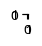

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE, PairedFVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss
from src.datasets import CDR3BetaDataset, PairedDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# init / defs

In [2]:
DISTANCES=['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan','braycurtis', 'canberra', 'chebyshev', 'correlation', 
 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 
 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
KERNELS = ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']

In [ ]:
CDR3bVAE

In [218]:
train_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
train_df.head()

A1        A2              A3      B1       B2              B3  binder  \
0    KALYS   LLKGGEQ  GTEIGGGTSYGKLT   MNHEY   SMNVEV        ASGTETQY       1   
1   DRGSQS    IYSNGD      AVNPANARLM  DFQATT  SNEGSKA    SARWGGGTDTQY       1   
2   TSGFNG    NVLDGL        AVGDDKII  DFQATT  SNEGSKA   SARGLDRGTNEQY       1   
3   DRGSQS    IYSNGD      AVTPGTYKYI   LGHDT   YNNKEL  ASSPGTSIFVAEQY       1   
4  TRDTTYY  RNSFDEQN     AFLYNQGGKLI   SGHDY   FNNNVP    ASSPGSRGNIQY       1   

      peptide original_peptide         TRAV       TRAJ         TRBV  \
0   KLGGALQAK        KLGGALQAK    TRAV30*01  TRAJ52*01    TRBV27*01   
1  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  TRAJ31*01  TRBV20-1*01   
2  AVFDRKSDAK       AVFDRKSDAK   TRAV1-2*01  TRAJ30*01  TRBV20-1*01   
3  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  TRAJ40*01   TRBV3-1*01   
4    RAKFKQLL         RAKFKQLL    TRAV19*01  TRAJ23*01  TRBV12-4*01   

         TRBJ  partition  Unnamed: 0       allele origin  original_index  \
0  TRBJ2-5*01          2     32208.0  HLA-A*03:01    10x          2627.0   
1  TRBJ2-3*01          3     37123.0  HLA-A*02:01    10x          3820.0   
2  TRBJ2-7*01          3     14961.0  HLA-A*11:01    10x          3592.0   
3  TRBJ2-7*01          0      8197.0  HLA-A*02:01    10x          5933.0   
4  TRBJ2-4*01          1     23616.0  HLA-B*08:01    10x          2745.0   

  TRBV_gene TRBJ_gene          TRA_CDR3          TRB_CDR3  
0    TRBV27   TRBJ2-5  CGTEIGGGTSYGKLTF        CASGTETQYF  
1  TRBV20-1   TRBJ2-3      CAVNPANARLMF    CSARWGGGTDTQYF  
2  TRBV20-1   TRBJ2-7        CAVGDDKIIF   CSARGLDRGTNEQYF  
3   TRBV3-1   TRBJ2-7      CAVTPGTYKYIF  CASSPGTSIFVAEQYF  
4  TRBV12-4   TRBJ2-4     CAFLYNQGGKLIF    CASSPGSRGNIQYF

In [5]:
ntcr = pd.read_csv('../data/NetTCR/new_train_df.csv')
ntcr = ntcr.drop(columns=['Unnamed: 0']).query('origin != "swapped"')
ntcr.to_csv('../data/filtered/231005_nettcr_pos_truenegs.csv', index=False)

In [6]:
df.sample(5)[['TRB_CDR3']]

TRB_CDR3
1470  CASSITWTGNMNTEAFF
5639   CASSQDGWAGDQPQHF
587     CASRTGLASTDTQYF
20         CASSYRGTEAFF
1884      CASSTRSDSPLHF

In [4]:
from joblib import Parallel, delayed
from functools import partial
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import *
from src.train_eval import predict_model

def bruteforce(n_clusters, ODIR):
    km = KMeans(n_clusters, n_init=100, max_iter=500, random_state=13)
    train_clusters = km.fit_predict(z_train_30k)
    valid_clusters = km.predict(z_valid_30k)
    gil_clusters = km.predict(z_gil_30k)
    name = f'KM_n{n_clusters:02}'
    train_preds_30k[name] = train_clusters
    valid_preds_30k[name] = valid_clusters
    gil_preds_30k[name] = gil_clusters
    train_summary, train_df = get_cluster_stats(train_preds_30k, name, 'peptide', 'z_1')
    valid_summary, valid_df = get_cluster_stats(valid_preds_30k, name, 'peptide', 'z_1')
    gil_summary, gil_df = get_cluster_stats(gil_preds_30k, name, 'peptide', 'z_1')
    train_summary.to_csv(f'{ODIR}train_summary_{name}.csv')
    train_df.to_csv(f'{ODIR}train_df_{name}.csv')
    valid_summary.to_csv(f'{ODIR}valid_summary_{name}.csv')
    valid_df.to_csv(f'{ODIR}valid_df_{name}.csv')
    gil_summary.to_csv(f'{ODIR}gil_summary_{name}.csv')
    gil_df.to_csv(f'{ODIR}gil_df_{name}.csv')
    
    for kernel in tqdm(['rbf', 'laplacian', 'cosine'], desc='sc kernel', position=1, leave=False):
        sc = SpectralClustering(n_clusters, affinity=kernel, n_init=30, random_state=13,n_jobs=1)
        clusters = sc.fit_predict(np.concatenate([z_train_30k, z_valid_30k, z_gil_30k], axis=0))
        train_clusters = clusters[:len(z_train_30k)]
        valid_clusters = clusters[len(z_train_30k): len(z_train_30k)+len(z_valid_30k)]
        gil_clusters = clusters[len(z_train_30k)+len(z_valid_30k):]
        name = f'SC_{kernel}_n{n_clusters:02}'
        train_preds_30k[name] = train_clusters
        valid_preds_30k[name] = valid_clusters
        gil_preds_30k[name] = gil_clusters
        train_summary, train_df = get_cluster_stats(train_preds_30k, name, 'peptide', 'z_1')
        valid_summary, valid_df = get_cluster_stats(valid_preds_30k, name, 'peptide', 'z_1')
        gil_summary, gil_df = get_cluster_stats(gil_preds_30k, name, 'peptide', 'z_1')
        train_summary.to_csv(f'{ODIR}train_summary_{name}.csv')
        train_df.to_csv(f'{ODIR}train_df_{name}.csv')
        valid_summary.to_csv(f'{ODIR}valid_summary_{name}.csv')
        valid_df.to_csv(f'{ODIR}valid_df_{name}.csv')
        gil_summary.to_csv(f'{ODIR}gil_summary_{name}.csv')
        gil_df.to_csv(f'{ODIR}gil_df_{name}.csv')

In [541]:
def get_cluster_stats(input_df, cluster='KMeans_Cluster', label='GroundTruth', feature='TSNE_1', kf=True):
    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            l = len(df)
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            summary['retention'] = (100 * summary['cluster_size']) / l
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        l = len(df)
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        # if 'set' in df.columns:
        #     summary['set'] = df.
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        summary['retention'] = 100 * summary['cluster_size'] / l
        return summary, df

def get_good_clusters(summary_df, percent=50, size=3, dict=False):
    tmp = summary_df.query('purity_percent>@percent and cluster_size>=@size')
    results = {'n_clusters':len(tmp), 'n_total_tcrs':tmp.cluster_size.sum(), 'mean_cluster_size': tmp.cluster_size.mean(), 'mean_purity': tmp.purity_percent.mean()} 
    if dict:
        return results
    else:
        return list(results.values())

def reassign_label_duplicates(cdr3b, df):
    max_label = df.query('TRB_CDR3==@cdr3b').groupby('peptide').agg(count=('binder','count')).idxmax().item()
    return max_label

# def and checks

In [79]:
summary_dfs_all = pd.read_csv('../output/cluster_analysis/summary_dfs_all.csv')
summary_dfs_top10 = pd.read_csv('../output/cluster_analysis/summary_dfs_top10.csv')

In [80]:
summary_dfs_all.head()

KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition    set  \
0               0   KLGGALQAK       19.512195           164          0  train   
1               1   KLGGALQAK       16.317992           239          0  train   
2               2   GILGFVFTL       27.391304           230          0  train   
3               3  AVFDRKSDAK       14.093960           149          0  train   
4               4   GILGFVFTL       16.528926           121          0  train   

  run_id  retention  
0  ClXaM   2.581458  
1  ClXaM   3.762002  
2  ClXaM   3.620337  
3  ClXaM   2.345349  
4  ClXaM   1.904612

In [109]:
summary_dfs_top10.groupby(['run_id', 'partition', 'set']).agg(max_purity = ('purity_percent', 'max')).query('max_purity>70')

max_purity
run_id partition set              
3jETu  2         train   72.144289
                 valid   70.149254
A0dGE  2         train   72.930649
                 valid   71.681416
KtR1W  2         valid   73.437500
NnzVv  1         valid   79.032258
       2         train   73.265306
                 valid   72.222222

In [111]:
summary_dfs_top10.groupby(['run_id', 'partition', 'set']).agg(max_purity = ('purity_percent', 'max')).query('max_purity>70')

max_purity
run_id partition set              
3jETu  2         train   72.144289
                 valid   70.149254
A0dGE  2         train   72.930649
                 valid   71.681416
KtR1W  2         valid   73.437500
NnzVv  1         valid   79.032258
       2         train   73.265306
                 valid   72.222222

In [110]:
summary_dfs_all.query('purity_percent>90')

KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition  \
1675              14   GILGFVFTL      100.000000             1          4   
2005               6   IVTDFSVIK       92.592593            54          2   
2109               6   IVTDFSVIK       94.736842            19          1   
2226              19   IVTDFSVIK       93.750000            16          0   
2733               6   KLGGALQAK      100.000000             1          0   
2758               5   IVTDFSVIK       94.736842            19          1   

        set run_id  retention  
1675  valid  B6jIc   0.015741  
2005  train  3jETu   0.849992  
2109  valid  LKzfT   0.299071  
2226  valid  x8CyX   0.251850  
2733  valid  KtR1W   0.015741  
2758  valid  KtR1W   0.299071

In [90]:
summary_dfs_top10.query('set=="valid" and purity_percent>50 and cluster_size>12').groupby('run_id')\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

count
run_id       
KtR1W       5
NnzVv       5
x8CyX       5
3jETu       4
A0dGE       3

In [92]:
summary_dfs_all.query('set=="valid" and purity_percent>50 and cluster_size>10').groupby(['run_id', 'partition'])\
                 .agg(count=('GroundTruth','count')).sort_values('count',ascending=False).head()

count
run_id partition       
j0xLE  1              6
ClXaM  4              5
3jETu  4              4
LKzfT  3              4
KtR1W  2              3

# GLIPH

In [225]:
# Redo the gliph thing, removing the duplicates
gliph_input = train_df.copy()
gliph_input['label'] = gliph_input['TRB_CDR3'].apply(reassign_label_duplicates, df=gliph_input)
gliph_input = gliph_input.drop_duplicates(['TRB_CDR3'])
print(len(gliph_input))

5178


In [264]:
import random
from random import randint
random.seed(13)
gliph_input['subject:condition'] = gliph_input['label'].apply(lambda x: f'{randint(0,99):02}/{randint(0,1000)}:{x}')
gliph_input['count'] = 1
gliph_input.to_csv('../data/GLIPH/save_to_gliph/231009_kcv_pos_nodupes_annotated.csv', index=False)
gliph_input[['TRB_CDR3', 'TRBV', 'TRBJ', 'TRA_CDR3', 'subject:condition', 'count']].to_csv('../data/GLIPH/save_to_gliph/231009_kcv_pos_nodupes_input.tsv', index=False, header=False, sep = '\t')


In [277]:
gliph = pd.read_csv('../output/GLIPH/231009_GLIPH_kcv_pos_only_nodupes.csv')
gliph = gliph[[x for x in gliph.columns if 'HLA' not in x]]
gliph['labels'] = gliph['Sample'].apply(lambda x: x.split(':')[1])
gliph

index pattern  Fisher_score  number_subject   number_unique_cdr3  \
0         1     IRS         0.000              50                   50   
1         1     IRS         0.000              50                   50   
2         1     IRS         0.000              50                   50   
3         1     IRS         0.000              50                   50   
4         1     IRS         0.000              50                   50   
...     ...     ...           ...             ...                  ...   
1756    633  S%GTDT         0.076               2                    2   
1757    634    S%GE         0.079               2                    2   
1758    634    S%GE         0.079               2                    2   
1759    635     SIF         0.130               2                    2   
1760    635     SIF         0.130               2                    2   

       final_score  hla_score  vb_score  expansion_score  length_score  \
0     1.400000e-11        1.0     0.001              1.0         0.001   
1     1.400000e-11        1.0     0.001              1.0         0.001   
2     1.400000e-11        1.0     0.001              1.0         0.001   
3     1.400000e-11        1.0     0.001              1.0         0.001   
4     1.400000e-11        1.0     0.001              1.0         0.001   
...            ...        ...       ...              ...           ...   
1756  1.900000e-06        1.0     0.066              1.0         0.001   
1757  1.700000e-06        1.0     0.059              1.0         0.001   
1758  1.700000e-06        1.0     0.059              1.0         0.001   
1759  3.500000e-04        1.0     0.067              1.0         0.180   
1760  3.500000e-04        1.0     0.067              1.0         0.180   

      cluster_size_score           type             ulTcRb               TcRb  \
0               0.000014      motif-IRS       CASSIrsTGELF       CASSIRSTGELF   
1               0.000014      motif-IRS      CASSIrsNTEAFF      CASSIRSNTEAFF   
2               0.000014      motif-IRS      CASSIrSGvEQYF      CASSIRSGVEQYF   
3               0.000014      motif-IRS      CASSIrsddIQYF      CASSIRSDDIQYF   
4               0.000014      motif-IRS        CSsirssdtQF        CSSIRSSDTQF   
...                  ...            ...                ...                ...   
1756            0.029000  global-S%GTDT       CASSLgTDTQYF       CASSLGTDTQYF   
1757            0.029000    global-S%GE         CASSfgEQFF         CASSFGEQFF   
1758            0.029000    global-S%GE         CASSVgEAFF         CASSVGEAFF   
1759            0.029000      motif-SIF   CASSPGTSifvaEQYF   CASSPGTSIFVAEQYF   
1760            0.029000      motif-SIF  CASSLeassifSYEQYF  CASSLEASSIFSYEQYF   

            V        J             TcRa             Sample  Freq      labels  
0      TRBV19  TRBJ2-2   CAVTYGGSQGNLIF   65/433:GILGFVFTL   1.0   GILGFVFTL  
1      TRBV19  TRBJ1-1  CAGDSGGGSQGNLIF   06/531:GILGFVFTL   1.0   GILGFVFTL  
2      TRBV19  TRBJ2-7  CAGGGDGGSQGNLIF    65/80:GILGFVFTL   1.0   GILGFVFTL  
3      TRBV19  TRBJ2-4   CGTADGGSQGNLIF    75/63:GILGFVFTL   1.0   GILGFVFTL  
4      TRBV19  TRBJ2-3     CGAGGGSQGNLF   85/616:GILGFVFTL   1.0   GILGFVFTL  
...       ...      ...              ...                ...   ...         ...  
1756   TRBV27  TRBJ2-3            CAASI  45/866:ELAGIGILTV   1.0  ELAGIGILTV  
1757  TRBV7-2  TRBJ2-1      CVVLNTDKLIF   98/743:GILGFVFTL   1.0   GILGFVFTL  
1758    TRBV2  TRBJ1-1    CAVYGGATNKLIF    23/782:RAKFKQLL   1.0    RAKFKQLL  
1759  TRBV3-1  TRBJ2-7     CAVTPGTYKYIF  23/667:ELAGIGILTV   1.0  ELAGIGILTV  
1760  TRBV5-1  TRBJ2-7     CAVNDYGQNFVF  66/661:ELAGIGILTV   1.0  ELAGIGILTV  

[1761 rows x 20 columns]

In [388]:
gliph_summary, gliph_df = get_cluster_stats(gliph, cluster='index', label = 'labels', kf=False, feature='TcRb')
get_good_clusters(gliph_summary, 60, 3)

(143, 729, 5.0979020979020975, 92.12634630591288)

In [283]:
1761 / len(gliph_input)

0.34009269988412516

In [285]:
gliph_summary.query('cluster_size>3').groupby(['labels']).agg(sum_cluster_sizes = ('cluster_size', 'sum')).sum() / len(gliph_input) 

sum_cluster_sizes    0.10815
dtype: float64

In [266]:
len(gliph['index'].unique())

878

# TCR pepkernel similarity adj matrix

In [26]:
adj_matrix = pd.read_csv('../data/filtered/230929_nettcr_pos_adj_matrix.csv', index_col='A')
adj_matrix.head()

CAAGDANTGELFF  CAAGGGGTEKLFF  CAAGQGNTGELFF  CAAGSSGNQPQHF  \
A                                                                           
CAAGDANTGELFF       1.000000       0.833791       0.922672       0.808271   
CAAGGGGTEKLFF       0.833791       1.000000       0.862865       0.797381   
CAAGQGNTGELFF       0.922672       0.862865       1.000000       0.816436   
CAAGSSGNQPQHF       0.808271       0.797381       0.816436       1.000000   
CAAGTRTDTQYF        0.821413       0.783272       0.808641       0.800289   

               CAAGTRTDTQYF  CAAGTSGRVGEQFF  CAAGWGIGTEAFF  CAAQNGNPNEKLFF  \
A                                                                            
CAAGDANTGELFF      0.821413        0.832520       0.803848        0.805701   
CAAGGGGTEKLFF      0.783272        0.818931       0.821764        0.771142   
CAAGQGNTGELFF      0.808641        0.844086       0.814680        0.810145   
CAAGSSGNQPQHF      0.800289        0.827664       0.754594        0.786589   
CAAGTRTDTQYF       1.000000        0.819381       0.778730        0.758944   

               CAASGRASETQYF  CACPPEEGGHYGYTF  ...  CSVYLNTEAFF  \
A                                              ...                
CAAGDANTGELFF       0.829519         0.698965  ...     0.790501   
CAAGGGGTEKLFF       0.806494         0.682179  ...     0.726746   
CAAGQGNTGELFF       0.820164         0.703386  ...     0.772854   
CAAGSSGNQPQHF       0.836283         0.693642  ...     0.733826   
CAAGTRTDTQYF        0.866828         0.677029  ...     0.802260   

               CSYSAGEDQPQHF  CTSIAPIF  CTSKSGGPYEQF  CTSRDLGVWTEAF  \
A                                                                     
CAAGDANTGELFF       0.772687  0.746653      0.785362       0.773166   
CAAGGGGTEKLFF       0.737543  0.697982      0.788385       0.729241   
CAAGQGNTGELFF       0.766710  0.725283      0.793320       0.756344   
CAAGSSGNQPQHF       0.834720  0.713450      0.814682       0.726523   
CAAGTRTDTQYF        0.779109  0.761954      0.786587       0.782478   

               CTSVPAAWDGASSYEQYF  CTSVPAVTVNFYGYTF  CTTSSGEADTQYF  \
A                                                                    
CAAGDANTGELFF            0.716327          0.723947       0.820330   
CAAGGGGTEKLFF            0.676698          0.669484       0.771741   
CAAGQGNTGELFF            0.695332          0.705312       0.804836   
CAAGSSGNQPQHF            0.708205          0.680435       0.811575   
CAAGTRTDTQYF             0.706870          0.730053       0.848794   

               CVPPYEKLTF  CVTGQGDINEQFF  
A                                         
CAAGDANTGELFF    0.724117       0.820758  
CAAGGGGTEKLFF    0.688156       0.780579  
CAAGQGNTGELFF    0.710612       0.839774  
CAAGSSGNQPQHF    0.698343       0.781084  
CAAGTRTDTQYF     0.744953       0.794340  

[5 rows x 5178 columns]

In [30]:
top10_pep = df.groupby(['peptide']).agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
top10_cdr3 = df.query('peptide in @top10_pep')['TRB_CDR3'].unique()
adj_top10 = adj_matrix.loc[top10_cdr3][top10_cdr3]

### spectral

In [32]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(26, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc = sc.fit_predict(adj_matrix)
sc = SpectralClustering(10, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc_top10 = sc.fit_predict(adj_top10)

In [59]:
sc_df = pd.DataFrame(np.array([adj_matrix.index, labels_sc]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df = pd.merge(df, sc_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary, sc_cluster_df = get_cluster_stats(sc_df, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

sc_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_sc_top10]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df_top10 = pd.merge(df, sc_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary_top10, sc_cluster_df_top10 = get_cluster_stats(sc_df_top10, cluster='sc_label', label='peptide', feature = 'B3', kf=False)

### k-means

In [39]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import KMeans
km = KMeans(26, n_init=50, max_iter=500)
labels_km = km.fit_predict(adj_matrix)
km = KMeans(10, n_init=50, max_iter=500)
labels_km_top10 = km.fit_predict(adj_top10)

In [60]:
km_df = pd.DataFrame(np.array([adj_matrix.index, labels_km]).T, columns = ['TRB_CDR3', 'km_label'])
km_df = pd.merge(df, km_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary, km_cluster_df = get_cluster_stats(km_df, cluster='km_label', label='peptide', feature = 'B3', kf=False)

km_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_km_top10]).T, columns = ['TRB_CDR3', 'km_label'])
km_df_top10 = pd.merge(df, km_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary_top10, km_cluster_df_top10 = get_cluster_stats(km_df_top10, cluster='km_label', label='peptide', feature = 'B3', kf=False)

In [62]:
display(sc_summary_top10)
display(km_summary_top10)

sc_label    peptide  purity_percent  cluster_size partition  retention
0         0  GILGFVFTL       25.986842           608       ALL  11.215643
1         1  GILGFVFTL       26.682692           416       ALL   7.673861
2         2  KLGGALQAK       23.750000           480       ALL   8.854455
3         3  IVTDFSVIK       17.325800           531       ALL   9.795241
4         4  GILGFVFTL       35.205479           730       ALL  13.466150
5         5   RAKFKQLL       31.319555           629       ALL  11.603025
6         6   RAKFKQLL       21.386139           505       ALL   9.315624
7         7  GILGFVFTL       19.646799           453       ALL   8.356392
8         8  KLGGALQAK       20.000000           510       ALL   9.407858
9         9   RAKFKQLL       19.499106           559       ALL  10.311751

km_label     peptide  purity_percent  cluster_size partition  retention
0         0   GILGFVFTL       23.869347           398       ALL   7.341819
1         1    RAKFKQLL       18.454936           466       ALL   8.596200
2         2   GILGFVFTL       33.050847           708       ALL  13.060321
3         3    RAKFKQLL       25.901639           915       ALL  16.878805
4         4   GILGFVFTL       43.193069           808       ALL  14.904999
5         5  AVFDRKSDAK       23.863636            88       ALL   1.623317
6         6   IVTDFSVIK       18.620690           435       ALL   8.024350
7         7   KLGGALQAK       20.033389           599       ALL  11.049622
8         8   KLGGALQAK       20.309051           453       ALL   8.356392
9         9   KLGGALQAK       17.967332           551       ALL  10.164176

# Hamming/levenshtein distance baseline

In [7]:
import numpy as np
from Levenshtein import distance as lvd

def pairwise_dist(seqs_a, seqs_b, fct):
    vectorized = np.vectorize(fct)
    return vectorized(seqs_a[:, np.newaxis], seqs_b)

In [ ]:
# Example usage:
# Need to redo with out duplicates otherwise we can too perfect clusters
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df['reassigned_label'] = df['TRB_CDR3'].apply(reassign_label_duplicates, df= df)
seqs_a = df.drop_duplicates(subset=['TRB_CDR3'])['TRB_CDR3'].values
seqs_b = df.drop_duplicates(subset=['TRB_CDR3'])['TRB_CDR3'].values
labels = df.drop_duplicates(subset=['TRB_CDR3'])['reassigned_label'].values
lvd_result_matrix = pairwise_dist(seqs_a, seqs_b, lvd)

In [857]:
lvd_matrix = pd.DataFrame(lvd_result_matrix, columns = seqs_a, index= seqs_a)
lvd_matrix['labels']=labels
lvd_matrix

CASGTETQYF  CSARWGGGTDTQYF  CSARGLDRGTNEQYF  \
CASGTETQYF                   0               6                8   
CSARWGGGTDTQYF               6               0                6   
CSARGLDRGTNEQYF              8               6                0   
CASSPGTSIFVAEQYF             8              11                9   
CASSPGSRGNIQYF               7               9                7   
...                        ...             ...              ...   
CASSLVVAGGPGTDTQYF           9               7               11   
CASSVVGAGGYNEQFF            10               9                9   
CASSPRSSYEQYF                7               9                8   
CASSARSTGELFF                8              10                9   
CASSTRATGELFF                7              10                9   

                    CASSPGTSIFVAEQYF  CASSPGSRGNIQYF  CASGKLAGVLSEQFF  \
CASGTETQYF                         8               7                9   
CSARWGGGTDTQYF                    11               9               10   
CSARGLDRGTNEQYF                    9               7                9   
CASSPGTSIFVAEQYF                   0               6                9   
CASSPGSRGNIQYF                     6               0               10   
...                              ...             ...              ...   
CASSLVVAGGPGTDTQYF                11               9               11   
CASSVVGAGGYNEQFF                   9               7                7   
CASSPRSSYEQYF                      6               5                9   
CASSARSTGELFF                      9               7                8   
CASSTRATGELFF                      9               8                8   

                    CASSATGTHSFGYTF  CASSQDPGFGGGSYEQYF  CASSMQTSGSAYNEQFF  \
CASGTETQYF                        8                  11                 11   
CSARWGGGTDTQYF                   10                  10                 12   
CSARGLDRGTNEQYF                  11                  10                 11   
CASSPGTSIFVAEQYF                  9                   8                  8   
CASSPGSRGNIQYF                    9                   8                  8   
...                             ...                 ...                ...   
CASSLVVAGGPGTDTQYF               11                   9                 11   
CASSVVGAGGYNEQFF                 10                   8                  6   
CASSPRSSYEQYF                     9                   7                  7   
CASSARSTGELFF                     8                  11                  9   
CASSTRATGELFF                     8                  11                  8   

                    CASSRGRGGQYNEQFF  ...  CASSVGLAGSNEQFF  CASSTGVYGYTF  \
CASGTETQYF                         9  ...                9             6   
CSARWGGGTDTQYF                     9  ...               10            10   
CSARGLDRGTNEQYF                    8  ...                7            11   
CASSPGTSIFVAEQYF                   8  ...                8             9   
CASSPGSRGNIQYF                     7  ...                6             7   
...                              ...  ...              ...           ...   
CASSLVVAGGPGTDTQYF                10  ...                9            10   
CASSVVGAGGYNEQFF                   4  ...                4             8   
CASSPRSSYEQYF                      7  ...                7             7   
CASSARSTGELFF                      8  ...                7             7   
CASSTRATGELFF                      8  ...                7             6   

                    CASSFWGRNVDTQYF  CASSFLGSRAEAFF  CASSLVVAGGPGTDTQYF  \
CASGTETQYF                        7               9                   9   
CSARWGGGTDTQYF                    6              11                   7   
CSARGLDRGTNEQYF                  10              11                  11   
CASSPGTSIFVAEQYF                  8               8                  11   
CASSPGSRGNIQYF                    7               7                   9   
...                             ...   

In [861]:
lvd_matrix.to_csv('../data/baselines/231005_nettcr_pos_unique_levenshtein_matrix.csv')

# Baselines ? 

## (Dis)Similarity matrix and Levenshtein Dist matrices

Because Agg Clustering uses DISTANCE matrix so need to compute dissimilarity through 1-sim

In [ ]:
sim_matrix = pd.read_csv('../data/baselines/230929_nettcr_pos_kernelsim_matrix.csv', index_col=0)
lvd_matrix = pd.read_csv('../data/baselines/231005_nettcr_pos_unique_levenshtein_matrix.csv', index_col=0)
dissim_matrix = 1-sim_matrix
dissim_matrix = pd.merge(dissim_matrix, lvd_matrix[['labels']], left_index=True, right_index=True)

# Get the labels so they're the same as the lvd matrix (because some duplicates might have been treated differently

# Here apparently the dissim matrix is not symmetrical (due to rounding errors, like x[i,j] = 0.26472, and x[j,i] = 0.26473
# So manually redo this shit with a stupid double loop
wtf = dissim_matrix.drop(columns=['labels']).copy()
for i in tqdm(range(len(wtf)), desc='x',position=0, leave=True):
    for j in range(len(wtf)):
        if j>=i:continue
        if wtf.iloc[i,j] != wtf.iloc[j,i]:
            wtf.iloc[i,j]=wtf.iloc[j,i]
dissim_matrix = pd.merge(wtf, lvd_matrix[['labels']], left_index=True, right_index=True)
dissim_matrix.head()

In [864]:
dissim_matrix.to_csv('../data/baselines/231006_nettcr_pos_unique_kernelDISSIM_matrix.csv')

In [866]:
len(dissim_matrix), len(lvd_matrix)

(5178, 5178)

In [392]:
def do_baseline_clustering(n_clusters, dissim_matrix, lvd_matrix, do_hdb=False):
    res_sim = {}
    res_lvd = {}
    print('Running for n_clusters=', n_clusters)
    for linkage in ['average', 'complete', 'single']:
        # Dissimilarity (pepkernel)
        ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
        ag_sim = ag.fit_predict(dissim_matrix.drop(columns=['labels']))
        ag_df = pd.DataFrame(np.array([dissim_matrix.index, ag_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_sim_{linkage}_label', 'labels'])
        ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
        res_sim[linkage]={}
        res_sim[linkage]['model'] = ag
        res_sim[linkage]['df'] = ag_df
        res_sim[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_sim_{linkage}_label', label='labels', feature='B3', kf=False)[0]
        goodclusters = get_good_clusters(res_sim[linkage]['summary'])
        print('sim', linkage, f"n_clusters={len(res_sim[linkage]['summary'][f'AG_sim_{linkage}_label'].unique())}, {goodclusters}")
        # LVD
        ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
        ag_lvd = ag.fit_predict(lvd_matrix.drop(columns=['labels']))
        ag_df = pd.DataFrame(np.array([lvd_matrix.index, ag_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_lvd_{linkage}_label', 'labels'])
        ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
        res_lvd[linkage]={}
        res_lvd[linkage]['model'] = ag
        res_lvd[linkage]['df'] = ag_df
        res_lvd[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_lvd_{linkage}_label', label='labels', feature='B3', kf=False)[0]
        goodclusters = get_good_clusters(res_lvd[linkage]['summary'])
        print('lvd', linkage, f"n_clusters={len(res_lvd[linkage]['summary'][f'AG_lvd_{linkage}_label'].unique())}, {goodclusters}")
    if do_hdb:
        for cse in range(0, 10):
            # LVD
            hdb=HDBSCAN(min_cluster_size=3, metric='precomputed', cluster_selection_epsilon=cse)
            hdb_lvd = hdb.fit_predict(lvd_matrix.drop(columns=['labels']))
            hdb_df = pd.DataFrame(np.array([lvd_matrix.index, hdb_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_lvd_{cse}_label', 'labels'])
            hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
            res_lvd[f'hdb_{cse}']={}
            res_lvd[f'hdb_{cse}']['model']=hdb
            res_lvd[f'hdb_{cse}']['df'] = hdb_df
            res_lvd[f'hdb_{cse}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_lvd_{cse}_label', label='labels', feature='B3', kf=False)[0]
            goodclusters = get_good_clusters(res_lvd[f'hdb_{cse}']['summary'])
            print(f'lvd: {cse:.1f}', f"n_clusters={len(res_lvd[f'hdb_{cse}']['summary'][f'hdb_lvd_{cse}_label'].unique())}, {goodclusters}")
    
        for cse in np.arange(0, 1.2, 0.1):
            # Dissimilarity (pepkernel)
            hdb=HDBSCAN(min_cluster_size=3, metric='precomputed', cluster_selection_epsilon=cse)
            hdb_sim = hdb.fit_predict(dissim_matrix.drop(columns=['labels']))
            hdb_df = pd.DataFrame(np.array([dissim_matrix.index, hdb_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_sim_{cse:.1}_label', 'labels'])
            hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
            res_sim[f'hdb_{cse:.1}']={}
            res_sim[f'hdb_{cse:.1}']['model']=hdb
            res_sim[f'hdb_{cse:.1}']['df'] = hdb_df
            res_sim[f'hdb_{cse:.1}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_sim_{cse:.1}_label', label='labels', feature='B3', kf=False)[0]
            goodclusters = get_good_clusters(res_sim[linkage]['summary'])
            print(f'sim: {cse:.1f}', f"n_clusters={len(res_sim[f'hdb_{cse:.1}']['summary'][f'hdb_sim_{cse:.1}_label'].unique())}, {goodclusters}")
    

    pkl_dump(res_sim, f'../output/231006_latent_analysis/231005_BASELINE_DISSIMILARITY_{n_clusters}_clusters.pkl')
    pkl_dump(res_lvd, f'../output/231006_latent_analysis/231005_BASELINE_LEVENSHTEIN_{n_clusters}_clusters.pkl')

In [371]:
# reread after saving for reproducibility
vd_matrix = pd.read_csv('../data/baselines/231005_nettcr_pos_unique_levenshtein_matrix.csv', index_col=0)
dissim_matrix = pd.read_csv('../data/baselines/231006_nettcr_pos_unique_kernelDISSIM_matrix.csv', index_col=0)

In [393]:
for nc in [27, 635, 878, 1000, 1250, 1500, 1750, 2000, 2250]:
    do_baseline_clustering(nc, dissim_matrix, lvd_matrix)

Running for n_clusters= 27
sim average n_clusters=27, {'n_clusters': 0, 'n tcrs total': 0, 'n tcrs mean': nan, 'mean purity': nan}
lvd average n_clusters=27, {'n_clusters': 2, 'n tcrs total': 6, 'n tcrs mean': 3.0, 'mean purity': 66.66666666666666}
sim complete n_clusters=27, {'n_clusters': 0, 'n tcrs total': 0, 'n tcrs mean': nan, 'mean purity': nan}
lvd complete n_clusters=27, {'n_clusters': 1, 'n tcrs total': 28, 'n tcrs mean': 28.0, 'mean purity': 53.57142857142857}
sim single n_clusters=27, {'n_clusters': 0, 'n tcrs total': 0, 'n tcrs mean': nan, 'mean purity': nan}
lvd single n_clusters=27, {'n_clusters': 0, 'n tcrs total': 0, 'n tcrs mean': nan, 'mean purity': nan}
/Users/riwa/Documents/code/tclustr/output/cluster_analysis/231005_BASELINE_DISSIMILARITY_27_clusters.pkl saved.
/Users/riwa/Documents/code/tclustr/output/cluster_analysis/231005_BASELINE_LEVENSHTEIN_27_clusters.pkl saved.
Running for n_clusters= 635
sim average n_clusters=635, {'n_clusters': 28, 'n tcrs total': 137, '

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    f,a = plt.subplots(1,1, figsize=(16,20))
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, ax=a)
    a.legend()
    return f,a
f,a = plot_dendrogram(res_sim['complete']['model'], truncate_mode='level', p=5)

In [871]:
res_sim['complete']['summary'].groupby(['labels']).agg(n_clusters=('cluster_size', 'count'), total_count=('cluster_size','sum'), 
                                                       min_purity=('purity_percent', 'min'), max_purity=('purity_percent', 'max'),
                                                       mean_purity=('purity_percent','mean'), std_purity=('purity_percent', 'std'))


n_clusters  total_count  min_purity  max_purity  mean_purity  \
labels                                                                       
ATDALMTGF             60          154   20.000000       100.0    66.861111   
AVFDRKSDAK           439         1078   14.285714       100.0    67.891270   
CINGVCWTV            133          265   16.666667       100.0    81.107812   
CTELKLSDY             30           58   25.000000       100.0    67.222222   
DATYQRTRALVR          42           99   20.000000       100.0    71.091437   
ELAGIGILTV           205          536   17.647059       100.0    72.789634   
FEDLRLLSF             11           15   50.000000       100.0    81.818182   
FEDLRVLSF              8           13   33.333333       100.0    72.916667   
GILGFVFTL            273          906   22.222222       100.0    75.876583   
GLCTLVAML             54          146   14.285714       100.0    72.683715   
GPRLGVRAT             17           21   50.000000       100.0    94.117647   
HPVTKYIM              17           23   50.000000       100.0    91.176471   
IVTDFSVIK             90          150   25.000000       100.0    77.388889   
KLGGALQAK            357          773   25.000000       100.0    81.216916   
KSKRTPMGF             20           32   50.000000       100.0    89.166667   
LLWNGPMAV             56          206   25.000000       100.0    68.908344   
NLVPMVATV            126          194   26.315789       100.0    91.900088   
RAKFKQLL             168          300   28.571429       100.0    89.147770   
RFPLTFGWCF            18           22   40.000000       100.0    96.666667   
RLPGVLPRA              6            7   50.000000       100.0    91.666667   
RLRAEAQVK             14           14  100.000000       100.0   100.000000   
RPPIFIRRL             11           15   50.000000       100.0    95.454545   
SLFNTVATLY             9           10   50.000000       100.0    94.444444   
SPRWYFYYL             56           77   50.000000       100.0    95.833333   
VLFGLGFAI             21           22  100.000000       100.0   100.000000   
YLQPRTFLL              9           42   66.666667       100.0    95.238095   

              std_purity  
labels                    
ATDALMTGF      31.332750  
AVFDRKSDAK     30.313210  
CINGVCWTV      26.525661  
CTELKLSDY      30.080777  
DATYQRTRALVR   30.606769  
ELAGIGILTV     28.607847  
FEDLRLLSF      25.226249  
FEDLRVLSF      29.462783  
GILGFVFTL      27.511683  
GLCTLVAML      28.537425  
GPRLGVRAT      16.605279  
HPVTKYIM       19.647631  
IVTDFSVIK      27.684293  
KLGGALQAK      25.943384  
KSKRTPMGF      19.701723  
LLWNGPMAV      27.108951  
NLVPMVATV      18.852317  
RAKFKQLL       21.203905  
RFPLTFGWCF     14.142136  
RLPGVLPRA      20.412415  
RLRAEAQVK       0.000000  
RPPIFIRRL      15.075567  
SLFNTVATLY     16.666667  
SPRWYFYYL      12.411301  
VLFGLGFAI       0.000000  
YLQPRTFLL      11.167657

# Latent analysis

Here, take only one fold that trained "well" (without spikes)

Only one hyperparams: 64 latent, wd = 1e-4, 10k epochs

-  Note to self: KtR1W says it has add_pep but I'm 98% sure that add_pep had not been done correctly (I spent all morning of wednesday 231004 to fix it) so this is just 25k epochs of CDR3b.
-  Re-ran two scripts : AddPep 25K epochs, wd=1e-4 (ID = 4soiY) and Normal CDR3b 30k epochs, wd=1e-4 (ID = EDHpH)
-  FOR THE ANALYSIS: TAKE ONLY EDHpH just to check stuff --> Take fold that is stable, compare test and train latent for GILGFVCTL (pos and true negs)

New IDS :
1. CDR3b + Pep, latent 64, wd 1e-4, 25k Epochs (4soiY) <-- might be useless idk if I fucked something up here.
2. CDR3b, no pep, latent 64, wd 1e-4, 30k Epochs (EDHpH)
3. CDR3a+b+pep, latent 128, wd 1e-4, 20k Epochs (8wkOD)
4. CDR3a+b, no pep, latent 128, wd 1e-4, 20k Epochs (3Cilu)

Bisecting K-means could be useful

## Some init checks and latent extraction

In [781]:
summary_dfs_top10.query('run_id=="NnzVv"').sort_values('purity_percent', ascending=False).head(25)

KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition  \
113               3   GILGFVFTL       79.032258           124          1   
320               0   GILGFVFTL       73.265306           490          2   
120               0   GILGFVFTL       72.222222           126          2   
313               3   GILGFVFTL       67.315175           514          1   
133               3   GILGFVFTL       62.500000            88          3   
338               8   GILGFVFTL       56.989247           372          3   
344               4   GILGFVFTL       56.325823           577          4   
144               4   GILGFVFTL       55.639098           133          4   
333               3   GILGFVFTL       52.769679           343          3   
138               8   GILGFVFTL       51.111111            90          3   
317               7    RAKFKQLL       49.375000           160          1   
300               0   GILGFVFTL       48.622366           617          0   
117               7    RAKFKQLL       47.619048            42          1   
100               0   GILGFVFTL       42.948718           156          0   
149               9   GILGFVFTL       41.666667            12          4   
109               9   GILGFVFTL       40.178571           112          0   
309               9   GILGFVFTL       37.439614           414          0   
327               7   GILGFVFTL       35.135135            37          2   
301               1    RAKFKQLL       35.127479           353          0   
136               6   GILGFVFTL       34.782609            69          3   
101               1    RAKFKQLL       33.333333            72          0   
107               7   KLGGALQAK       32.500000            40          0   
347               7   GILGFVFTL       29.916318           478          4   
328               8   KLGGALQAK       29.629630           108          2   
130               0    RAKFKQLL       28.571429           112          3   

       set run_id  retention  
113  valid  NnzVv   2.292899  
320  train  NnzVv   9.060651  
120  valid  NnzVv   2.329882  
313  train  NnzVv   9.504438  
133  valid  NnzVv   1.627219  
338  train  NnzVv   6.878698  
344  train  NnzVv  10.669379  
144  valid  NnzVv   2.459320  
333  train  NnzVv   6.342456  
138  valid  NnzVv   1.664201  
317  train  NnzVv   2.958580  
300  train  NnzVv  11.409024  
117  valid  NnzVv   0.776627  
100  valid  NnzVv   2.884615  
149  valid  NnzVv   0.221893  
109  valid  NnzVv   2.071006  
309  train  NnzVv   7.655325  
327  train  NnzVv   0.684172  
301  train  NnzVv   6.527367  
136  valid  NnzVv   1.275888  
101  valid  NnzVv   1.331361  
107  valid  NnzVv   0.739645  
347  train  NnzVv   8.838757  
328  train  NnzVv   1.997041  
130  valid  NnzVv   2.071006

In [782]:
folder30k = '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/'
subfolders30k = sorted([f'{folder30k}{x}' for x in os.listdir(folder30k) if os.path.isdir(f'{folder30k}{x}') and 'store' not in x.lower()])

folder10k = '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/'
subfolders10k = sorted([f'{folder10k}{x}' for x in os.listdir(folder10k) if os.path.isdir(f'{folder10k}{x}') and 'store' not in x.lower()])
subfolders10k, subfolders30k


(['../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_0_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_1_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_2_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_3_230928_1820_NnzVv',
  '../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_KFold_4_230928_1820_NnzVv'],
 ['../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_EDHpH/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_0_231004_1726_EDHpH',
  '../output/30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_ED

In [685]:
ls['valid_total'].index(min(ls['valid_total']))

29930

In [905]:
# Just take fold == 2 and do something here...
from torch.utils.data import SequentialSampler
from src.torch_utils import load_checkpoint
from src.models import CDR3bVAE
from src.datasets import CDR3BetaDataset

max_len, encoding, pad_scale, aa_dim = 25, 'BL50LO', -20, 20
hidden_dim, latent_dim = 128, 64
use_v, use_j = False,  False
fold=2
train = df.query('partition!=@fold')
train_dataset = CDR3BetaDataset(train, max_len, encoding, pad_scale, 'TRB_CDR3',  use_v, use_j)
train_loader = train_dataset.get_dataloader(1024, SequentialSampler)
valid = df.query('partition==@fold')
valid_dataset = CDR3BetaDataset(valid, max_len, encoding, pad_scale, 'TRB_CDR3',  use_v, use_j)
valid_loader = valid_dataset.get_dataloader(1024, SequentialSampler)
# take this as the "test set"
gil_testdf = ntcr.query('peptide=="GILGFVFTL" and CDR3b not in @train_preds_30k.TRB_CDR3.unique()')
gil_dataset = CDR3BetaDataset(gil_testdf, max_len, encoding, pad_scale, 'CDR3b', use_v, use_j)
gil_loader = gil_dataset.get_dataloader(1024, SequentialSampler)

In [931]:
from src.models import CDR3bVAE
# reloading models
print('30k')
model_30k = CDR3bVAE(max_len, encoding, pad_scale, aa_dim, use_v, use_j, hidden_dim=hidden_dim, latent_dim=latent_dim)
model_30k = load_checkpoint(model_30k, f'{subfolders30k[fold]}/checkpoint_best_fold{fold:02}_kcv_230927_nettcr_positives_only_f{fold:02}_30K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_KFold_{fold}_231004_1756_EDHpH.pt')

model_30k.train()
train_preds_30k_repam = predict_model(model_30k, train_dataset, train_loader)
valid_preds_30k_repam = predict_model(model_30k, valid_dataset, valid_loader)
gil_preds_30k_repam = predict_model(model_30k, gil_dataset, gil_loader)


30k
25
Reloading best model:
Best epoch: 26660
Valid loss: {'total': 0.14889138590239878, 'reconstruction': 0.08501176325217732, 'kld': 0.06387961965124563}
total: 0.14889138590239878
reconstruction: 0.08501176325217732
kld: 0.06387961965124563
seq_accuracy: 0.9841359257698059
v_accuracy: 0
j_accuracy: 0


In [932]:
from sklearn.manifold import TSNE
from sklearn.cluster import *
from src.train_eval import predict_model
# HERE: NEED TO TEST 2 THINGS ; WITH AND WITHOUT THE REPARAMETERISATION TRICK (i.e. set model to train and model to eval to get 2 different preds)

model_30k.eval(), 
train_preds_30k_norep = predict_model(model_30k, train_dataset, train_loader)
valid_preds_30k_norep = predict_model(model_30k, valid_dataset, valid_loader)
gil_preds_30k_norep = predict_model(model_30k, gil_dataset, gil_loader)

In [937]:
check1 = train_preds_30k_repam.loc[train_preds_30k_repam.duplicated(subset=['TRB_CDR3'], keep=False)].sort_values('TRB_CDR3',ascending=False).head(2)
check2 = train_preds_30k_norep.loc[train_preds_30k_norep.duplicated(subset=['TRB_CDR3'], keep=False)].sort_values('TRB_CDR3',ascending=False).head(2)
display(pd.concat([check1, check2]))
del check1, check2

A1       A2             A3     B1       B2           B3  binder  \
2783  NSASDY  IRSNMDK  AETHSGGSNYKLT  SQVTM  ANQGSEA  SYSAGEDQPQH       1   
2841   KTLYG  LQKGGEE    GADGGGTYKYI  SQVTM  ANQGSEA  SYSAGEDQPQH       1   
2783  NSASDY  IRSNMDK  AETHSGGSNYKLT  SQVTM  ANQGSEA  SYSAGEDQPQH       1   
2841   KTLYG  LQKGGEE    GADGGGTYKYI  SQVTM  ANQGSEA  SYSAGEDQPQH       1   

       peptide original_peptide         TRAV  ...      z_54      z_55  \
2783  RAKFKQLL         RAKFKQLL  TRAV13-2*01  ... -0.064639  1.712648   
2841  RAKFKQLL         RAKFKQLL    TRAV34*01  ... -0.225363 -1.256403   
2783  RAKFKQLL         RAKFKQLL  TRAV13-2*01  ... -0.047375 -0.024518   
2841  RAKFKQLL         RAKFKQLL    TRAV34*01  ... -0.047375 -0.024518   

          z_56      z_57      z_58      z_59      z_60      z_61      z_62  \
2783 -0.269808 -1.070404 -0.781021  0.158886  0.620325 -1.181057 -1.018580   
2841  1.410100  1.363762 -0.043530  0.190399  1.218748  0.908588 -0.619152   
2783 -0.008157 -0.032389  0.005203  0.247242  0.008917  0.016534 -1.008843   
2841 -0.008157 -0.032389  0.005203  0.247242  0.008917  0.016534 -1.008843   

          z_63  
2783 -0.712414  
2841  0.355045  
2783  0.024828  
2841  0.024828  

[4 rows x 92 columns]

### Quick checks because of duplicated TRB_CDR3

For duplicated TRBCDR3, will re-assign as label the largest amount of peptides. If there are only 1 of each, then will pick one at random

In [844]:
query=train_preds_30k.loc[train_preds_30k.duplicated(subset='TRB_CDR3', keep=False)][['TRA_CDR3', 'TRB_CDR3', 'peptide']].sort_values('TRB_CDR3')

In [845]:
# here for example for this CDR3 the "true" epitope shuold be RAKFKQLL.
query.query('TRB_CDR3 == "CASSFSGNTGELFF"').groupby('peptide').count()

TRA_CDR3  TRB_CDR3
peptide                      
GILGFVFTL         5         5
IVTDFSVIK         1         1
RAKFKQLL         77        77

In [846]:
train_preds_30k.query('TRB_CDR3=="CASSFSGNTGELFF"').groupby('peptide').agg(count=('binder','count')).idxmax().item()

'RAKFKQLL'

In [847]:
train_preds_30k.query('TRB_CDR3=="CASSQLGRGDNEQFF"')[['TRA_CDR3', 'TRB_CDR3', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'peptide']]

TRA_CDR3         TRB_CDR3         TRAV       TRAJ        TRBV  \
2982  CAREHMDSNYQLIW  CASSQLGRGDNEQFF   TRAV9-2*01  TRAJ33*01  TRBV7-9*01   
3418   CAASETSYDKVIF  CASSQLGRGDNEQFF  TRAV13-1*01  TRAJ50*01  TRBV7-9*01   
5028  CAGAGGGSQGNLIF  CASSQLGRGDNEQFF    TRAV27*01  TRAJ42*01  TRBV7-9*01   

            TRBJ     peptide  
2982  TRBJ2-1*01  AVFDRKSDAK  
3418  TRBJ2-1*01    RAKFKQLL  
5028  TRBJ2-1*01   GILGFVFTL

In [848]:
def fct(x):
    return len(np.unique(x))
problems=query.groupby(['TRB_CDR3']).agg(n_pep = ('peptide',fct)).query('n_pep>2')
query.query('TRB_CDR3 in @problems.index').groupby(['TRB_CDR3', 'peptide']).count()

TRA_CDR3
TRB_CDR3            peptide             
CASSFSGNTGELFF      GILGFVFTL          5
                    IVTDFSVIK          1
                    RAKFKQLL          77
CASSIRSSYEQYF       AVFDRKSDAK         1
                    ELAGIGILTV         1
                    GILGFVFTL         60
                    IVTDFSVIK          1
                    RAKFKQLL           4
CASSITEGEDSVSTDTQYF GILGFVFTL          1
                    IVTDFSVIK          1
                    RAKFKQLL           2
CASSLDTQYF          GILGFVFTL          1
                    GLCTLVAML          1
                    RAKFKQLL           1
CASSLGVAGTNTGELFF   ELAGIGILTV         1
                    GILGFVFTL          1
                    GLCTLVAML          2
                    IVTDFSVIK          1
                    RAKFKQLL           3
CASSLMRGGTYNSPLHF   GILGFVFTL          3
                    GLCTLVAML          1
                    RAKFKQLL           3
CASSLRDGSEAFF       AVFDRKSDAK         1
                    GILGFVFTL          2
                    GLCTLVAML          1
                    RAKFKQLL          46
CASSPRDRERGEQYF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           2
CASSPVTGGGSGANVLTF  AVFDRKSDAK         1
                    GILGFVFTL          2
                    IVTDFSVIK          1
                    RAKFKQLL           2
CASSQEWLAVSTDTQYF   GILGFVFTL          2
                    IVTDFSVIK          1
                    RAKFKQLL           3
CASSQLGRGDNEQFF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           1
CASSSGLVSNTGELFF    GILGFVFTL          2
                    GLCTLVAML          5
                    IVTDFSVIK          1
CASSSLDVAGYEQYF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           4
CASSSTGGGEKDQPQHF   AVFDRKSDAK         1
                    GILGFVFTL          3
                    GLCTLVAML          2
                    IVTDFSVIK          1
                    RAKFKQLL           5
CASSTRSSYEQYF       GILGFVFTL          7
                    GLCTLVAML          1
                    LLWNGPMAV          1
                    RAKFKQLL           1
CASSVAVGTGSGANVLTF  GILGFVFTL          1
                    GLCTLVAML          1
                    RAKFKQLL           1
CASSVRSSMNTEAFF     AVFDRKSDAK         1
                    GILGFVFTL          1
                    RAKFKQLL           4
CATSTGDSNQPQHF      AVFDRKSDAK         2
                    GLCTLVAML          1
                    RAKFKQLL           1
CSASPGDYEQYF        GILGFVFTL          1
                    IVTDFSVIK          1
                    RAKFKQLL           2

In [850]:
# SEE AT THE VERY TOP FOR RE-ASSIGN LABEL BECAUSE I DO IT AS WELL FOR THE LVD MATRIX AS WELL AS THE SIM (DISSIM) MATRIX
query['test'] = query['TRB_CDR3'].apply(reassign_label_duplicates, df=train_preds_30k)

In [853]:
query.query('peptide!=test').sort_values('TRB_CDR3', ascending=False)

TRA_CDR3           TRB_CDR3     peptide       test
4306      CAGHTGNQFYF      CSVGTGDWGEQYF   IVTDFSVIK   RAKFKQLL
829    CAENGGGGADGLTF      CSVGSGDHGEQFF   GLCTLVAML   RAKFKQLL
4395  CAESEGPTYTDKLIF        CSGLYQETQYF    RAKFKQLL  GILGFVFTL
4968     CAVHGYGQNFVF       CSASPGDYEQYF   IVTDFSVIK   RAKFKQLL
4086  CAASMGGGSQGNLIF       CSASPGDYEQYF   GILGFVFTL   RAKFKQLL
...               ...                ...         ...        ...
1814  CAFMKLAGANSKLTF   CASKSEKGAGGSPLHF  SLFNTVATLY   RAKFKQLL
1856  CAMSGDGGSQGNLIF      CASGRLSYNEQFF   GILGFVFTL   RAKFKQLL
2454    CADSGGGADGLTF     CASGMTGLTSEQYF    RAKFKQLL  GILGFVFTL
1335    CADSGGGADGLTF     CASAPDGFFYGYTF    RAKFKQLL  GILGFVFTL
1375    CADSGGGADGLTF  CASAHPRASGSTDTQYF    RAKFKQLL  GILGFVFTL

[127 rows x 4 columns]

## Latent comparisons with some pairwise metrics

In [278]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
def plot_latent(df, cols, hue):
    vars_ = cols
    print(f'VAE latent space representation for {cols[0]}-{cols[-1]}')
    g = sns.PairGrid(df, x_vars = vars_,
                     y_vars = vars_,
                     diag_sharey=False, hue=hue)
    g.fig.suptitle(f'VAE latent space representation for {cols[0]}-{cols[-1]}', fontweight='bold')
    g.fig.subplots_adjust(top=0.92)
    g.map_lower(sns.scatterplot,  alpha=0.75)
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    f.tight_layout()
    plt.show()

def pairwise_dist(seqs_a, seqs_b, fct):
    vectorized = np.vectorize(fct)
    return vectorized(seqs_a[:, np.newaxis], seqs_b)


## Reassigning labels for ALL duplicates and drop dupes and saving

In [952]:
# See reassign fct above in section #1 init / defs

train_preds_30k_repam['set']='train'
valid_preds_30k_repam['set']='valid'
gil_preds_30k_repam_pos = gil_preds_30k_repam.query('binder==1').assign(set='gil_pos').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})
gil_preds_30k_repam_neg = gil_preds_30k_repam.query('binder==0').assign(set='gil_neg').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})
train_preds_30k_norep['set']='train'
valid_preds_30k_norep['set']='valid'
gil_preds_30k_norep_pos = gil_preds_30k_norep.query('binder==1').assign(set='gil_pos').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})
gil_preds_30k_norep_neg = gil_preds_30k_norep.query('binder==0').assign(set='gil_neg').rename(columns = {'CDR3b':'TRB_CDR3', 'CDR3a':'TRA_CDR3'})

train_preds_30k_repam['labels'] = train_preds_30k_repam['TRB_CDR3'].apply(reassign_label_duplicates, df= train_preds_30k_repam)
valid_preds_30k_repam['labels'] = valid_preds_30k_repam['TRB_CDR3'].apply(reassign_label_duplicates, df= valid_preds_30k_repam)
gil_preds_30k_repam_pos['labels'] = gil_preds_30k_repam_pos['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_repam_pos)
gil_preds_30k_repam_neg['labels'] = gil_preds_30k_repam_neg['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_repam_neg)
train_preds_30k_norep['labels'] = train_preds_30k_norep['TRB_CDR3'].apply(reassign_label_duplicates, df= train_preds_30k_norep)
valid_preds_30k_norep['labels'] = valid_preds_30k_norep['TRB_CDR3'].apply(reassign_label_duplicates, df= valid_preds_30k_norep)
gil_preds_30k_norep_pos['labels'] = gil_preds_30k_norep_pos['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_norep_pos)
gil_preds_30k_norep_neg['labels'] = gil_preds_30k_norep_neg['TRB_CDR3'].apply(reassign_label_duplicates, df= gil_preds_30k_norep_neg)

In [953]:
del train_preds_30k, valid_preds_30k, gil_preds_30k_pos, gil_preds_30k_neg

In [965]:
# These are with duplicates !!
os.makedirs('../data/preds_30k/',exist_ok=True)
train_preds_30k_repam.to_csv('../data/preds_30k/train_preds_30k_reparameterised.csv', index=False)
valid_preds_30k_repam.to_csv('../data/preds_30k/valid_preds_30k_reparameterised.csv', index=False)
gil_preds_30k_repam_pos.to_csv('../data/preds_30k/gil_preds_30k_POSITIVES_reparameterised.csv', index=False)
gil_preds_30k_repam_neg.to_csv('../data/preds_30k/gil_preds_30k_NEGATIVES_reparameterised.csv', index=False)

train_preds_30k_norep.to_csv('../data/preds_30k/train_preds_30k_noreparam_mu_only.csv', index=False)
valid_preds_30k_norep.to_csv('../data/preds_30k/valid_preds_30k_noreparam_mu_only.csv', index=False)
gil_preds_30k_norep_pos.to_csv('../data/preds_30k/gil_preds_30k_POSITIVES_noreparam_mu_only.csv', index=False)
gil_preds_30k_norep_neg.to_csv('../data/preds_30k/gil_preds_30k_PONEGAVES_noreparam_mu_only.csv', index=False)

In [966]:
cat_repam = pd.concat([train_preds_30k_repam ,valid_preds_30k_repam, 
                          gil_preds_30k_repam_pos.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'}), 
                          gil_preds_30k_repam_neg.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'})]).drop_duplicates(subset=['TRB_CDR3'])
cat_repam['seq_id'] = [f'seq_{id:05}' for id in range(len(cat_repam))]
cat_norep = pd.concat([train_preds_30k_norep ,valid_preds_30k_norep, 
                          gil_preds_30k_norep_pos.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'}), 
                          gil_preds_30k_norep_neg.rename(columns= {'v_alpha':'TRAV', 'j_alpha':'TRAJ', 'v_beta':'TRBV', 'j_beta':'TRBJ'})]).drop_duplicates(subset=['TRB_CDR3'])
cat_norep['seq_id'] = [f'seq_{id:05}' for id in range(len(cat_norep))]
display(cat_norep.head())
display(cat_repam.head())

A1        A2           A3      B1       B2              B3  binder  \
0   DRGSQS    IYSNGD   AVNPANARLM  DFQATT  SNEGSKA    SARWGGGTDTQY       1   
1   TSGFNG    NVLDGL     AVGDDKII  DFQATT  SNEGSKA   SARGLDRGTNEQY       1   
2   DRGSQS    IYSNGD   AVTPGTYKYI   LGHDT   YNNKEL  ASSPGTSIFVAEQY       1   
3  TRDTTYY  RNSFDEQN  AFLYNQGGKLI   SGHDY   FNNNVP    ASSPGSRGNIQY       1   
4   DRGSQS    IYSNGD  ASPGGGADGLT   SGHDT   YYEEEE   ASSATGTHSFGYT       1   

      peptide original_peptide         TRAV  ...      z_57      z_58  \
0  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ... -0.037022  0.012112   
1  AVFDRKSDAK       AVFDRKSDAK   TRAV1-2*01  ... -0.028032  0.008912   
2  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ... -0.004020  0.023565   
3    RAKFKQLL         RAKFKQLL    TRAV19*01  ... -0.002554  0.010025   
4  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ... -0.006932  0.008597   

       z_59      z_60      z_61      z_62      z_63    set      labels  \
0  0.919840 -0.009918 -0.006479 -2.497391  0.031239  train  ELAGIGILTV   
1  1.303658 -0.006796 -0.000062  0.632049  0.025875  train  AVFDRKSDAK   
2 -0.103526  0.012900  0.005799  3.214355  0.039064  train  ELAGIGILTV   
3  1.053022 -0.002714 -0.002268 -0.433950  0.006993  train    RAKFKQLL   
4  1.758195  0.013911  0.019836  0.272313 -0.000623  train  ELAGIGILTV   

      seq_id  
0  seq_00000  
1  seq_00001  
2  seq_00002  
3  seq_00003  
4  seq_00004  

[5 rows x 95 columns]

A1        A2           A3      B1       B2              B3  binder  \
0   DRGSQS    IYSNGD   AVNPANARLM  DFQATT  SNEGSKA    SARWGGGTDTQY       1   
1   TSGFNG    NVLDGL     AVGDDKII  DFQATT  SNEGSKA   SARGLDRGTNEQY       1   
2   DRGSQS    IYSNGD   AVTPGTYKYI   LGHDT   YNNKEL  ASSPGTSIFVAEQY       1   
3  TRDTTYY  RNSFDEQN  AFLYNQGGKLI   SGHDY   FNNNVP    ASSPGSRGNIQY       1   
4   DRGSQS    IYSNGD  ASPGGGADGLT   SGHDT   YYEEEE   ASSATGTHSFGYT       1   

      peptide original_peptide         TRAV  ...      z_57      z_58  \
0  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  1.321671  0.263137   
1  AVFDRKSDAK       AVFDRKSDAK   TRAV1-2*01  ...  0.951260 -0.420481   
2  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  1.607870  0.382154   
3    RAKFKQLL         RAKFKQLL    TRAV19*01  ... -1.253203  1.600475   
4  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  0.173220  0.627348   

       z_59      z_60      z_61      z_62      z_63    set      labels  \
0  0.807252  0.123205 -0.228480 -2.778790  0.593435  train  ELAGIGILTV   
1  1.042142 -0.777457  1.242517  0.667326  0.598259  train  AVFDRKSDAK   
2 -0.061401 -0.152138 -0.686362  3.225466  0.974028  train  ELAGIGILTV   
3  0.820530 -1.911506 -0.978183 -0.634139 -0.309554  train    RAKFKQLL   
4  1.934787 -0.576115  0.138916  0.283834  0.397887  train  ELAGIGILTV   

      seq_id  
0  seq_00000  
1  seq_00001  
2  seq_00002  
3  seq_00003  
4  seq_00004  

[5 rows x 95 columns]

In [968]:
cat_repam.to_csv('../data/preds_30k/231006_concat_no_dupes_preds_repam.csv', index=False)
cat_norep.to_csv('../data/preds_30k/231006_concat_no_dupes_preds_norep.csv', index=False)

## Running distances metrics for de-duped df 

In [8]:
cat_repam = pd.read_csv('../data/preds_30k/231006_concat_no_dupes_preds_repam.csv')
cat_norep = pd.read_csv('../data/preds_30k/231006_concat_no_dupes_preds_norep.csv')

In [791]:
%mkdir ../data/231006_latent_dists/

In [13]:
z_cols = [f'z_{i}' for i in range(64)]

In [14]:
Z_norep = cat_norep[z_cols].values
Z_repam = cat_repam[z_cols].values
seq_idx_cols = cat_repam.TRB_CDR3.values
labels = np.expand_dims(cat_repam.labels.values, 1)
ids = np.expand_dims(cat_repam.seq_id.values, 1)
sets = np.expand_dims(cat_repam.set.values, 1)

In [18]:
os.path.exists(f'{odir}231006_dist_manhattan_cat_repam.csv')

True

In [ ]:
from sklearn.metrics import pairwise_distances, pairwise_kernels
odir = '../data/231006_latent_dists/'
for kernel in tqdm(['rbf', 'laplacian', 'cosine'], desc='metric', position=0):
    out_repam = pairwise_kernels(X=Z_repam, metric=kernel)
    pd.DataFrame(np.concatenate([out_repam, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_kernel_{kernel}_cat_repam.csv')
    del out_repam  
    out_norep = pairwise_kernels(X=Z_norep, metric=kernel)
    pd.DataFrame(np.concatenate([out_norep, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_kernel_{kernel}_cat_norep.csv')
    del out_norep 

In [21]:
for distance in tqdm(['cosine', 'euclidean', 'manhattan', 'correlation', 'hamming', 'jaccard'], desc='metric', position=1):
    print(distance)
    if (os.path.exists(f'{odir}231006_dist_{distance}_cat_repam.csv') and os.path.exists(f'{odir}231006_dist_{distance}_cat_norep.csv')):continue
    out_repam = pairwise_distances(X=Z_repam, metric=distance)
    pd.DataFrame(np.concatenate([out_repam, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_dist_{distance}_cat_repam.csv')
    del out_repam 
    out_norep = pairwise_distances(X=Z_norep, metric=distance)
    pd.DataFrame(np.concatenate([out_norep, labels, ids, sets], axis=1), index=seq_idx_cols, columns = list(seq_idx_cols) + ['labels', 'ids', 'set']).to_csv(f'{odir}231006_dist_{distance}_cat_norep.csv')
    del out_norep 


metric:   0%|                                                                                                            | 0/6 [00:00<?, ?it/s]

cosine
euclidean
manhattan
correlation



metric:  67%|██████████████████████████████████████████████████████████████████▋                                 | 4/6 [02:21<01:10, 35.31s/it]

hamming



metric:  83%|███████████████████████████████████████████████████████████████████████████████████▎                | 5/6 [03:06<00:37, 37.80s/it]

jaccard



metric: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:55<00:00, 39.27s/it]


In [55]:
tdf = pd.read_csv('../data/231006_latent_dists/231006_dist_cosine_cat_repam.csv', index_col=0)

In [34]:
file = '../data/231006_latent_dists/231006_dist_cosine_cat_repam.csv'
latent_kind = file.split('cat_')[1].split('.csv')[0]
dist_kind = os.path.basename(file).split('.csv')[0].split('_cat')[0].replace('231006_','')

In [23]:
input_matrix = tdf.drop(columns= ['labels', 'ids', 'set']).iloc[:, :200]
labels = tdf['labels'].values
ids = tdf['ids'].values
sets = tdf['set'].values

In [17]:
ag = AgglomerativeClustering(n_clusters=1)
pred_clusters = ag.fit_predict(input_matrix)

In [30]:
tdf[['labels', 'ids', 'set']]

labels        ids    set
CSARWGGGTDTQYF     ELAGIGILTV  seq_00000  train
CSARGLDRGTNEQYF    AVFDRKSDAK  seq_00001  train
CASSPGTSIFVAEQYF   ELAGIGILTV  seq_00002  train
CASSPGSRGNIQYF       RAKFKQLL  seq_00003  train
CASSATGTHSFGYTF    ELAGIGILTV  seq_00004  train
...                       ...        ...    ...
CASRPPGGQGSLF       IVTDFSVIK  seq_00195  train
CASAFYSNQPQHF       GILGFVFTL  seq_00196  train
CASSSTGGGEKDQPQHF    RAKFKQLL  seq_00197  train
CASSFRGEVPYEQYF    AVFDRKSDAK  seq_00198  train
CANDAPPHSTDTQYF      RAKFKQLL  seq_00199  train

[200 rows x 3 columns]

In [46]:
ag_df = pd.DataFrame(np.stack([input_matrix.index, pred_clusters, labels, ids, sets], axis=1), columns = ['TRB_CDR3', 'pred_cluster', 'labels', 'ids', 'set'])

In [45]:
base_df = pd.read_csv(f'../data/preds_30k/231006_concat_no_dupes_preds_{latent_kind}.csv')
base_df.head()

A1        A2           A3      B1       B2              B3  binder  \
0   DRGSQS    IYSNGD   AVNPANARLM  DFQATT  SNEGSKA    SARWGGGTDTQY       1   
1   TSGFNG    NVLDGL     AVGDDKII  DFQATT  SNEGSKA   SARGLDRGTNEQY       1   
2   DRGSQS    IYSNGD   AVTPGTYKYI   LGHDT   YNNKEL  ASSPGTSIFVAEQY       1   
3  TRDTTYY  RNSFDEQN  AFLYNQGGKLI   SGHDY   FNNNVP    ASSPGSRGNIQY       1   
4   DRGSQS    IYSNGD  ASPGGGADGLT   SGHDT   YYEEEE   ASSATGTHSFGYT       1   

      peptide original_peptide         TRAV  ...      z_57      z_58  \
0  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  1.321671  0.263137   
1  AVFDRKSDAK       AVFDRKSDAK   TRAV1-2*01  ...  0.951260 -0.420481   
2  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  1.607870  0.382154   
3    RAKFKQLL         RAKFKQLL    TRAV19*01  ... -1.253203  1.600475   
4  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  0.173220  0.627348   

       z_59      z_60      z_61      z_62      z_63    set      labels  \
0  0.807252  0.123205 -0.228480 -2.778789  0.593435  train  ELAGIGILTV   
1  1.042142 -0.777457  1.242517  0.667326  0.598259  train  AVFDRKSDAK   
2 -0.061401 -0.152138 -0.686362  3.225466  0.974028  train  ELAGIGILTV   
3  0.820530 -1.911506 -0.978183 -0.634139 -0.309554  train    RAKFKQLL   
4  1.934787 -0.576115  0.138916  0.283834  0.397887  train  ELAGIGILTV   

      seq_id  
0  seq_00000  
1  seq_00001  
2  seq_00002  
3  seq_00003  
4  seq_00004  

[5 rows x 95 columns]

In [48]:
ag_df

A1        A2              A3      B1       B2               B3  \
0     DRGSQS    IYSNGD      AVNPANARLM  DFQATT  SNEGSKA     SARWGGGTDTQY   
1     TSGFNG    NVLDGL        AVGDDKII  DFQATT  SNEGSKA    SARGLDRGTNEQY   
2     DRGSQS    IYSNGD      AVTPGTYKYI   LGHDT   YNNKEL   ASSPGTSIFVAEQY   
3    TRDTTYY  RNSFDEQN     AFLYNQGGKLI   SGHDY   FNNNVP     ASSPGSRGNIQY   
4     DRGSQS    IYSNGD     ASPGGGADGLT   SGHDT   YYEEEE    ASSATGTHSFGYT   
..       ...       ...             ...     ...      ...              ...   
195   DRGSQS    IYSNGD        AVRGARLM   SGHAT   FQNNGV      ASRPPGGQGSL   
196   DRGSQS    IYSNGD  AVNTPPGDSNYQLI   LNHDA   SQIVND      ASAFYSNQPQH   
197    SVFSS   VVTGGEV      AGGGSQGNLI   SGHNT   YYREEE  ASSSTGGGEKDQPQH   
198    TSINN   IRSNERE   ATDRVSGNTGKLI   MNHEY   SMNVEV    ASSFRGEVPYEQY   
199   NSASDY   IRSNMDK    AENGGDSSYKLI   MRHNA   SNTAGT    ANDAPPHSTDTQY   

     binder     peptide original_peptide         TRAV  ...      z_58  \
0         1  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  0.263137   
1         1  AVFDRKSDAK       AVFDRKSDAK   TRAV1-2*01  ... -0.420481   
2         1  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  0.382154   
3         1    RAKFKQLL         RAKFKQLL    TRAV19*01  ...  1.600475   
4         1  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01  ...  0.627348   
..      ...         ...              ...          ...  ...       ...   
195       1   IVTDFSVIK        IVTDFSVIK  TRAV12-2*01  ...  1.072228   
196       1   GILGFVFTL        GILGFVFTL  TRAV12-2*01  ... -0.933345   
197       1   GILGFVFTL        GILGFVFTL    TRAV27*01  ... -1.887259   
198       1  AVFDRKSDAK       AVFDRKSDAK    TRAV17*01  ... -0.697665   
199       1    RAKFKQLL         RAKFKQLL  TRAV13-2*01  ...  1.012857   

         z_59      z_60      z_61      z_62      z_63    set      labels  \
0    0.807252  0.123205 -0.228480 -2.778789  0.593435  train  ELAGIGILTV   
1    1.042142 -0.777457  1.242517  0.667326  0.598259  train  AVFDRKSDAK   
2   -0.061401 -0.152138 -0.686362  3.225466  0.974028  train  ELAGIGILTV   
3    0.820530 -1.911506 -0.978183 -0.634139 -0.309554  train    RAKFKQLL   
4    1.934787 -0.576115  0.138916  0.283834  0.397887  train  ELAGIGILTV   
..        ...       ...       ...       ...       ...    ...         ...   
195  0.635263 -0.216177  0.663038 -1.201008 -1.450006  train   IVTDFSVIK   
196  1.635404  0.854786  0.221073 -1.549125  1.797516  train   GILGFVFTL   
197 -0.210092  0.216173 -0.241190 -0.570124 -1.301670  train    RAKFKQLL   
198  0.660638  0.429734 -0.117049 -0.761636  1.297981  train  AVFDRKSDAK   
199  2.029793  1.761520 -0.194890  0.625284 -0.671952  train    RAKFKQLL   

           ids pred_cluster  
0    seq_00000            0  
1    seq_00001            0  
2    seq_00002            0  
3    seq_00003            0  
4    seq_00004            0  
..         ...          ...  
195  seq_00195            0  
196  seq_00196            0  
197  seq_00197            0  
198  seq_00198            0  
199  seq_00199            0  

[200 rows x 96 columns]

In [867]:
# n_clusters ~= 2200 ; We have n_clusters = 4780 in GLIPH
# here I assume I want roughly half as many 
outdir='../output/231006_latent_analysis/'

n_clusters = 2250
files = [f'{odir}{x}' for x in os.listdir(odir)]
res_repam = {}
res_norep = {}

for linkage in ['average', 'complete', 'single']:
    name = file.split('cat_')[1].split('.csv')[0]
    # Dissimilarity (pepkernel)
    ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
    ag_sim = ag.fit_predict(dissim_matrix.drop(columns=['labels']))
    ag_df = pd.DataFrame(np.array([dissim_matrix.index, ag_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_sim_{linkage}_label', 'labels'])
    ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_sim[linkage]={}
    res_sim[linkage]['model'] = ag
    res_sim[linkage]['df'] = ag_df
    res_sim[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_sim_{linkage}_label', label='labels', feature='B3', kf=False)[0]
    print('sim', linkage, f"n_clusters={len(res_sim[linkage]['summary'][f'AG_sim_{linkage}_label'].unique())},\tn good clust={len(res_sim[linkage]['summary'].query('purity_percent>50 and cluster_size >=6'))}")
    # LVD
    ag = AgglomerativeClustering(metric='precomputed', linkage=linkage, n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
    ag_lvd = ag.fit_predict(lvd_matrix.drop(columns=['labels']))
    ag_df = pd.DataFrame(np.array([lvd_matrix.index, ag_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'AG_lvd_{linkage}_label', 'labels'])
    ag_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), ag_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_lvd[linkage]={}
    res_lvd[linkage]['model'] = ag
    res_lvd[linkage]['df'] = ag_df
    res_lvd[linkage]['summary'] = get_cluster_stats(ag_df, cluster= f'AG_lvd_{linkage}_label', label='labels', feature='B3', kf=False)[0]
    print('lvd', linkage, f"n_clusters={len(res_lvd[linkage]['summary'][f'AG_lvd_{linkage}_label'].unique())},\tn good clust={len(res_lvd[linkage]['summary'].query('purity_percent>50 and cluster_size >=6'))}")


sim average n_clusters=2250,	n good clust=22
lvd average n_clusters=2250,	n good clust=27
sim complete n_clusters=2250,	n good clust=41
lvd complete n_clusters=2250,	n good clust=32
sim single n_clusters=2250,	n good clust=3
lvd single n_clusters=2250,	n good clust=2
lvd 0 n_clusters=25,	n good clust=0
lvd 1 n_clusters=25,	n good clust=0
lvd 2 n_clusters=25,	n good clust=0
lvd 3 n_clusters=25,	n good clust=0
lvd 4 n_clusters=25,	n good clust=0
lvd 5 n_clusters=15,	n good clust=0
lvd 6 n_clusters=10,	n good clust=0
lvd 7 n_clusters=6,	n good clust=0
lvd 8 n_clusters=3,	n good clust=0
lvd 9 n_clusters=3,	n good clust=0
sim 0.0 n_clusters=5,	n good clust=3
sim 0.1 n_clusters=5,	n good clust=3
sim 0.2 n_clusters=3,	n good clust=1
sim 0.30000000000000004 n_clusters=3,	n good clust=1
sim 0.4 n_clusters=3,	n good clust=1
sim 0.5 n_clusters=3,	n good clust=1
sim 0.6000000000000001 n_clusters=3,	n good clust=1
sim 0.7000000000000001 n_clusters=3,	n good clust=1
sim 0.8 n_clusters=3,	n good clus

In [ ]:

for cse in range(0, 10):
    # LVD
    hdb=HDBSCAN(min_cluster_size=5, min_samples=5, metric='precomputed', cluster_selection_epsilon=cse)
    hdb_lvd = hdb.fit_predict(lvd_matrix.drop(columns=['labels']))
    hdb_df = pd.DataFrame(np.array([lvd_matrix.index, hdb_lvd, lvd_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_lvd_{cse}_label', 'labels'])
    hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_lvd[f'hdb_{cse}']={}
    res_lvd[f'hdb_{cse}']['model']=hdb
    res_lvd[f'hdb_{cse}']['df'] = hdb_df
    res_lvd[f'hdb_{cse}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_lvd_{cse}_label', label='labels', feature='B3', kf=False)[0]
    print('lvd',cse, f"n_clusters={len(res_lvd[f'hdb_{cse}']['summary'][f'hdb_lvd_{cse}_label'].unique())},\tn good clust={len(res_lvd[f'hdb_{cse}']['summary'].query('purity_percent>50 and cluster_size>=3'))}")

for cse in np.arange(0, 1.2, 0.1):
    # Dissimilarity (pepkernel)
    hdb=HDBSCAN(min_cluster_size=5, min_samples=5, metric='precomputed', cluster_selection_epsilon=cse)
    hdb_sim = hdb.fit_predict(dissim_matrix.drop(columns=['labels']))
    hdb_df = pd.DataFrame(np.array([dissim_matrix.index, hdb_sim, dissim_matrix['labels'].values]).T, columns = ['TRB_CDR3', f'hdb_sim_{cse:.1}_label', 'labels'])
    hdb_df = pd.merge(df.drop_duplicates(subset=['TRB_CDR3']), hdb_df, left_on=['TRB_CDR3'], right_on = ['TRB_CDR3'])
    res_sim[f'hdb_{cse:.1}']={}
    res_sim[f'hdb_{cse:.1}']['model']=hdb
    res_sim[f'hdb_{cse:.1}']['df'] = hdb_df
    res_sim[f'hdb_{cse:.1}']['summary'] = get_cluster_stats(hdb_df, cluster= f'hdb_sim_{cse:.1}_label', label='labels', feature='B3', kf=False)[0]
    print('sim', cse, f"n_clusters={len(res_sim[f'hdb_{cse:.1}']['summary'][f'hdb_sim_{cse:.1}_label'].unique())},\tn good clust={len(res_sim[f'hdb_{cse:.1}']['summary'].query('purity_percent>50 and cluster_size>=3'))}")

# Results from AggClst

In [307]:
def get_name(fn):
    fn = fn.split('aggclstr_')[1]
    train_only = 'train_only' in fn
    linkage = fn.split('_')[0]
    fn = '_'.join(fn.split('_')[1:])
    repam, fn = fn.split('_')[0]=='repam', '_'.join(fn.split('_')[1:])
    metric = fn.replace('_train_only','').replace('_summary_df.csv','')
    if '_nc' in metric:
        metric, nc = metric.split('_nc')
    else:
        nc = 'na'
    return {'linkage':linkage, 'reparameterize':repam, 'metric':metric, 'train_only':train_only, 'nc':nc}


In [73]:
%ls ../output/231006_latent_analysis/ | grep summary | head -n 3

aggclstr_average_norep_dist_correlation_summary_df.csv
aggclstr_average_norep_dist_correlation_train_only_summary_df.csv
aggclstr_average_norep_dist_cosine_summary_df.csv


In [78]:
%ls ../output/231006_latent_analysis/ | grep summary | tail -n 3

aggclstr_single_repam_kernel_laplacian_train_only_summary_df.csv
aggclstr_single_repam_kernel_rbf_summary_df.csv
aggclstr_single_repam_kernel_rbf_train_only_summary_df.csv


In [111]:
odir = '../output/231006_latent_analysis/'
summaries = pd.concat([pd.read_csv(f'{odir}{x}').assign(linkage=get_name(x)['linkage'], reparameterize=get_name(x)['reparameterize'], 
                                                        train_only = get_name(x)['train_only'], metric=get_name(x)['metric']) \
                       for x in filter(lambda x: 'summary_df' in x, os.listdir(odir))])

In [383]:
summaries_635 = pd.concat([pd.read_csv(f'{odir}{x}').assign(linkage=get_name(x)['linkage'], reparameterize=get_name(x)['reparameterize'], 
                                                        train_only = get_name(x)['train_only'], metric=get_name(x)['metric'], nc=get_name(x)['nc']) \
                       for x in filter(lambda x: 'summary_df' in x and '635' in x, os.listdir(odir))]).query('train_only and not reparameterize and linkage != "single"')

summaries_878 = pd.concat([pd.read_csv(f'{odir}{x}').assign(linkage=get_name(x)['linkage'], reparameterize=get_name(x)['reparameterize'], 
                                                        train_only = get_name(x)['train_only'], metric=get_name(x)['metric'], nc=get_name(x)['nc']) \
                       for x in filter(lambda x: 'summary_df' in x and '878' in x, os.listdir(odir))]).query('train_only and not reparameterize and linkage != "single"')

In [602]:
def get_good_summary(summary, purity_threshold=60, size_threshold=3):
    gb = summary.groupby(['metric', 'linkage'])
    return pd.DataFrame(data= np.stack(gb.apply(get_good_clusters, purity_threshold, size_threshold).values).round(3), index=gb.groups.keys(), columns = ['n_clusters','n_total_tcrs','mean_cluster_size','mean_purity'])


def total_analysis_pipeline(gliph_summary, purity_threshold=60, size_threshold=3,
                            w_purity=1, w_retention=1,
                            odir = '../output/231006_latent_analysis/'):
    files = [f'{odir}{x}' for x in os.listdir(odir) if "summary" in x and 'single' not in x and "train_only" in x and "nc" in x and "norep" in x]
    gs_dfs = []
    for nc in [635, 878, 1000, 1250, 1500, 1750, 2000, 2250, 2500]:
        summ = pd.concat([pd.read_csv(f'{x}').assign(linkage=get_name(x)['linkage'], reparameterize=get_name(x)['reparameterize'], 
                                                     train_only = get_name(x)['train_only'], metric=get_name(x)['metric'], nc=get_name(x)['nc']) \
                           for x in filter(lambda x: str(nc) in x, files)])
        gs_df = get_good_summary(summ, purity_threshold, size_threshold).dropna().sort_values(['n_total_tcrs', 'mean_purity'], ascending=False).reset_index()
        gs_df['nc']=nc
        gs_dfs.append(gs_df)
        
    results_clustering = pd.concat(gs_dfs).rename(columns={'level_0':'metric', 'level_1':'linkage'}).set_index(['linkage', 'metric', 'nc']).sort_values(['n_total_tcrs','mean_purity'], ascending=False)
    results_clustering['retention'] = results_clustering['n_total_tcrs'] / len(gliph_input)
    results_clustering['agg_metric'] = results_clustering['retention'] * results_clustering['mean_purity']
    
    tmp = pd.DataFrame(data = get_good_clusters(gliph_summary, purity_threshold, size_threshold, True), index=pd.MultiIndex.from_tuples([('GLIPH', 'GLIPH', 635)], names=('linkage', 'metric', 'nc')))
    # tmp['retention'] = tmp['n_total_tcrs'] / len(gliph_input)
    # tmp['mean_purity_percent'] = tmp['mean_purity'] / 100
    # tmp['agg_metric'] = (w_retention * tmp['retention'] + w_purity * tmp['mean_purity']) / (w_retention+w_purity)
    # tmp['agg_metric'] = tmp['retention'] * tmp['mean_purity']
    results_clustering = pd.concat([results_clustering, tmp])
    
    baselines = []
    for bs in sorted([f'{odir}{x}' for x in filter(lambda x: 'BASELINE' in x, os.listdir(odir))]):
        if not bs.endswith('clusters.pkl'):continue
    
        nc = bs.split('_clusters')[0].split('_')[-1]
        loaded = pkl_load(bs)
        metric = 'Levenshtein' if 'LEVEN' in bs else 'Dissimilarity'
        for k in ['average', 'complete']:
            x = get_good_clusters(loaded[k]['summary'],purity_threshold,  size_threshold, True)
            if x['n_clusters']==0:continue
            tmp = pd.DataFrame(data = x, index=pd.MultiIndex.from_tuples([(k, f'BASELINE_{metric}', nc)], names=('linkage', 'metric', 'nc')))
            # tmp['retention'] = tmp['n_total_tcrs'] / len(gliph_input)
            # tmp['mean_purity_percent'] = tmp['mean_purity'] / 100
            # tmp['agg_metric'] = (w_retention * tmp['retention'] + w_purity * tmp['mean_purity']) / (w_retention+w_purity)
            
            # tmp['agg_metric'] = tmp['retention'] * tmp['mean_purity']
            baselines.append(tmp)
    baselines = pd.concat(baselines)
    results_clustering = pd.concat([results_clustering, baselines])
    results_clustering['retention'] = results_clustering['n_total_tcrs'] / len(gliph_input)
    results_clustering['mean_purity'] = results_clustering['mean_purity'] / 100
    results_clustering['agg_metric'] = (w_retention * results_clustering['retention'] + w_purity * results_clustering['mean_purity']) \
                                                / (w_retention+w_purity)
    
    return results_clustering

In [603]:
top5s = []
for purity in range(50, 80):
    for size in range(3, 15):
        print(purity, size)
        res = total_analysis_pipeline(gliph_summary, purity, size).sort_values('agg_metric', ascending=False).head(5)
        res['purity_threshold'] = purity
        res['size_threshold'] = size
        top5s.append(res)
        # display(res)

50 3
50 4
50 5
50 6
50 7
50 8
50 9
50 10
50 11
50 12
50 13
50 14
51 3
51 4
51 5
51 6
51 7
51 8
51 9
51 10
51 11
51 12
51 13
51 14
52 3
52 4
52 5
52 6
52 7
52 8
52 9
52 10
52 11
52 12
52 13
52 14
53 3
53 4
53 5
53 6
53 7
53 8
53 9
53 10
53 11
53 12
53 13
53 14
54 3
54 4
54 5
54 6
54 7
54 8
54 9
54 10
54 11
54 12
54 13
54 14
55 3
55 4
55 5
55 6
55 7
55 8
55 9
55 10
55 11
55 12
55 13
55 14
56 3
56 4
56 5
56 6
56 7
56 8
56 9
56 10
56 11
56 12
56 13
56 14
57 3
57 4
57 5
57 6
57 7
57 8
57 9
57 10
57 11
57 12
57 13
57 14
58 3
58 4
58 5
58 6
58 7
58 8
58 9
58 10
58 11
58 12
58 13
58 14
59 3
59 4
59 5
59 6
59 7
59 8
59 9
59 10
59 11
59 12
59 13
59 14
60 3
60 4
60 5
60 6
60 7
60 8
60 9
60 10
60 11
60 12
60 13
60 14
61 3
61 4
61 5
61 6
61 7
61 8
61 9
61 10
61 11
61 12
61 13
61 14
62 3
62 4
62 5
62 6
62 7
62 8
62 9
62 10
62 11
62 12
62 13
62 14
63 3
63 4
63 5
63 6
63 7
63 8
63 9
63 10
63 11
63 12
63 13
63 14
64 3
64 4
64 5
64 6
64 7
64 8
64 9
64 10
64 11
64 12
64 13
64 14
65 3
65 4
65 5
65 6
65 7


In [604]:
w1=1
w2=2.12
top5s = pd.concat(top5s)
top5s['agg_metric_2'] = (top5s['mean_purity'] * w1 + top5s['retention']* w2) / (w1+w2)
top5s=top5s.drop_duplicates(subset=['n_clusters', 'n_total_tcrs', 'mean_cluster_size',
                                                                         'mean_purity', 'retention', 'agg_metric'])
top5s.to_csv('../output/231006_latent_analysis/231009_top5s_purity_size_thresholds.csv')
top5s.sort_values('agg_metric',ascending=False)

n_clusters  n_total_tcrs  \
linkage  metric                 nc                               
GLIPH    GLIPH                  635        108.0         596.0   
                                635        109.0         605.0   
                                635        121.0         653.0   
                                635        122.0         660.0   
                                635         53.0         431.0   
                                635         54.0         440.0   
                                635        143.0         729.0   
                                635        146.0         744.0   
                                635         34.0         355.0   
complete dist_cosine            2000        75.0         399.0   
                                2500        79.0         380.0   
                                2250        76.0         388.0   
GLIPH    GLIPH                  635         35.0         364.0   
average  dist_manhattan         2500        44.0         366.0   
GLIPH    GLIPH                  635         36.0         371.0   
                                635         66.0         488.0   
                                635         27.0         320.0   
                                635         20.0         278.0   
                                635         67.0         495.0   
                                635         28.0         329.0   
                                635         69.0         507.0   
                                635         11.0         212.0   
                                635         21.0         287.0   
                                635         38.0         383.0   
                                635         13.0         229.0   
                                635         10.0         202.0   
                                635         29.0         336.0   
                                635         12.0         221.0   
average  BASELINE_Dissimilarity 2250        38.0         425.0   
GLIPH    GLIPH                  635         72.0         522.0   
                                635         22.0         294.0   
complete dist_cosine            2250        52.0         316.0   
                                2500       101.0         479.0   
average  dist_manhattan         2500        27.0         315.0   
complete dist_cosine            2500       100.0         468.0   
                                2500       102.0         486.0   
         BASELINE_Dissimilarity 1750        58.0         420.0   
         dist_cosine            2000        51.0         327.0   
         dist_correlation       2250        46.0         290.0   
GLIPH    GLIPH                  635         14.0         238.0   
complete BASELINE_Dissimilarity 1750        61.0         460.0   
         dist_cosine            2250       103.0         514.0   
GLIPH    GLIPH                  635          7.0         169.0   
complete dist_cosine            2250       101.0         492.0   
                                2000       103.0         529.0   
         BASELINE_Dissimilarity 1750        60.0         434.0   
         dist_cosine            2000       101.0         507.0   
GLIPH    GLIPH                  635         13.0         230.0   
average  BASELINE_Dissimilarity 1500         5.0          31.0   
                                1250         4.0          27.0   
GLIPH    GLIPH                  635         31.0         348.0   
average  BASELINE_Dissimilarity 1250         3.0          22.0   
complete dist_cosine            2250         1.0          16.0   
average  BASELINE_Dissimilarity 1500         2.0          16.0   
GLIPH    GLIPH                  635          6.0         157.0   
average  dist_cosine            2250        16.0         210.0   
         BASELINE_Dissimilarity 1250         1.0           9.0   
         dist_euclidean         878          1.0           8.0   
GLIPH    GLIPH                  635         41.0         398.0   
average  dis

In [615]:
top5s.rename(columns = {'size':'size_threshold'}, inplace=True)

In [1071]:
top5s.sort_values('agg_metric',ascending=False).head(1).index[0]

('GLIPH', 'GLIPH', 635)

In [742]:
top5s.query('purity_threshold==75 and size_threshold>=3').sort_values('agg_metric', ascending=False).head(15)

n_clusters  n_total_tcrs  \
linkage  metric               nc                               
GLIPH    GLIPH                635        109.0         605.0   
                              635         54.0         440.0   
complete dist_cosine          2000        75.0         399.0   
                              2500        79.0         380.0   
                              2250        76.0         388.0   
average  dist_manhattan       2500        44.0         366.0   
complete dist_cosine          2250        52.0         316.0   
average  dist_manhattan       2500        27.0         315.0   
complete dist_cosine          2000        51.0         327.0   
         dist_correlation     2250        46.0         290.0   
         dist_cosine          2250        13.0         127.0   
                              2500         9.0          85.0   
         dist_correlation     2250        36.0         250.0   
         BASELINE_Levenshtein 2000         9.0         133.0   

                                    mean_cluster_size  mean_purity  retention  \
linkage  metric               nc                                                
GLIPH    GLIPH                635            5.550459     0.991068   0.116840   
                              635            8.148148     0.981970   0.084975   
complete dist_cosine          2000           5.320000     0.965750   0.077057   
                              2500           4.810000     0.969350   0.073387   
                              2250           5.105000     0.967780   0.074932   
average  dist_manhattan       2500           8.318000     0.971170   0.070684   
complete dist_cosine          2250           6.077000     0.952910   0.061027   
average  dist_manhattan       2500          11.667000     0.953010   0.060834   
complete dist_cosine          2000           6.412000     0.949630   0.063152   
         dist_correlation     2250           6.304000     0.956710   0.056006   
         dist_cosine          2250           9.769000     0.969510   0.024527   
                              2500           9.444000     0.977560   0.016416   
         dist_correlation     2250           6.944000     0.944690   0.048281   
         BASELINE_Levenshtein 2000          14.777778     0.950866   0.025686   

                                    agg_metric  purity_threshold  \
linkage  metric               nc                                   
GLIPH    GLIPH                635     0.553954                75   
                              635     0.533473                75   
complete dist_cosine          2000    0.521403                75   
                              2500    0.521369                75   
                              2250    0.521356                75   
average  dist_manhattan       2500    0.520927                75   
complete dist_cosine          2250    0.506969                75   
average  dist_manhattan       2500    0.506922                75   
complete dist_cosine          2000    0.506391                75   
         dist_correlation     2250    0.506358                75   
         dist_cosine          2250    0.497018                75   
                              2500    0.496988                75   
         dist_correlation     2250    0.496486                75   
         BASELINE_Levenshtein 2000    0.488276                75   

                                    size_threshold  agg_metric_2  
linkage  metric               nc                                  
GLIPH    GLIPH                635                3      0.397042  
                              635                4      0.372473  
complete dist_cosine          2000               3      0.361894  
                              2500               3      0.360555  
                              2250               3      0.361102  
average  dist_manhattan       2500               3      0.359301  
complete dist_cosine          2250               4      0.346887  
average  dist_manhatta

In [ ]:
top5s

In [763]:
pd.concat([ top5s.query('purity_threshold==75 and size_threshold>=3').sort_values('agg_metric', ascending=False).head(15), 
        top5s.reset_index().query('metric.str.contains("BASELINE")').set_index(['linkage', 'metric', 'nc']).sort_values(['agg_metric', 'agg_metric_2'],ascending=False)]).sort_values('agg_metric', ascending=False)

n_clusters  n_total_tcrs  \
linkage  metric                 nc                               
GLIPH    GLIPH                  635        109.0         605.0   
                                635         54.0         440.0   
complete dist_cosine            2000        75.0         399.0   
                                2500        79.0         380.0   
                                2250        76.0         388.0   
average  dist_manhattan         2500        44.0         366.0   
         BASELINE_Dissimilarity 2250        38.0         425.0   
complete dist_cosine            2250        52.0         316.0   
average  dist_manhattan         2500        27.0         315.0   
complete BASELINE_Dissimilarity 1750        58.0         420.0   
         dist_cosine            2000        51.0         327.0   
         dist_correlation       2250        46.0         290.0   
         BASELINE_Dissimilarity 1750        61.0         460.0   
                                1750        60.0         434.0   
average  BASELINE_Dissimilarity 1500         5.0          31.0   
                                1250         4.0          27.0   
                                1250         3.0          22.0   
                                1500         2.0          16.0   
                                1250         1.0           9.0   
complete dist_cosine            2250        13.0         127.0   
                                2500         9.0          85.0   
         dist_correlation       2250        36.0         250.0   
         BASELINE_Levenshtein   1500         7.0         118.0   
average  BASELINE_Levenshtein   635          5.0          45.0   
complete BASELINE_Levenshtein   2000         9.0         133.0   
                                2000         9.0         133.0   
                                1750        45.0         345.0   
average  BASELINE_Dissimilarity 878          2.0          20.0   
complete BASELINE_Levenshtein   2250        13.0         158.0   
                                2250        10.0         134.0   
                                2250        22.0         215.0   
                                2250        16.0         179.0   
                                2250        23.0         236.0   
                                2250        24.0         246.0   
                                1000         8.0         168.0   
                                2000        10.0         160.0   
                                2000        26.0         264.0   

                                      mean_cluster_size  mean_purity  \
linkage  metric                 nc                                     
GLIPH    GLIPH                  635            5.550459     0.991068   
                                635            8.148148     0.981970   
complete dist_cosine            2000           5.320000     0.965750   
                                2500           4.810000     0.969350   
                                2250           5.105000     0.967780   
average  dist_manhattan         2500           8.318000     0.971170   
         BASELINE_Dissimilarity 2250          11.184211     0.936666   
complete dist_cosine            2250           6.077000     0.952910   
average  dist_manhattan         2500          11.667000     0.953010   
complete BASELINE_Dissimilarity 1750           7.241379     0.931740   
         dist_cosine            2000           6.412000     0.949630   
         dist_correlation       2250           6.304000     0.956710   
         BASELINE_Dissimilarity 1750           7.540984     0.920685   
                                1750           7.233333     0.924491   
average  BASELINE_Dissimilarity 1500           6.200000     1.000000   
                                1250           6.750000     1.000000   
                                1250           7.333333     1.000000   
                                1500           8.000000     1.000000   
                       

In [601]:
w1=1
w2=2.12
top5s['agg_metric_2'] = (top5s['mean_purity'] * w1 + top5s['retention']* w2) / (w1+w2)
top5s.sort_values('agg_metric_2', ascending=False).head(10)

n_clusters  n_total_tcrs  mean_cluster_size  \
linkage  metric           nc                                                  
complete dist_cosine      1750       296.0        1222.0           4.128000   
GLIPH    GLIPH            635        109.0         605.0           5.550459   
                          635        108.0         596.0           5.518519   
complete dist_correlation 1750       290.0        1227.0           4.231000   
         dist_cosine      1500       279.0        1233.0           4.419000   
GLIPH    GLIPH            635        122.0         660.0           5.409836   
                          635        121.0         653.0           5.396694   
complete dist_cosine      1750       292.0        1194.0           4.089000   
                          1500       278.0        1218.0           4.381000   
                          1500       277.0        1209.0           4.365000   

                                mean_purity  retention  agg_metric  \
linkage  metric           nc                                         
complete dist_cosine      1750     0.739760   0.235998    0.487879   
GLIPH    GLIPH            635      0.991068   0.116840    0.553954   
                          635      0.993043   0.115102    0.554073   
complete dist_correlation 1750     0.733450   0.236964    0.485207   
         dist_cosine      1500     0.730920   0.238123    0.484521   
GLIPH    GLIPH            635      0.965088   0.127462    0.546275   
                          635      0.967160   0.126110    0.546635   
complete dist_cosine      1750     0.742070   0.230591    0.486330   
                          1500     0.731630   0.235226    0.483428   
                          1500     0.732270   0.233488    0.482879   

                                purity_threshold  size  agg_metric_2  
linkage  metric           nc                                          
complete dist_cosine      1750                50     3      0.397460  
GLIPH    GLIPH            635                 75     3      0.397042  
                          635                 78     3      0.396493  
complete dist_correlation 1750                50     3      0.396094  
         dist_cosine      1500                50     3      0.396071  
GLIPH    GLIPH            635                 67     3      0.395932  
                          635                 72     3      0.395678  
complete dist_cosine      1750                58     3      0.394527  
                          1500                54     3      0.394330  
                          1500                56     3      0.393354

# Latent space viz / analysis

## Cosine distance for concatenated preds

In [860]:
cat_norep = pd.read_csv('../data/preds_30k/231006_concat_no_dupes_preds_norep.csv')
cosine = pd.read_csv('../data/231006_latent_dists/231006_dist_cosine_cat_norep.csv', index_col=0)
cosine.head()

CSARWGGGTDTQYF  CSARGLDRGTNEQYF  CASSPGTSIFVAEQYF  \
CSARWGGGTDTQYF          0.000000         0.679445          1.180993   
CSARGLDRGTNEQYF         0.679445         0.000000          0.923411   
CASSPGTSIFVAEQYF        1.180993         0.923411          0.000000   
CASSPGSRGNIQYF          0.925096         0.738065          0.563213   
CASSATGTHSFGYTF         1.019588         0.870763          0.858752   

                  CASSPGSRGNIQYF  CASSATGTHSFGYTF  CASSQDPGFGGGSYEQYF  \
CSARWGGGTDTQYF          0.925096         1.019588            1.060079   
CSARGLDRGTNEQYF         0.738065         0.870763            1.220915   
CASSPGTSIFVAEQYF        0.563213         0.858752            0.900278   
CASSPGSRGNIQYF          0.000000         0.878366            1.247443   
CASSATGTHSFGYTF         0.878366         0.000000            1.058272   

                  CASSMQTSGSAYNEQFF  CASSRGRGGQYNEQFF  CASSHERDRDTGELFF  \
CSARWGGGTDTQYF             1.073797          1.148277          0.842439   
CSARGLDRGTNEQYF            0.856048          1.182064          1.118684   
CASSPGTSIFVAEQYF           0.601632          0.848689          0.944945   
CASSPGSRGNIQYF             0.947303          0.932345          0.904148   
CASSATGTHSFGYTF            0.989299          1.207591          1.151693   

                  CASSPGTSGRPYEQYF  CSVGSGDHGEQFF  CASSSAVIRGLDWCYTF  \
CSARWGGGTDTQYF            1.402253       0.865680           1.302012   
CSARGLDRGTNEQYF           0.989670       0.896268           1.208225   
CASSPGTSIFVAEQYF          0.571377       1.196765           0.816694   
CASSPGSRGNIQYF            0.940507       0.784122           0.847691   
CASSATGTHSFGYTF           1.030832       1.346250           0.490716   

                  CASSGLEGAGDTQYF  CASSPSGQLEKLFF  CASSLVRDRAYEQYF  \
CSARWGGGTDTQYF           0.734777        1.155594         1.032587   
CSARGLDRGTNEQYF          0.490961        1.019563         0.978792   
CASSPGTSIFVAEQYF         0.990633        0.653388         0.972663   
CASSPGSRGNIQYF           1.103723        0.738653         1.064543   
CASSATGTHSFGYTF          1.010641        0.874860         0.695487   

                  CASSRGTGFNEQYF  CASSIGSYGYTF  CASSYRGTEAFF  CASRKQGSDTGELFF  \
CSARWGGGTDTQYF          1.008140      1.147864      0.960643         1.032140   
CSARGLDRGTNEQYF         1.327840      1.007262      1.041949         0.733157   
CASSPGTSIFVAEQYF        0.890264      0.866673      1.284538         1.011400   
CASSPGSRGNIQYF          0.917830      0.679770      1.096971         0.964714   
CASSATGTHSFGYTF         1.175303      1.077911      0.752325         1.069617   

                  CASTLRGTGVETQYF  CASSFARAQADTQYF  CASSLDLPGPEGETQYF  \
CSARWGGGTDTQYF           1.185954         1.058214           1.051509   
CSARGLDRGTNEQYF          0.697584         0.987862           1.293675   
CASSPGTSIFVAEQYF         1.056079         1.103704           1.010079   
CASSPGSRGNIQYF           1.154289         1.404040           1.212617   
CASSATGTHSFGYTF          0.743258         0.830734           1.256782   

                  CASSPANGIQYF  CASSQVAKMAKDNYGYTF  CASSLEGTSGSPDLNEQFF  \
CSARWGGGTDTQYF        1.089508            1.162137             1.246087   
CSARGLDRGTNEQYF       1.179076            1.041366             1.164935   
CASSPGTSIFVAEQYF      0.797299            0.860425             1.073215   
CASSPGSRGNIQYF        1.007689            1.113976             1.102235   
CASSATGTHSFGYTF       0.982445            1.094251             1.101622   

                  CAVLVDPYNEQFF  CASSPGQLLMNTEAFF  CASSWGGGSHYGYTF  \
CSARWGGGTDTQYF         0.816113          1.136286         0.580770   
CSARGLDRGTNEQYF        0.959812          0.864685         0.891660   
CASSPGTSIFVAEQYF       1.162617          0.432350         0.937123   
CASSPGSRGNIQYF         0.974941          0.892004         1.100215   
CASSATGTHSFGYTF        0.858933          0.863957         0.694389   

                  CASSLRDGSEAFF  CASSIFSTPNQPQHF 

In [861]:
dissim = pd.read_csv('../data/baselines/231006_nettcr_pos_unique_kernelDISSIM_matrix.csv', index_col=0)
dissim.head()

CAAGDANTGELFF  CAAGGGGTEKLFF  CAAGQGNTGELFF  CAAGSSGNQPQHF  \
CAAGDANTGELFF       0.000000       0.166209       0.077328       0.191729   
CAAGGGGTEKLFF       0.166209       0.000000       0.137135       0.202619   
CAAGQGNTGELFF       0.077328       0.137135       0.000000       0.183564   
CAAGSSGNQPQHF       0.191729       0.202619       0.183564       0.000000   
CAAGTRTDTQYF        0.178587       0.216728       0.191359       0.199711   

               CAAGTRTDTQYF  CAAGTSGRVGEQFF  CAAGWGIGTEAFF  CAAQNGNPNEKLFF  \
CAAGDANTGELFF      0.178587        0.167480       0.196152        0.194299   
CAAGGGGTEKLFF      0.216728        0.181069       0.178236        0.228858   
CAAGQGNTGELFF      0.191359        0.155914       0.185320        0.189855   
CAAGSSGNQPQHF      0.199711        0.172336       0.245406        0.213411   
CAAGTRTDTQYF       0.000000        0.180619       0.221270        0.241056   

               CAASGRASETQYF  CACPPEEGGHYGYTF  CACQGGAGTGELFF  \
CAAGDANTGELFF       0.170481         0.301035        0.160987   
CAAGGGGTEKLFF       0.193506         0.317821        0.144899   
CAAGQGNTGELFF       0.179836         0.296614        0.146208   
CAAGSSGNQPQHF       0.163717         0.306358        0.229254   
CAAGTRTDTQYF        0.133172         0.322971        0.239404   

               CAEGQGFVGQPQHFGF  CAGGDGNRDPLQAFF  CAGGEPNTGELFF  CAGLGANVLTF  \
CAAGDANTGELFF          0.276598         0.210833       0.104782     0.173498   
CAAGGGGTEKLFF          0.283832         0.236149       0.189861     0.189767   
CAAGQGNTGELFF          0.247053         0.218537       0.110249     0.180511   
CAAGSSGNQPQHF          0.261886         0.234426       0.210875     0.227022   
CAAGTRTDTQYF           0.299227         0.252202       0.210865     0.199216   

               CAGQVTNTGELFF  CAGRGTDDYGYTF  CAGSPFGGAYEQYF  CAGSRSDRVNQPQHF  \
CAAGDANTGELFF       0.126952       0.211969        0.231214         0.254059   
CAAGGGGTEKLFF       0.212499       0.234135        0.223780         0.304829   
CAAGQGNTGELFF       0.128048       0.214229        0.228129         0.262740   
CAAGSSGNQPQHF       0.220944       0.247610        0.230542         0.196400   
CAAGTRTDTQYF        0.173279       0.203022        0.251959         0.223346   

               CAGSVTGALGTEAFF  CAGTPREGQGLREQYF  CAIDPTGSLNQPQHF  \
CAAGDANTGELFF         0.182559          0.264369         0.247187   
CAAGGGGTEKLFF         0.195525          0.271734         0.295017   
CAAGQGNTGELFF         0.189962          0.248911         0.256700   
CAAGSSGNQPQHF         0.225740          0.257554         0.199188   
CAAGTRTDTQYF          0.205160          0.251560         0.242032   

               CAIDRVGTGELFF  CAIGGTDTQYF  CAIGPGGSGTQYF  CAIIDRNTGELFF  \
CAAGDANTGELFF       0.154196     0.175668       0.199149       0.134472   
CAAGGGGTEKLFF       0.208181     0.173548       0.161528       0.252506   
CAAGQGNTGELFF       0.163576     0.178166       0.174075       0.170987   
CAAGSSGNQPQHF       0.249885     0.199607       0.187903       0.259622   
CAAGTRTDTQYF        0.202249     0.124708       0.218077       0.203111   

               CAIKAPGTGGYEQYF  CAIKSAGRSYEQYF  CAILGGGAVRDQPQHF  CAIMIGTEAFF  \
CAAGDANTGELFF         0.230699        0.212576          0.258669     0.205463   
CAAGGGGTEKLFF         0.219431        0.239235          0.246270     0.236777   
CAAGQGNTGELFF         0.222711        0.216234          0.256384     0.216342   
CAAGSSGNQPQHF         0.230706        0.199891          0.224560     0.266172   
CAAGTRTDTQYF          0.239875        0.193603          0.260360     0.202551   

               CAIMTDSSGNTIYF  CAINHGGEQYF  CAINPLGSSSKKGTQYF  CAINTGDSNQPQHF  \
CAAGDANTGELFF        0.194112     0.205243           0.250339        0.213750   
CAAGGGGTEKLFF        0.259065     0.220832           0.274417        0.276748   
CAAGQGNTGELFF        0.213022     0.195652           0.253298        0.225871   
CAAGSSGNQPQHF        0.225636     0.213105           

In [862]:
valid_gils = cosine.query('labels == "GILGFVFTL" and set=="valid"')
valid_notgils = cosine.query('labels != "GILGFVFTL" and set=="valid"')
train_set = cosine.query('set=="train"')
neg_gils = cosine.query('labels=="GILGFVFTL" and set.str.contains("neg")')
pos_gils = cosine.query('labels=="GILGFVFTL" and set.str.contains("pos")')

In [863]:
dissim_valid_gils = dissim.loc[valid_gils.index]
dissim_valid_notgils = dissim.loc[valid_notgils.index]
dissim_train_set = dissim.loc[cosine.query('set=="train"').index]

In [864]:
len(dissim_valid_gils), len(dissim_valid_notgils), len(dissim_train_set)

(136, 832, 4210)

In [651]:
tcr='CASSIRSDYEQYF'
top_npercent = train[tcr].sort_values().head(int(len(train)*0.025)).index
counts = train.loc[top_npercent].groupby('labels').agg(count=(tcr,'count'))
counts['label_percentage'] = counts / len(top_npercent) * 100
counts.loc[counts['label_percentage'].idxmax()]

count               65.000000
label_percentage    61.904762
Name: GILGFVFTL, dtype: float64

In [654]:
counts.loc[counts['label_percentage'].idxmax()]['count']

65.0

In [766]:
def get_top_labels(tcr, ref, percentage=0.025):
    top_npercent = ref[tcr].sort_values().head(int(len(ref)*percentage)).index
    counts = ref.loc[top_npercent].groupby('labels').agg(count=(tcr, 'count'))
    counts['label_percentage'] = counts / len(top_npercent) * 100
    max_ = counts.loc[counts['label_percentage'].idxmax()]
    label, count, label_percentage = max_.name, max_['count'], max_['label_percentage']
    return label, count, label_percentage

In [823]:
neg_sims = neg_gils.drop(columns=valid_gils.columns).copy().reset_index().rename(columns={'index':'CDR3b'})
neg_sims[['label', 'max_label_count', 'label_percentage']] = neg_sims.apply(lambda x: get_top_labels(x['CDR3b'], ref=train_set, percentage=0.025), axis=1, result_type='expand')

pos_sims = pos_gils.drop(columns=valid_gils.columns).copy().reset_index().rename(columns={'index':'CDR3b'})
pos_sims[['label', 'max_label_count', 'label_percentage']] = pos_sims.apply(lambda x: get_top_labels(x['CDR3b'], ref=train_set, percentage=0.025), axis=1, result_type='expand')

In [793]:
neg_sims_gb = neg_sims.groupby('label').agg(count=('label_percentage', 'count'), mean_label_similarity = ('label_percentage', 'mean'))
neg_sims_gb['% (count / size)'] = (neg_sims_gb['count'] / len(neg_sims)) * 100
pos_sims_gb = pos_sims.groupby('label').agg(count=('label_percentage', 'count'), mean_label_similarity = ('label_percentage', 'mean'))
pos_sims_gb['% (count / size)'] = (pos_sims_gb['count'] / len(pos_sims)) * 100

In [827]:
percentage = 0.025
# running this analysis for the baseline (dissimilarity matrix)
dissim_valid_sims = dissim_valid_gils.drop(columns=dissim_valid_gils.columns).copy().reset_index().rename(columns={'index':'CDR3b'})
dissim_valid_sims[['label', 'max_label_count', 'label_percentage']] = dissim_valid_sims.apply(lambda x: get_top_labels(x['CDR3b'], ref=dissim_train_set, percentage= percentage), axis=1, result_type='expand')
dissim_valid_notsims = dissim_valid_notgils.drop(columns=dissim_valid_notgils.columns).copy().reset_index().rename(columns={'index':'CDR3b'})
dissim_valid_notsims[['label', 'max_label_count', 'label_percentage']] = dissim_valid_notsims.apply(lambda x: get_top_labels(x['CDR3b'], ref=dissim_train_set, percentage= percentage), axis=1, result_type='expand')
# get gb
dissim_valid_sims_gb = dissim_valid_sims.groupby('label').agg(count=('label_percentage', 'count'), mean_label_similarity = ('label_percentage', 'mean'))
dissim_valid_sims_gb['% (count / size)'] = (dissim_valid_sims_gb['count'] / len(dissim_valid_sims)) * 100
dissim_valid_notsims_gb = dissim_valid_notsims.groupby('label').agg(count=('label_percentage', 'count'), mean_label_similarity = ('label_percentage', 'mean'))
dissim_valid_notsims_gb['% (count / size)'] = (dissim_valid_notsims_gb['count'] / len(dissim_valid_notsims)) * 100

# Running analysis for valid cosine matrix
valid_sims = valid_gils.drop(columns=valid_gils.columns).copy().reset_index().rename(columns={'index':'CDR3b'})
valid_sims[['label', 'max_label_count', 'label_percentage']] = valid_sims.apply(lambda x: get_top_labels(x['CDR3b'], ref=train_set, percentage= percentage), axis=1, result_type='expand')
valid_notsims = valid_notgils.drop(columns=valid_notgils.columns).copy().reset_index().rename(columns={'index':'CDR3b'})
valid_notsims[['label', 'max_label_count', 'label_percentage']] = valid_notsims.apply(lambda x: get_top_labels(x['CDR3b'], ref=train_set, percentage= percentage), axis=1, result_type='expand')
# Get GB
valid_sims_gb = valid_sims.groupby('label').agg(count=('label_percentage', 'count'), mean_label_similarity = ('label_percentage', 'mean'))
valid_sims_gb['% (count / size)'] = (valid_sims_gb['count'] / len(valid_sims)) * 100
valid_notsims_gb = valid_notsims.groupby('label').agg(count=('label_percentage', 'count'), mean_label_similarity = ('label_percentage', 'mean'))
valid_notsims_gb['% (count / size)'] = (valid_notsims_gb['count'] / len(valid_notsims)) * 100


In [828]:
display(valid_sims_gb)
display(valid_notsims_gb)

count  mean_label_similarity  % (count / size)
label                                                     
AVFDRKSDAK     13              16.483516          9.558824
ELAGIGILTV      2              20.000000          1.470588
GILGFVFTL      80              39.261905         58.823529
KLGGALQAK      40              20.571429         29.411765
LLWNGPMAV       1              21.904762          0.735294

count  mean_label_similarity  % (count / size)
label                                                     
AVFDRKSDAK    128              17.581845         15.384615
CINGVCWTV       9              15.661376          1.081731
ELAGIGILTV     49              20.971817          5.889423
GILGFVFTL     229              23.414431         27.524038
KLGGALQAK     383              19.462887         46.033654
LLWNGPMAV       4              20.000000          0.480769
NLVPMVATV       1              19.047619          0.120192
RAKFKQLL       20              17.761905          2.403846
SPRWYFYYL       5              14.857143          0.600962
YLQPRTFLL       4              18.571429          0.480769

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [829]:
# For dissimilarity, higher precision but lower specificity ? Due to the enriched count in negatives (53% vs 27% in the other one)
# And also slightly higher similarity for label (27.86% to 23.41%)
display(dissim_valid_sims_gb)
display(dissim_valid_notsims_gb)

count  mean_label_similarity  % (count / size)
label                                                     
AVFDRKSDAK      3              17.142857          2.205882
ELAGIGILTV      2              26.666667          1.470588
GILGFVFTL     100              43.342857         73.529412
KLGGALQAK      23              21.573499         16.911765
LLWNGPMAV       4              24.047619          2.941176
RAKFKQLL        3              17.142857          2.205882
YLQPRTFLL       1              20.000000          0.735294

count  mean_label_similarity  % (count / size)
label                                                     
AVFDRKSDAK     56              16.853741          6.730769
CINGVCWTV       2              13.333333          0.240385
ELAGIGILTV     43              22.857143          5.168269
GILGFVFTL     448              27.863520         53.846154
KLGGALQAK     213              20.974737         25.600962
LLWNGPMAV      28              23.571429          3.365385
NLVPMVATV       2              16.666667          0.240385
RAKFKQLL       21              17.324263          2.524038
YLQPRTFLL      19              21.052632          2.283654

## Visualization

In [748]:
best_cosine_agdf = pd.read_csv('../output/231006_latent_analysis/aggclstr_complete_norep_dist_cosine_nc2000_train_only_ag_df.csv')
best_cosine_summary = pd.read_csv('../output/231006_latent_analysis/aggclstr_complete_norep_dist_cosine_nc2000_train_only_summary_df.csv')
best_cosine_agdf = pd.merge(best_cosine_agdf, best_cosine_summary.rename(columns={'labels':'cluster_label'})[['pred_cluster', 'cluster_label', 'purity_percent', 'cluster_size']], 
                            left_on=['pred_cluster'], right_on=['pred_cluster'])

In [1072]:
best_cosine_agdf.head()

Unnamed: 0.1       A1      A2               A3      B1  ...        ids  \
0             0   DRGSQS  IYSNGD       AVNPANARLM  DFQATT  ...  seq_00000   
1             1   TSGFNG  NVLDGL         AVGDDKII  DFQATT  ...  seq_00001   
2          2532  NIATNDY   GYKTK  LVGDMRSGAGSYQLT  DFQATT  ...  seq_02532   
3             2   DRGSQS  IYSNGD       AVTPGTYKYI   LGHDT  ...  seq_00002   
4           426   YSGSPE    HISR     APPSNTGFQKLV   KGHSH  ...  seq_00426   

  pred_cluster  cluster_label purity_percent cluster_size  
0         1995     ELAGIGILTV          100.0            1  
1         1592     AVFDRKSDAK          100.0            2  
2         1592     AVFDRKSDAK          100.0            2  
3           73     ELAGIGILTV           50.0            4  
4           73     ELAGIGILTV           50.0            4  

[5 rows x 100 columns]

In [800]:
from sklearn.manifold import TSNE
import colorcet as cc
from src.utils import get_palette

palette = sns.color_palette(cc.glasbey, n_colors=26)
sns.set_palette(palette)
best_cosine_agdf.reset_index(drop=True)

train = best_cosine_agdf.query('partition!=2')
valid = best_cosine_agdf.query('partition==2')
latent_dim = 64
z_train = train[[f'z_{i}' for i in range(latent_dim)]].values
labels_train = train['peptide'].values
z_valid = valid[[f'z_{i}' for i in range(latent_dim)]].values
labels_valid = valid['peptide'].values

print('TSNE')
tsne = TSNE(n_components=2, n_iter=1500, metric='cosine', perplexity=30)
# tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')

latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]


TSNE


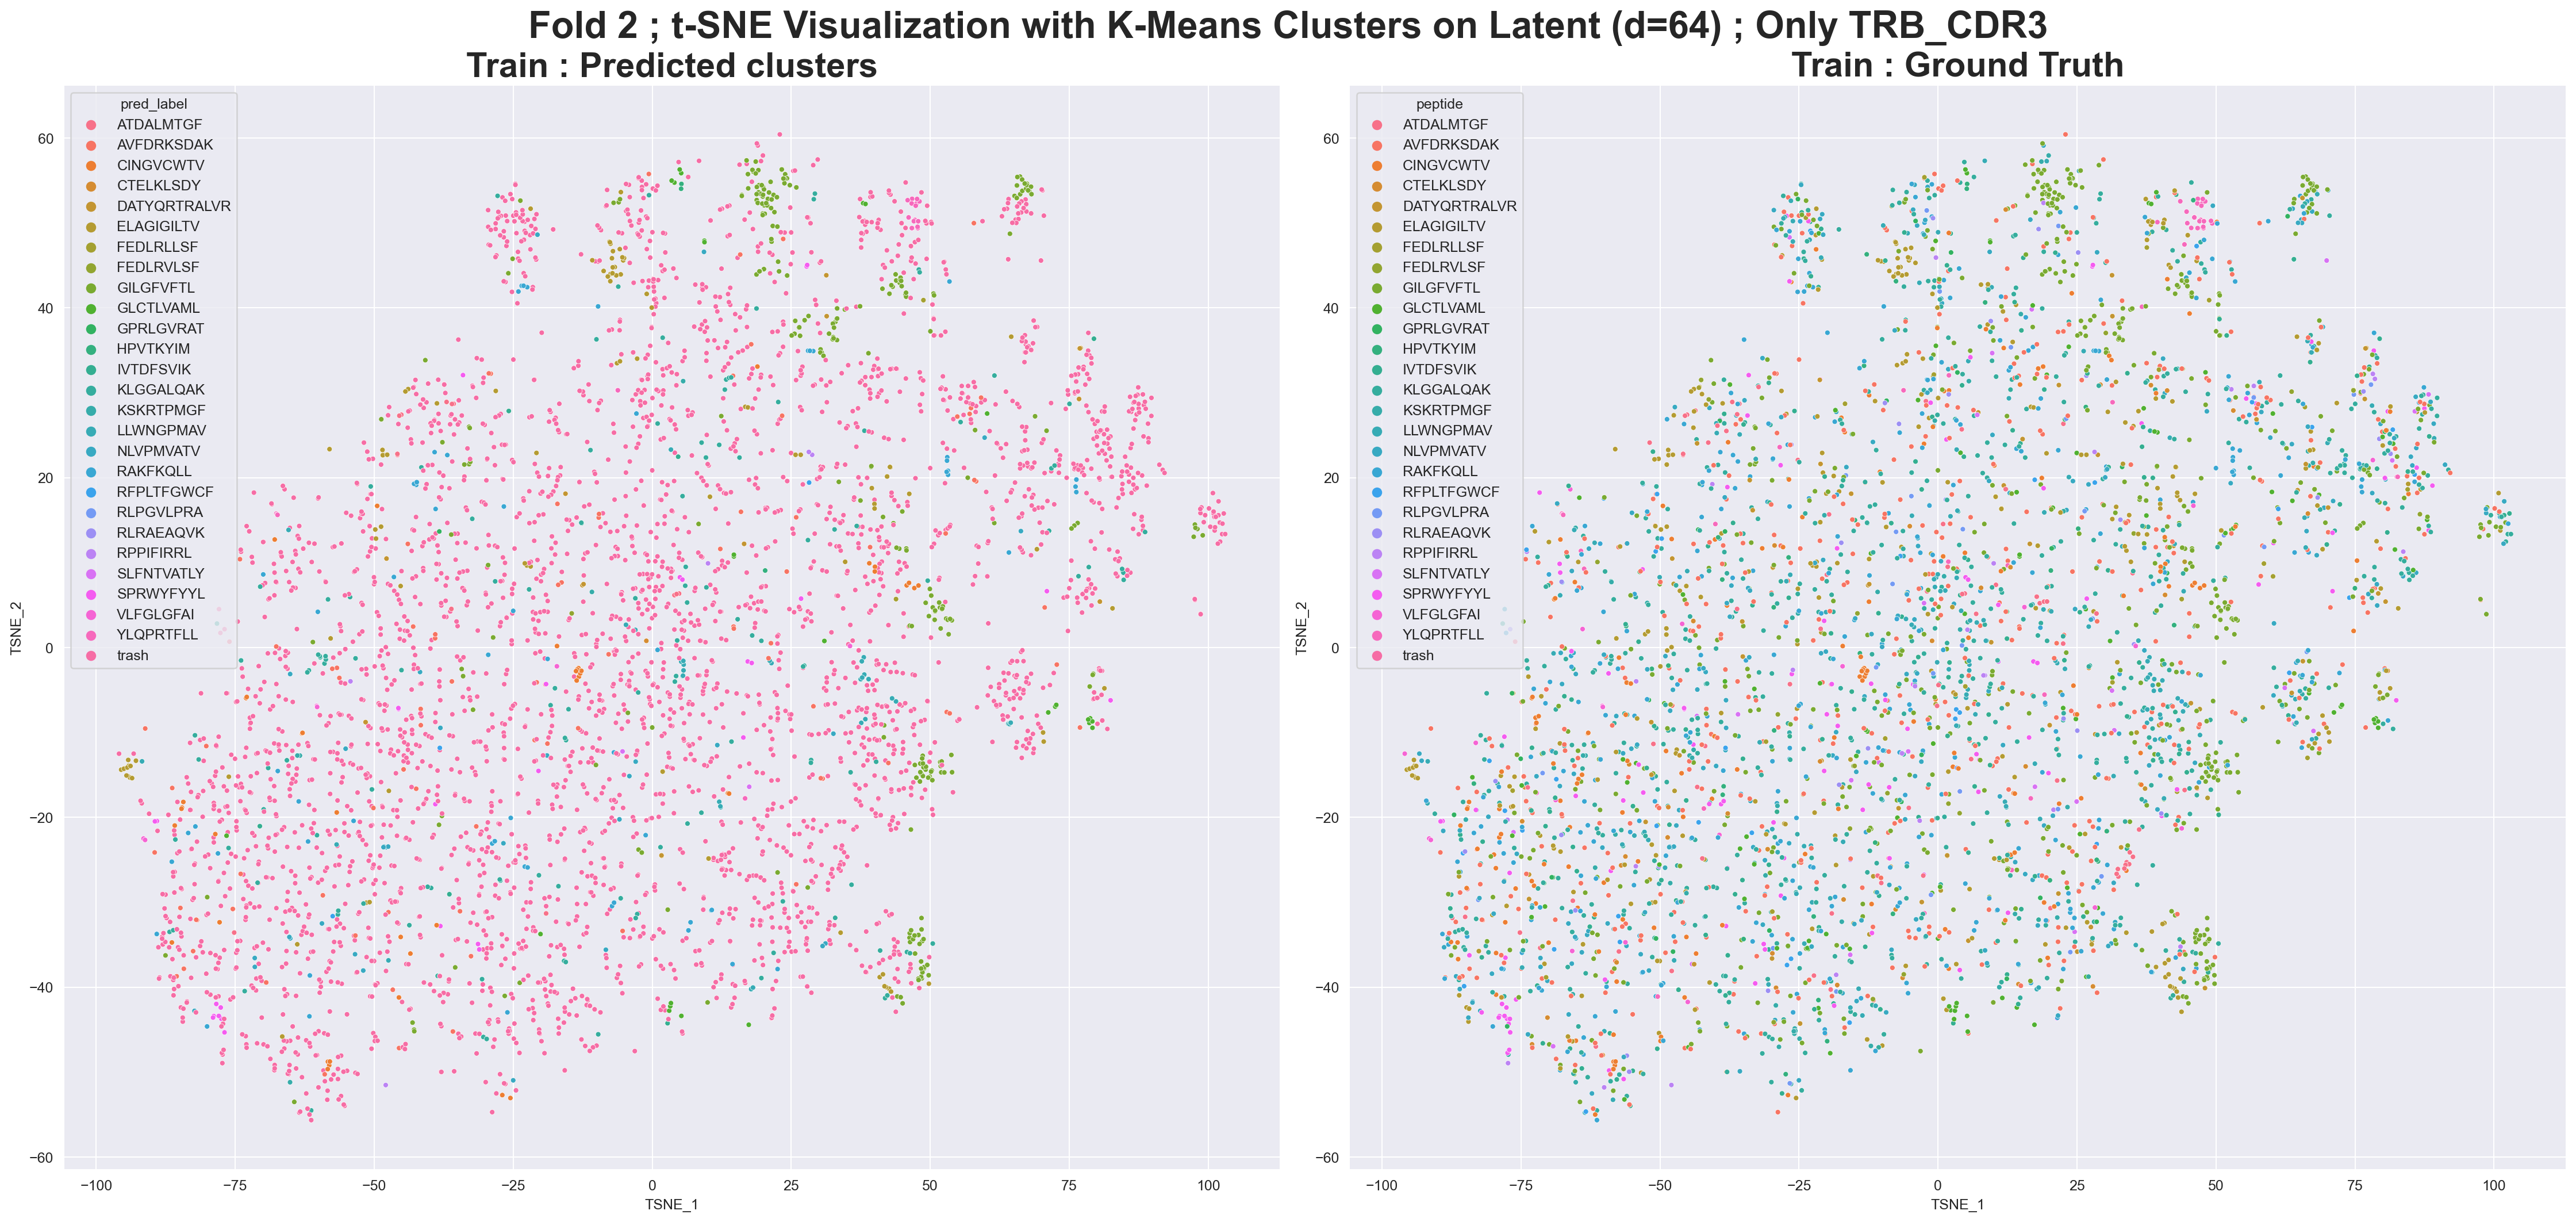

In [801]:
train[['TSNE_1', 'TSNE_2']] = tsne_train
train['pred_label'] = train.apply(lambda x: x['cluster_label'] if x['purity_percent']>=70 else 'trash', axis=1)
f,a = plt.subplots(1,2, figsize=(25,12))
a = a.ravel()

fold=2
pep_order = sorted(df.peptide.unique()) + ['trash']

sns.scatterplot(data=train, #.query('GroundTruth!="immrep_negs"'),
                x='TSNE_1', y='TSNE_2',  s=13, hue='pred_label', hue_order=pep_order, ax = a[0])
sns.scatterplot(data=train, #.query('GroundTruth!="immrep_negs"'), 
                x='TSNE_1', y='TSNE_2',  s=13, hue='peptide', hue_order=pep_order, ax = a[1])

a[0].set_title('Train : Predicted clusters', fontsize=24, fontweight='semibold')
a[1].set_title('Train : Ground Truth', fontsize=24, fontweight='semibold')


f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3', fontsize=26, fontweight='semibold')
f.tight_layout()
f.savefig(f'../output/231006_latent_analysis/231010_TrainNoRep_CompleteLinkage_CosineDist_nc2000_TrainOnly.png', bbox_inches='tight', dpi=200)

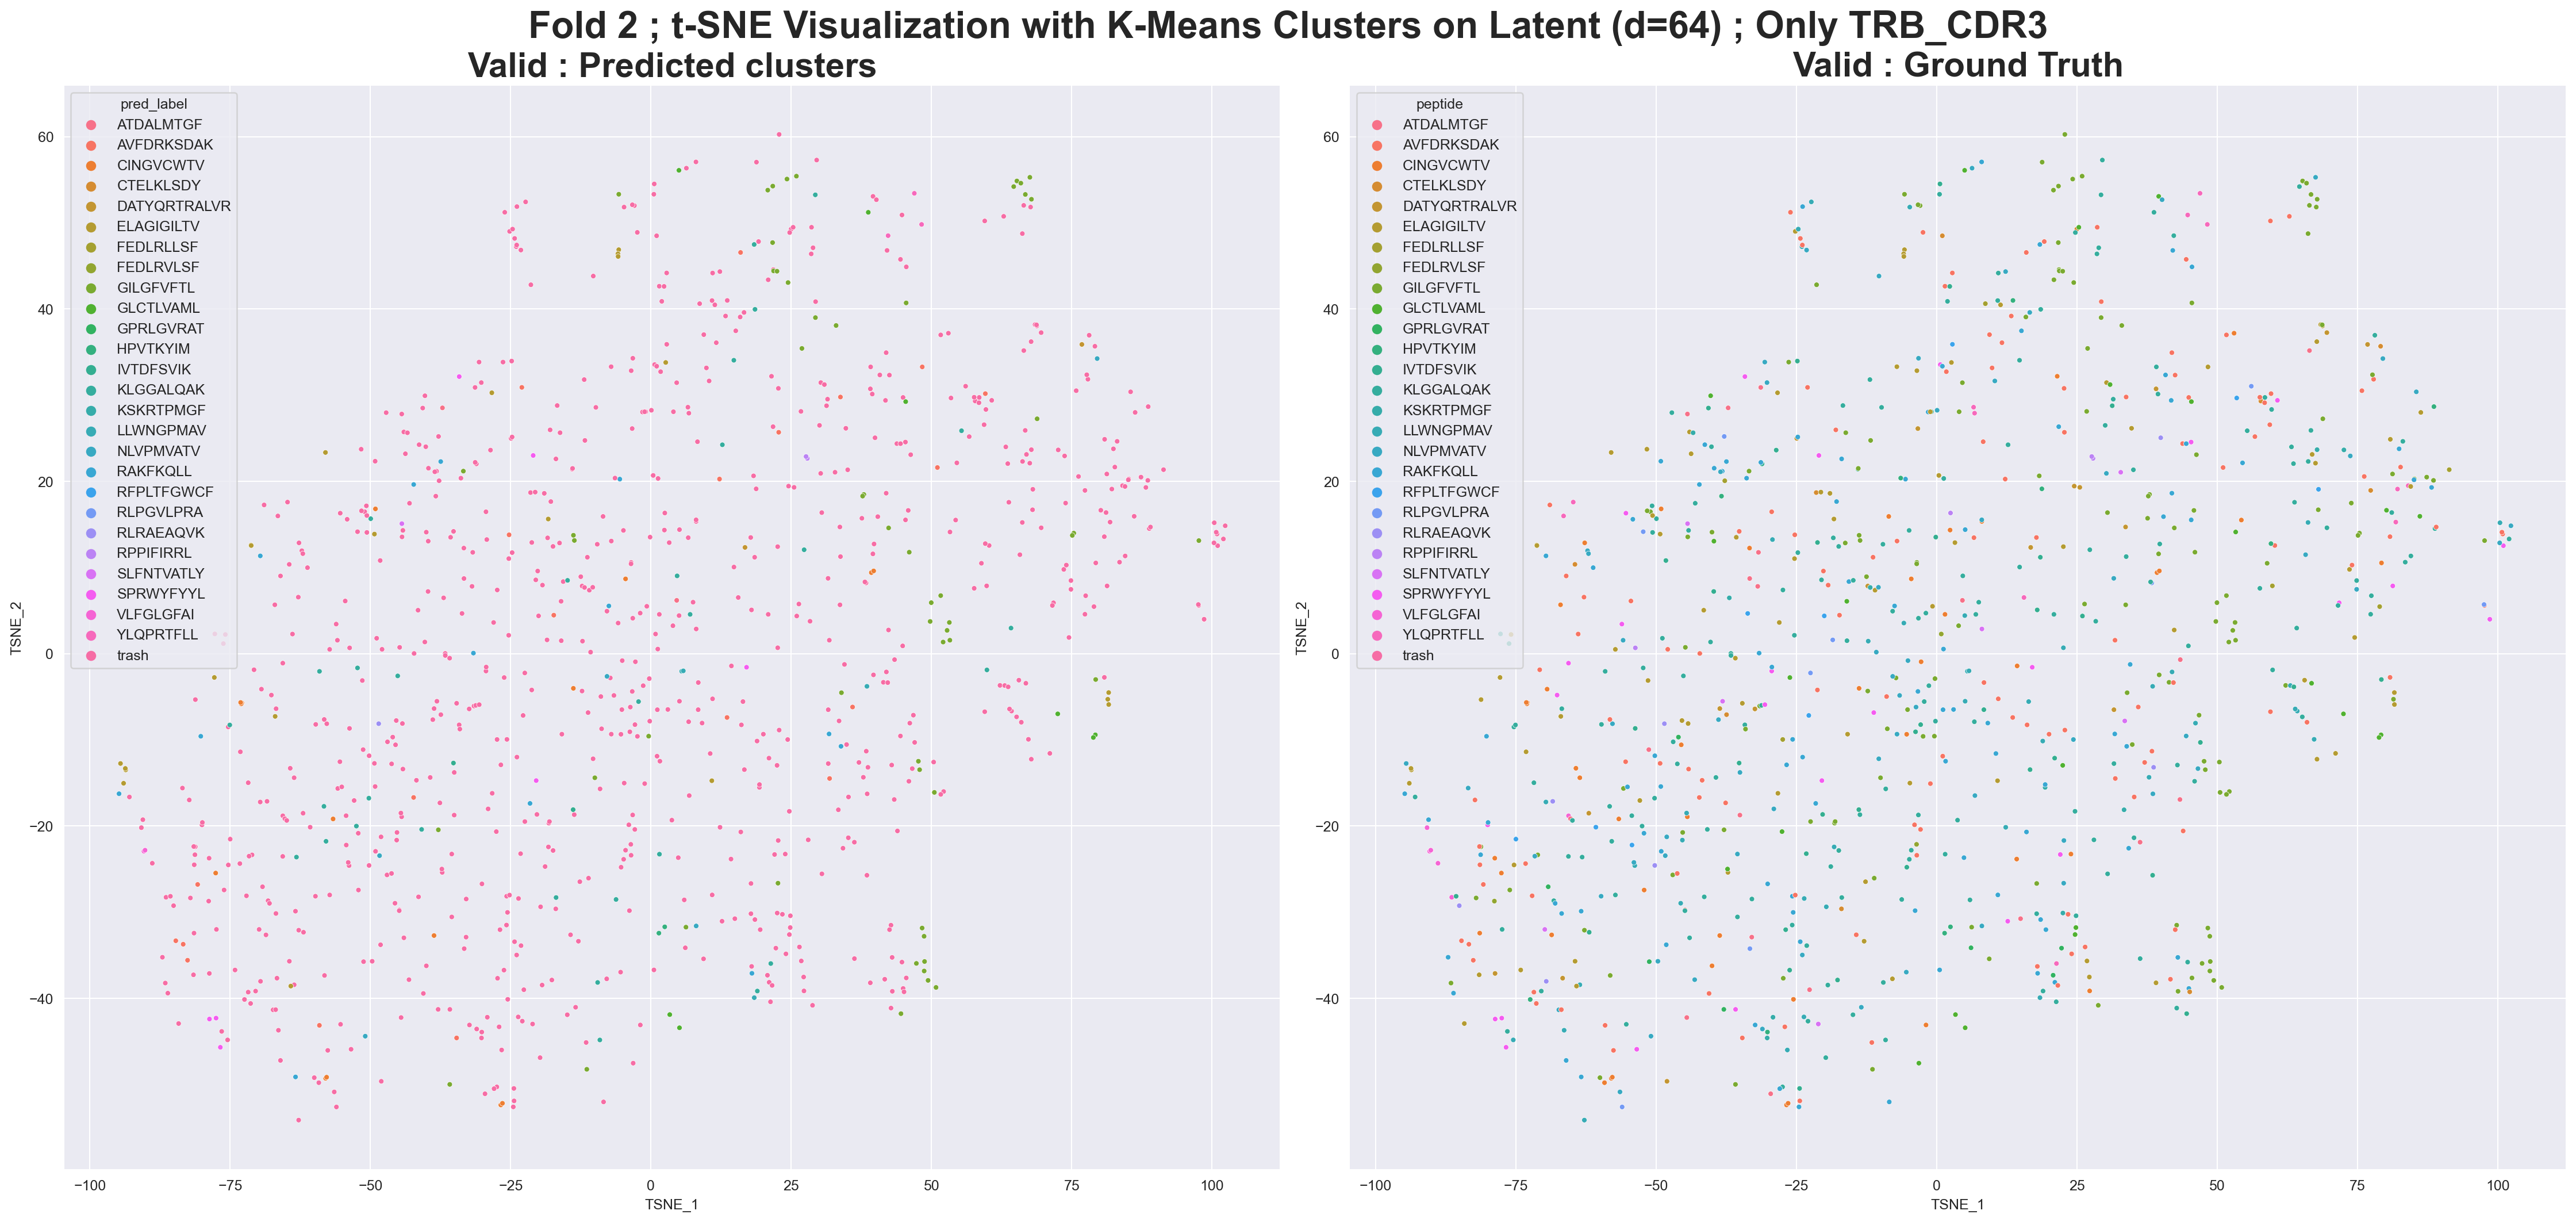

In [802]:
f,a = plt.subplots(1,2, figsize=(25,12))
a = a.ravel()

fold=2
pep_order = sorted(df.peptide.unique()) + ['trash']
valid[['TSNE_1', 'TSNE_2']] = tsne_valid
valid['pred_label'] = valid.apply(lambda x: x['cluster_label'] if x['purity_percent']>=70 else 'trash', axis=1)

sns.scatterplot(data=valid, #.query('GroundTruth!="immrep_negs"'),
                x='TSNE_1', y='TSNE_2',  s=13, hue='pred_label', hue_order=pep_order, ax = a[0])
sns.scatterplot(data=valid, #.query('GroundTruth!="immrep_negs"'), 
                x='TSNE_1', y='TSNE_2',  s=13, hue='peptide', hue_order=pep_order, ax = a[1])

a[0].set_title('Valid : Predicted clusters', fontsize=24, fontweight='semibold')
a[1].set_title('Valid : Ground Truth', fontsize=24, fontweight='semibold')

f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3', fontsize=26, fontweight='semibold')
f.tight_layout()
f.savefig(f'../output/231006_latent_analysis/231010_TrainNoRep_CompleteLinkage_CosineDist_nc2000_ValidOnly.png', bbox_inches='tight', dpi=200)


In [752]:
best_cosine_summary.query('cluster_size>=4 and purity_percent>=75').cluster_size.sum()

435

In [735]:
best_cosine_summary.query('cluster_size>=4 and purity_percent>=75').

Unnamed: 0.1       A1        A2               A3      B1       B2  \
0                0   DRGSQS    IYSNGD       AVNPANARLM  DFQATT  SNEGSKA   
1                1   TSGFNG    NVLDGL         AVGDDKII  DFQATT  SNEGSKA   
2             2532  NIATNDY     GYKTK  LVGDMRSGAGSYQLT  DFQATT  SNEGSKA   
3                2   DRGSQS    IYSNGD       AVTPGTYKYI   LGHDT   YNNKEL   
4              426   YSGSPE      HISR     APPSNTGFQKLV   KGHSH   LQKENI   
...            ...      ...       ...              ...     ...      ...   
5173          5109    VGISA     LSSGK    AVGKSYNQGGKLI   LGHNA   YSLEER   
5174          5120   SSVSVY  YLSGSTLV       AVTLSGGKLI   MGHRA   YSYEKL   
5175          5133   NSASDY   IRSNMDK      ADSGGGADGLT   SGHRS   YFSETQ   
5176          5142   DSSSTY   IFSNMDM      AEMEGGSYIPT   SGHDT   YYEEEE   
5177          5161   SSNFYA   MTLNGDE       ACPPGDYKLS   SGHVS   FQNEAQ   

                   B3  binder     peptide original_peptide         TRAV  \
0        SARWGGGTDTQY       1  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01   
1       SARGLDRGTNEQY       1  AVFDRKSDAK       AVFDRKSDAK   TRAV1-2*01   
2       SARDINRGSYEQY       1  AVFDRKSDAK       AVFDRKSDAK     TRAV4*01   
3      ASSPGTSIFVAEQY       1  ELAGIGILTV       ELAGIGILTV  TRAV12-2*01   
4      ASSPWTGTLNTEAF       1   NLVPMVATV        NLVPMVATV    TRAV16*01   
...               ...     ...         ...              ...          ...   
5173  ASSQALAGRGDNEQF       1   KLGGALQAK        KLGGALQAK    TRAV41*01   
5174   ASSGSLGRDQETQY       1   KLGGALQAK        KLGGALQAK   TRAV8-6*01   
5175   ASSFFTRGGEDEQY       1    RAKFKQLL         RAKFKQLL  TRAV13-2*01   
5176    ASSLVGAPRREQY       1    RAKFKQLL         RAKFKQLL     TRAV5*01   
5177    ASSLDIPSYNEQF       1   NLVPMVATV        NLVPMVATV    TRAV24*01   

           TRAJ         TRBV        TRBJ  partition  Unnamed: 0       allele  \
0     TRAJ31*01  TRBV20-1*01  TRBJ2-3*01          3     37123.0  HLA-A*02:01   
1     TRAJ30*01  TRBV20-1*01  TRBJ2-7*01          3     14961.0  HLA-A*11:01   
2     TRAJ28*01  TRBV20-1*01  TRBJ2-7*01          0      9693.0  HLA-A*11:01   
3     TRAJ40*01   TRBV3-1*01  TRBJ2-7*01          0      8197.0  HLA-A*02:01   
4      TRAJ8*01    TRBV18*01  TRBJ1-1*01          0     37188.0  HLA-A*02:01   
...         ...          ...         ...        ...         ...          ...   
5173  TRAJ23*01   TRBV4-3*01  TRBJ2-1*01          2     24195.0  HLA-A*03:01   
5174  TRAJ23*01   TRBV4-1*01  TRBJ2-5*01          2     19206.0  HLA-A*03:01   
5175  TRAJ45*01   TRBV5-1*01  TRBJ2-7*01          2     31050.0  HLA-B*08:01   
5176   TRAJ6*01   TRBV5-6*01  TRBJ2-7*01          2     35488.0  HLA-B*08:01   
5177  TRAJ20*01   TRBV7-8*01  TRBJ2-1*01          2     33740.0  HLA-A*02:01   

     origin  original_index TRBV_gene TRBJ_gene           TRA_CDR3  \
0       10x          3820.0  TRBV20-1   TRBJ2-3       CAVNPANARLMF   
1       10x          3592.0  TRBV20-1   TRBJ2-7         CAVGDDKIIF   
2       10x          5594.0  TRBV20-1   TRBJ2-7  CLVGDMRSGAGSYQLTF   
3       10x          5933.0   TRBV3-1   TRBJ2-7       CAVTPGTYKYIF   
4     VDJdb          5489.0    TRBV18   TRBJ1-1     CAPPSNTGFQKLVF   
...     ...             ...       ...       ...                ...   
5173    10x           369.0   TRBV4-3   TRBJ2-1    CAVGKSYNQGGKLIF   
5174    10x          5646.0   TRBV4-1   TRBJ2-5       CAVTLSGGKLIF   
5175    10x          1491.0   TRBV5-1   TRBJ2-7      CADSGGGADGLTF   
5176    10x          5569.0   TRBV5-6   TRBJ2-7      CAEMEGGSYIPTF   
5177  VDJdb          1307.0   TRBV7-8   TRBJ2-1       CACPPGDYKLSF   

               TRB_CDR3 reassigned_label  len  seq_acc  \
0        CSARWGGGTDTQYF       ELAGIGILTV   14      1.0   
1       CSARGLDRGTNEQYF       AVFDRKSDAK   15      1.0   
2       CSARDINRGSYEQYF       AVFDRKSDAK   15      1.0   
3      CASSPGTSIFVAEQYF       ELAGIGILTV   16      1.0   
4      CASSPWTGTLNTEAFF        NLVPMVATV   16      1.0   
...                 ...              ...  ...      ...

TSNE


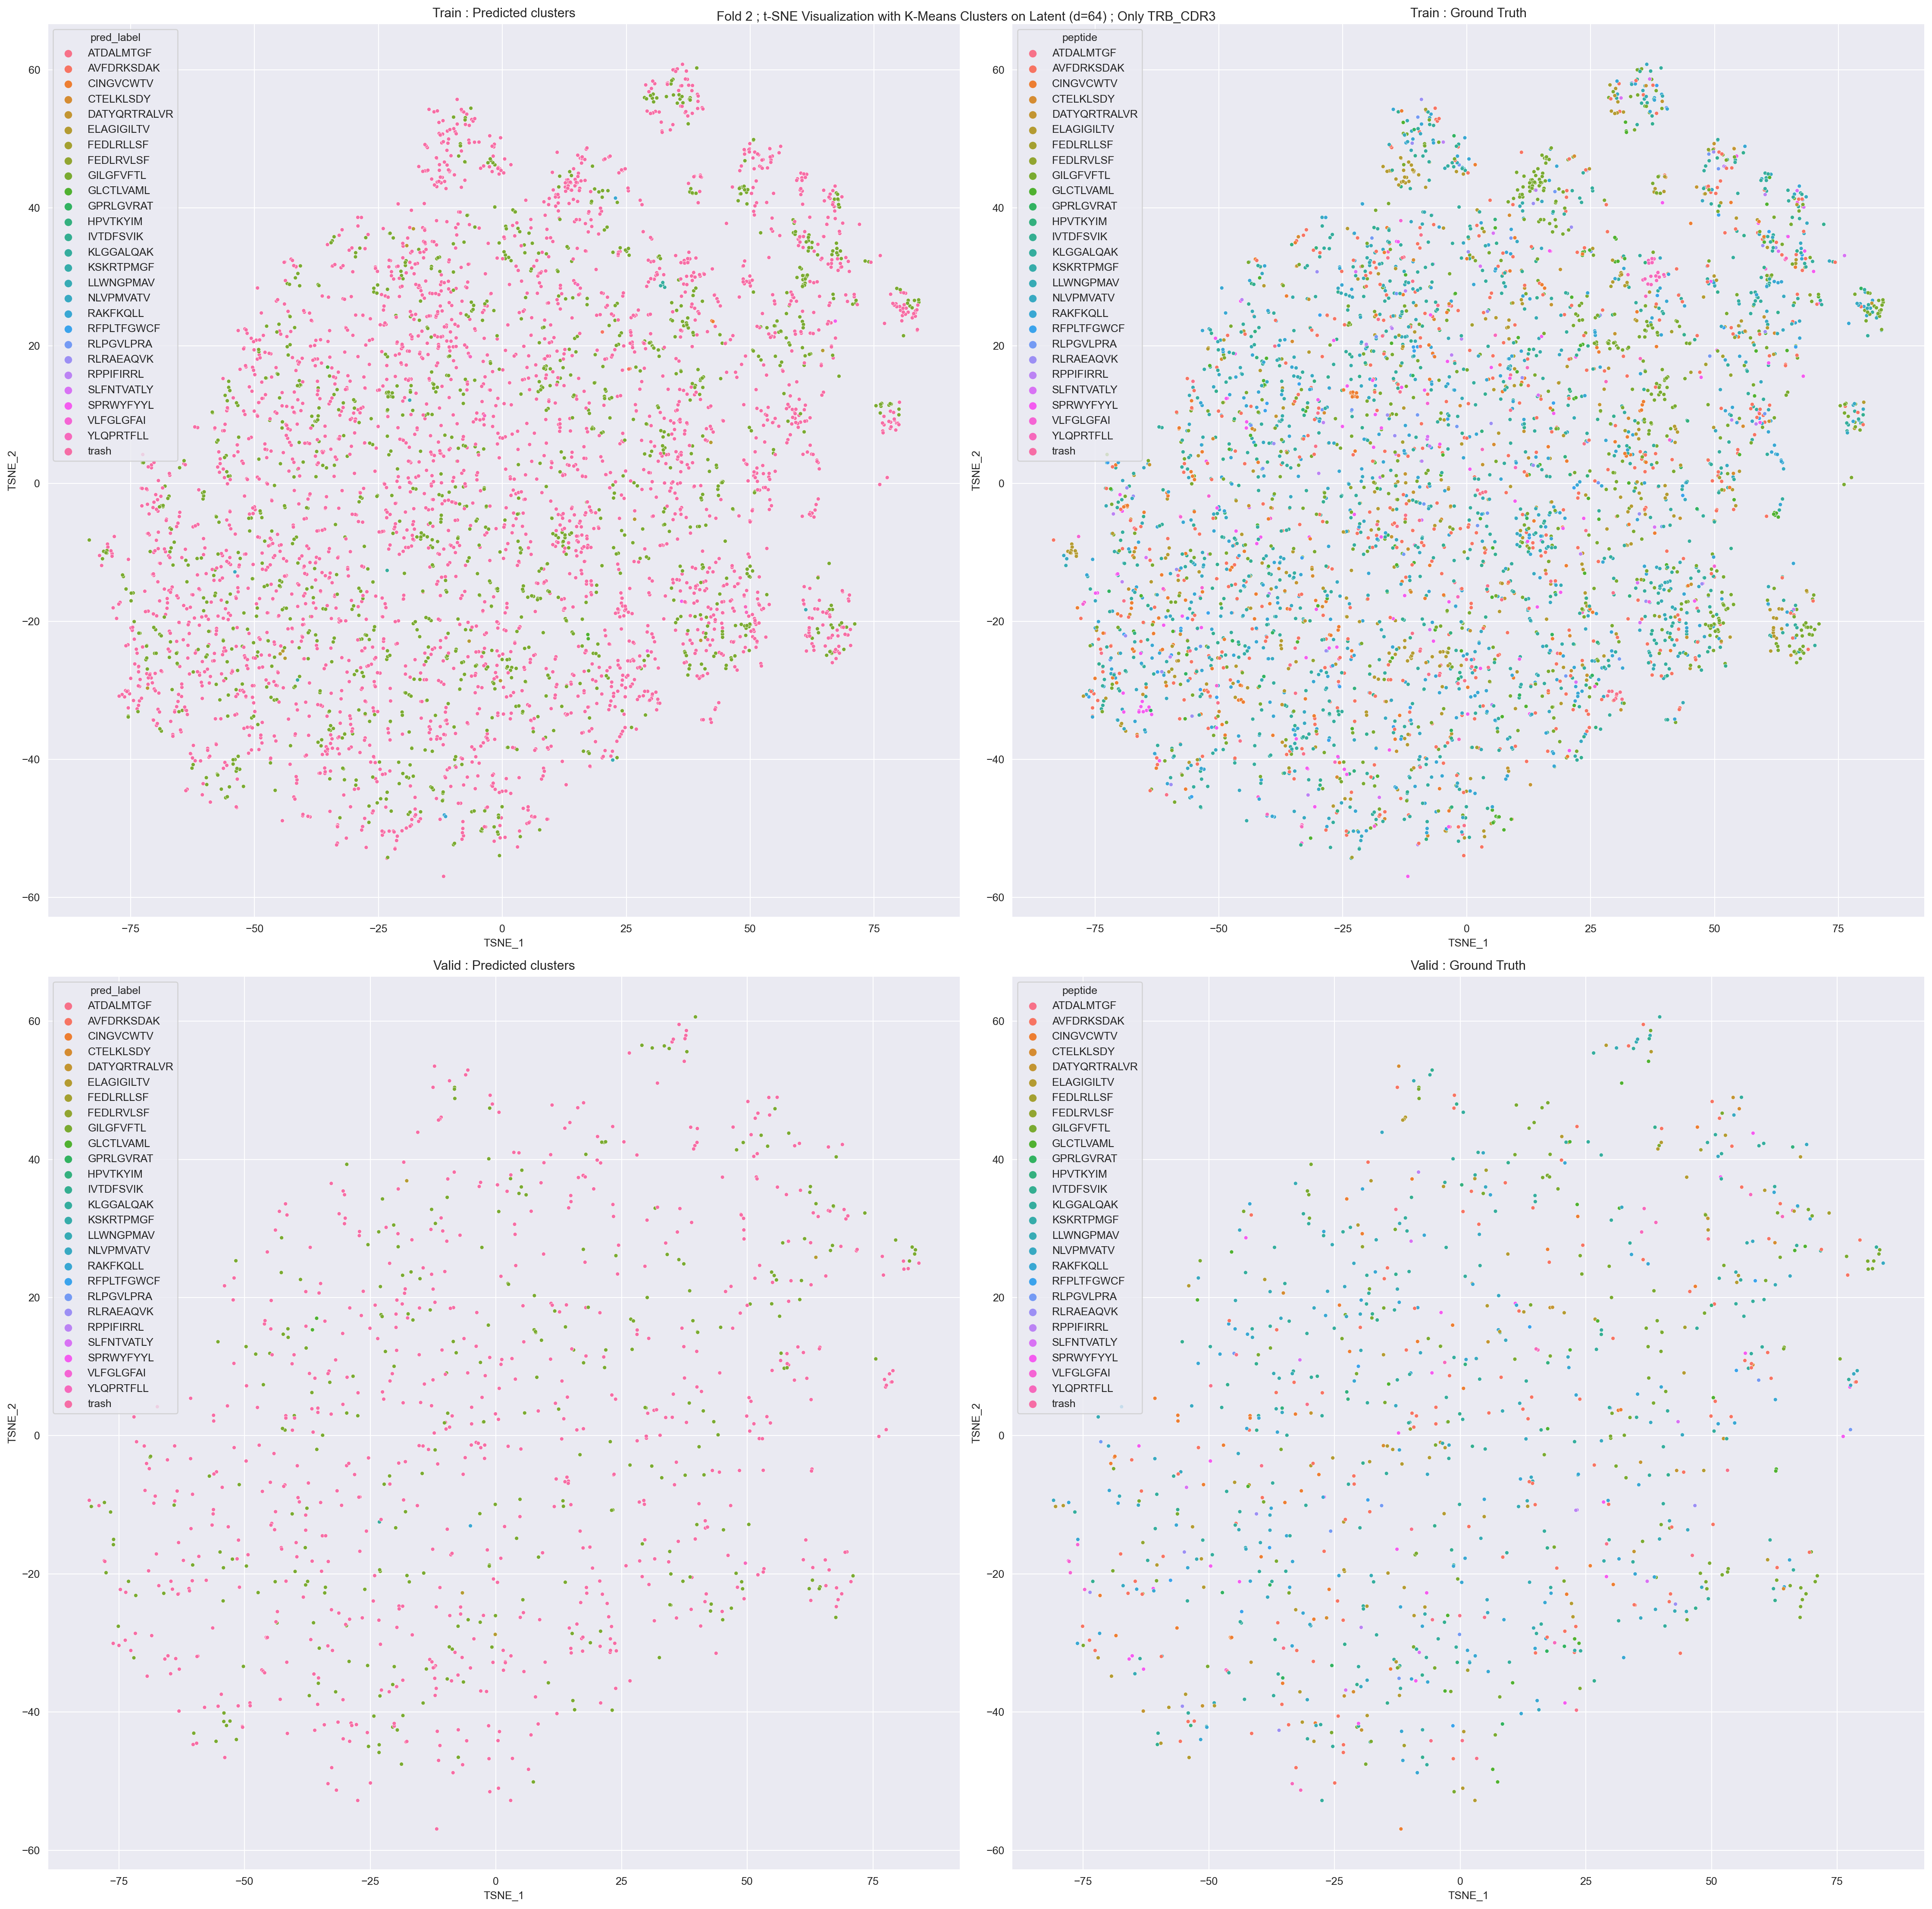

In [734]:
from sklearn.manifold import TSNE
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=26)
sns.set_palette(palette)
best_cosine_agdf.reset_index(drop=True)

top_percent
train = best_cosine_agdf.query('partition!=2')
valid = best_cosine_agdf.query('partition==2')
latent_dim = 64
z_train = train[[f'z_{i}' for i in range(latent_dim)]].values
labels_train = train['peptide'].values
z_valid = valid[[f'z_{i}' for i in range(latent_dim)]].values
labels_valid = valid['peptide'].values

print('TSNE')
tsne = TSNE(n_components=2, metric='cosine', perplexity=25)
# tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')

latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
train[['TSNE_1', 'TSNE_2']] = tsne_train
valid[['TSNE_1', 'TSNE_2']] = tsne_valid

train['pred_label'] = train.apply(lambda x: x['cluster_label'] if x['purity_percent']>=70 else 'trash', axis=1)
valid['pred_label'] = valid.apply(lambda x: x['cluster_label'] if x['purity_percent']>=70 else 'trash', axis=1)
from src.utils import get_palette
f,a = plt.subplots(2,2, figsize=(25,25))
a = a.ravel()

fold=2
pep_order = sorted(df.peptide.unique()) + ['trash']

sns.scatterplot(data=train, #.query('GroundTruth!="immrep_negs"'),
                x='TSNE_1', y='TSNE_2',  s=13, hue='pred_label', hue_order=pep_order, ax = a[0])
sns.scatterplot(data=train, #.query('GroundTruth!="immrep_negs"'), 
                x='TSNE_1', y='TSNE_2',  s=13, hue='peptide', hue_order=pep_order, ax = a[1])
sns.scatterplot(data=valid, #.query('GroundTruth!="immrep_negs"'), 
                x='TSNE_1', y='TSNE_2',  s=13, hue='pred_label', hue_order=pep_order, ax = a[2])
sns.scatterplot(data=valid, #.query('GroundTruth!="immrep_negs"'), 
                x='TSNE_1', y='TSNE_2',  s=13, hue='peptide', hue_order=pep_order, ax = a[3])
a[0].set_title('Train : Predicted clusters')
a[1].set_title('Train : Ground Truth')
a[2].set_title('Valid : Predicted clusters')
a[3].set_title('Valid : Ground Truth')
f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
f.tight_layout()
f.savefig(f'../output/231006_latent_analysis/231010_TrainNoRep_CompleteLinkage_CosineDist_nc2000_TrainOnly.png', bbox_inches='tight', dpi=200)

# Comparison to TCRBase

In [1060]:
tcrbase_results = pd.read_csv('../data/baselines/231010_TCRbase_results_redone_only_cdr3b.csv')

In [1058]:
# Get tab separated A1 to B3
cat_norep.query('set == "train" and peptide=="GILGFVFTL"')[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'peptide']].to_csv('../data/baselines/231010_TCRbase_fold2_database.tsv', sep = '\t', header=False, index=False)
cat_norep.query('set == "valid"')[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'peptide']].to_csv('../data/baselines/231010_TCRbase_fold2_query.tsv', sep = '\t', header=False, index=False)

# Redo with only cdr3
cdr3_copy = cat_norep[['A1', 'A2', 'A3', 'B1', 'B2', 'B3','TRA_CDR3', 'TRB_CDR3', 'peptide', 'set']].copy()
cdr3_copy['A1'] = 'XXXXX'
cdr3_copy['B1'] = 'XXXXX'
cdr3_copy['A2'] = 'XXXXX'
cdr3_copy['B2'] = 'XXXXX'
# cdr3_copy['A3'] = 'XXXXX'

cdr3_copy.query('set == "train" and peptide=="GILGFVFTL"')[['A1','B1', 'A2', 'B2', 'TRA_CDR3', 'TRB_CDR3', 'peptide']].to_csv('../data/baselines/231010_TCRbase_CDR3_ONLY_fold2_database.tsv',
                                                                                                                              sep = '\t', header=False, index=False)
cdr3_copy.query('set == "valid"')[['A1','B1', 'A2', 'B2', 'TRA_CDR3', 'TRB_CDR3', 'peptide']].to_csv('../data/baselines/231010_TCRbase_CDR3_ONLY_fold2_query.tsv',
                                                                                                     sep = '\t', header=False, index=False)

In [902]:
def get_tcrbase_method(tcr, ref):
    # here take the top1 instead of percent
    best = ref[tcr].sort_values().head(1)
    best_name = best.index[0]
    best_sim = best.item()
    label = ref.loc[best_name]['labels']
    return similar_label, best_name, best_sim

In [990]:
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns', 10)

In [1027]:
lev_baseline = pd.read_csv('../data/baselines/231005_nettcr_pos_unique_levenshtein_matrix.csv', index_col=0)

In [1029]:
lev_valid_gils = lev_baseline.loc[valid_gils.index]
lev_valid_notgils = lev_baseline.loc[valid_notgils.index]
lev_train_set = lev_baseline.loc[train_set.index]

In [1030]:
train_set_gil_ref = train_set.query('labels=="GILGFVFTL"')
lev_train_set_gil_ref = lev_train_set.query('labels=="GILGFVFTL"')
dissim_train_set_gil_ref = dissim_train_set.query('labels=="GILGFVFTL"')

In [1031]:
# running this analysis for the baseline (dissimilarity matrix)
tcrbase_dissim_valid_sims = dissim_valid_gils.drop(columns=[x for x in dissim_valid_gils.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
tcrbase_dissim_valid_sims[['similar_label', 'best_name', 'best_sim']] = tcrbase_dissim_valid_sims.apply(lambda x: get_tcrbase_method(x['CDR3b'], ref=dissim_train_set_gil_ref), axis=1, result_type='expand')
tcrbase_dissim_valid_notsims = dissim_valid_notgils.drop(columns=[x for x in dissim_valid_notgils.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
tcrbase_dissim_valid_notsims[['similar_label', 'best_name', 'best_sim']] = tcrbase_dissim_valid_notsims.apply(lambda x: get_tcrbase_method(x['CDR3b'], ref=dissim_train_set_gil_ref), axis=1, result_type='expand')

# Running analysis for valid cosine matrix
tcrbase_valid_sims = valid_gils.drop(columns=[x for x in valid_gils.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
tcrbase_valid_sims[['similar_label', 'best_name', 'best_sim']] = tcrbase_valid_sims.apply(lambda x: get_tcrbase_method(x['CDR3b'], ref=train_set_gil_ref), axis=1, result_type='expand')
tcrbase_valid_notsims = valid_notgils.drop(columns=[x for x in valid_notgils.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
tcrbase_valid_notsims[['similar_label', 'best_name', 'best_sim']] = tcrbase_valid_notsims.apply(lambda x: get_tcrbase_method(x['CDR3b'], ref=train_set_gil_ref), axis=1, result_type='expand')

# Running the same for Levenshtein matrix
lev_tcrbase_valid_sims = lev_valid_gils.drop(columns=[x for x in lev_valid_gils.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
lev_tcrbase_valid_sims[['similar_label', 'best_name', 'best_sim']] = lev_tcrbase_valid_sims.apply(lambda x: get_tcrbase_method(x['CDR3b'], ref=lev_train_set_gil_ref), axis=1, result_type='expand')
lev_tcrbase_valid_notsims = lev_valid_notgils.drop(columns=[x for x in lev_valid_notgils.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
lev_tcrbase_valid_notsims[['similar_label', 'best_name', 'best_sim']] = lev_tcrbase_valid_notsims.apply(lambda x: get_tcrbase_method(x['CDR3b'], ref=lev_train_set_gil_ref), axis=1, result_type='expand')


In [1032]:
tcrbase_dissim_valid_sims['score'] = 1 - tcrbase_dissim_valid_sims['best_sim']
tcrbase_dissim_valid_sims['y_true'] = (tcrbase_dissim_valid_sims['true_label'] == "GILGFVFTL").astype(int)

tcrbase_dissim_valid_notsims['score'] = 1 - tcrbase_dissim_valid_notsims['best_sim']
tcrbase_dissim_valid_notsims['y_true'] = (tcrbase_dissim_valid_notsims['true_label'] == "GILGFVFTL").astype(int)

tcrbase_valid_sims['score'] = 1 - tcrbase_valid_sims['best_sim']
tcrbase_valid_sims['y_true'] = (tcrbase_valid_sims['true_label'] == "GILGFVFTL").astype(int)

tcrbase_valid_notsims['score'] = 1 - tcrbase_valid_notsims['best_sim']
tcrbase_valid_notsims['y_true'] = (tcrbase_valid_notsims['true_label'] == "GILGFVFTL").astype(int)


lev_tcrbase_valid_sims['score'] = 1 - lev_tcrbase_valid_sims['best_sim']
lev_tcrbase_valid_sims['y_true'] = (lev_tcrbase_valid_sims['true_label'] == "GILGFVFTL").astype(int)

lev_tcrbase_valid_notsims['score'] = 1 - lev_tcrbase_valid_notsims['best_sim']
lev_tcrbase_valid_notsims['y_true'] = (lev_tcrbase_valid_notsims['true_label'] == "GILGFVFTL").astype(int)


tcrbase_dissim_concat = pd.concat([tcrbase_dissim_valid_sims, tcrbase_dissim_valid_notsims])
tcrbase_cosine_concat = pd.concat([tcrbase_valid_sims, tcrbase_valid_notsims])
tcrbase_lev_concat = pd.concat([lev_tcrbase_valid_sims, lev_tcrbase_valid_notsims])


In [1061]:
tcrbase_results = pd.read_csv('../data/baselines/231010_TCRbase_results_redone_only_cdr3b.csv')
tcrbase_results_query_idx = tcrbase_results.set_index(['A1', 'A2', 'A3', 'B1', 'B2', 'B3']).index
tcrbase_results['true_label'] = cat_norep.set_index(['A1', 'A2', 'A3', 'B1', 'B2', 'B3']).loc[tcrbase_results_query_idx]['peptide'].values
tcrbase_results['y_true'] = (tcrbase_results['true_label'] == 'GILGFVFTL').astype(int)
tcrbase_results['score'] = tcrbase_results['Prediction']

In [1062]:
print('Comparison of the TCRbase method using various distance matrices ...')
print(f"Using dissimilarity matrix:\tAUC={roc_auc_score(tcrbase_dissim_concat['y_true'], tcrbase_dissim_concat['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_dissim_concat['y_true'], tcrbase_dissim_concat['score'], max_fpr=0.1):.2%}")

print(f"Using Levenshtein matrix:\tAUC={roc_auc_score(tcrbase_lev_concat['y_true'], tcrbase_lev_concat['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_lev_concat['y_true'], tcrbase_lev_concat['score'], max_fpr=0.1):.2%}")

print(f"Using LatCos_dist matrix:\tAUC={roc_auc_score(tcrbase_cosine_concat['y_true'], tcrbase_cosine_concat['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_cosine_concat['y_true'], tcrbase_cosine_concat['score'], max_fpr=0.1):.2%}")

print(f"Using TCRbase netserver:\tAUC={roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score'], max_fpr=0.1):.2%}")

Comparison of the TCRbase method using various distance matrices ...
Using dissimilarity matrix:	AUC=74.57%,	AUC01=67.12%
Using Levenshtein matrix:	AUC=71.37%,	AUC01=64.53%
Using LatCos_dist matrix:	AUC=71.89%,	AUC01=64.31%
Using TCRbase netserver:	AUC=74.43%,	AUC01=66.98%


In [1042]:
pd.read_csv('..a/data/231006_latent_dists/231006_dist_correlation_cat_norep.csv', nrows=5)

Unnamed: 0  CSARWGGGTDTQYF  CSARGLDRGTNEQYF  CASSPGTSIFVAEQYF  \
0    CSARWGGGTDTQYF        0.000000         0.678539          1.194548   
1   CSARGLDRGTNEQYF        0.678539         0.000000          0.956934   
2  CASSPGTSIFVAEQYF        1.194548         0.956934          0.000000   
3    CASSPGSRGNIQYF        0.925654         0.744224          0.563236   
4   CASSATGTHSFGYTF        1.020533         0.879121          0.879207   

   CASSPGSRGNIQYF  ...  CSVTPPGGLGYF  CASRTGPGPYNEQFF      labels        ids  \
0        0.925654  ...      0.831364         0.718447  ELAGIGILTV  seq_00000   
1        0.744224  ...      1.112522         0.761538  AVFDRKSDAK  seq_00001   
2        0.563236  ...      1.071816         0.943811  ELAGIGILTV  seq_00002   
3        0.000000  ...      1.016075         0.968203    RAKFKQLL  seq_00003   
4        0.884046  ...      0.853072         1.331772  ELAGIGILTV  seq_00004   

     set  
0  train  
1  train  
2  train  
3  train  
4  train  

[5 rows x 9917 columns]

In [1050]:
# Time to do the same for ALL the distance matrices and see if any of them performs 
latdir = '../data/231006_latent_dists/'
files = sorted([f'{latdir}{x}' for x in os.listdir(latdir)])
print('Comparison of the TCRbase method (query most similar) using various distance matrices ...')
for f in files:
    distance_matrix = pd.read_csv(f, index_col=0)
    train_ref = distance_matrix.query('set=="train" and labels=="GILGFVFTL"')
    valid_query = distance_matrix.query('set=="valid"')
    del distance_matrix
    valid_query = valid_query.drop(columns=[x for x in valid_query.columns if x != 'labels']).copy().reset_index().rename(columns={'index':'CDR3b', 'labels':'true_label'})
    valid_query[['similar_label', 'best_name', 'best_sim']] = valid_query.apply(lambda x: get_tcrbase_method(x['CDR3b'], ref=train_ref), axis=1, result_type='expand')
    valid_query['y_true'] = (valid_query['true_label']=="GILGFVFTL").astype(int)
    if 'kernel' not in f:
        valid_query['score'] = 1 - valid_query['best_sim']
    else:
        valid_query['score'] = valid_query['best_sim']
    print(f"Using {os.path.basename(f).replace('.csv', '').replace('_cat_','').replace('231006_','')} matrix:\tAUC={roc_auc_score(valid_query['y_true'], valid_query['score']):.2%},"
      f"\tAUC01={roc_auc_score(valid_query['y_true'], valid_query['score'], max_fpr=0.1):.2%}")

print(f"Using dissimilarity matrix:\tAUC={roc_auc_score(tcrbase_dissim_concat['y_true'], tcrbase_dissim_concat['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_dissim_concat['y_true'], tcrbase_dissim_concat['score'], max_fpr=0.1):.2%}")

print(f"Using Levenshtein matrix:\tAUC={roc_auc_score(tcrbase_lev_concat['y_true'], tcrbase_lev_concat['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_lev_concat['y_true'], tcrbase_lev_concat['score'], max_fpr=0.1):.2%}")

print(f"Using TCRbase netserver:\tAUC={roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score'], max_fpr=0.1):.2%}")

Comparison of the TCRbase method (query most similar) using various distance matrices ...
Using dist_correlationnorep matrix:	AUC=71.68%,	AUC01=64.50%
Using dist_correlationrepam matrix:	AUC=64.10%,	AUC01=56.44%
Using dist_cosinenorep matrix:	AUC=71.89%,	AUC01=64.31%
Using dist_cosinerepam matrix:	AUC=64.26%,	AUC01=56.36%
Using dist_euclideannorep matrix:	AUC=73.62%,	AUC01=65.17%
Using dist_euclideanrepam matrix:	AUC=67.52%,	AUC01=59.57%
Using dist_hammingnorep matrix:	AUC=50.00%,	AUC01=50.00%
Using dist_hammingrepam matrix:	AUC=50.00%,	AUC01=50.00%
Using dist_jaccardnorep matrix:	AUC=50.00%,	AUC01=50.00%
Using dist_jaccardrepam matrix:	AUC=50.00%,	AUC01=50.00%
Using dist_manhattannorep matrix:	AUC=74.64%,	AUC01=66.76%
Using dist_manhattanrepam matrix:	AUC=68.98%,	AUC01=61.86%
Using kernel_cosinenorep matrix:	AUC=52.92%,	AUC01=50.19%
Using kernel_cosinerepam matrix:	AUC=52.60%,	AUC01=49.66%
Using kernel_laplaciannorep matrix:	AUC=59.02%,	AUC01=53.14%
Using kernel_laplacianrepam matrix:

In [1063]:
print(f"Using TCRbase (only cdr3b):\tAUC={roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score']):.2%},"
      f"\tAUC01={roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score'], max_fpr=0.1):.2%}")

Using TCRbase (only cdr3b):	AUC=74.43%,	AUC01=66.98%


# Other stuff

In [489]:
gliph_summary.groupby('labels').agg(mean_purity=('purity_percent', 'mean'), total_size = ('cluster_size', 'sum'), avg_size = ('cluster_size', 'mean'), n_cluster=('index', 'count'))

mean_purity  total_size  avg_size  n_cluster
labels                                                    
ATDALMTGF       87.500000          23  2.875000          8
AVFDRKSDAK      52.992832         212  2.279570         93
CINGVCWTV       83.333333          51  2.125000         24
CTELKLSDY       58.333333           9  2.250000          4
DATYQRTRALVR    61.309524          34  2.428571         14
ELAGIGILTV      79.014550         190  2.638889         72
FEDLRLLSF      100.000000           2  2.000000          1
FEDLRVLSF       66.666667           5  2.500000          2
GILGFVFTL       89.460270         847  3.429150        247
GLCTLVAML       80.277778          60  2.500000         24
GPRLGVRAT      100.000000           2  2.000000          1
HPVTKYIM        50.000000           2  2.000000          1
IVTDFSVIK       47.435897          28  2.153846         13
KLGGALQAK       64.186992          92  2.243902         41
KSKRTPMGF       85.185185          20  2.222222          9
LLWNGPMAV       85.277778          67  2.233333         30
NLVPMVATV       71.354167          36  2.250000         16
RAKFKQLL        77.272727          22  2.000000         11
RFPLTFGWCF     100.000000           4  2.000000          2
RLRAEAQVK       50.000000           2  2.000000          1
RPPIFIRRL      100.000000           2  2.000000          1
SPRWYFYYL       88.888889           7  2.333333          3
VLFGLGFAI      100.000000           2  2.000000          1
YLQPRTFLL      100.000000          42  2.625000         16

In [151]:
def top_n(df, n=25):
    return df.sort_values(['cluster_size', 'purity_percent'], ascending=False).head(n)[['pred_cluster', 'labels','purity_percent', 'cluster_size']]
pd.set_option('display.max_rows',999)
summaries.query('not train_only and not reparameterize').groupby(['linkage','metric']).apply(top_n).head(500)

pred_cluster      labels  purity_percent  \
linkage  metric                                                            
average  dist_correlation 481            481   GILGFVFTL       46.428571   
                          914            914   GILGFVFTL       68.627451   
                          274            274   GILGFVFTL       87.234043   
                          439            439   GILGFVFTL       59.574468   
                          124            124   GILGFVFTL       52.173913   
                          397            397   GILGFVFTL       90.697674   
                          635            635   GILGFVFTL       69.230769   
                          304            304   GILGFVFTL       46.153846   
                          184            184   GILGFVFTL       40.540541   
                          578            578   GILGFVFTL       41.176471   
                          512            512   GILGFVFTL       60.606061   
                          1020          1020   GILGFVFTL       54.838710   
                          742            742   GILGFVFTL       41.935484   
                          1284          1284   GILGFVFTL       50.000000   
                          278            278   GILGFVFTL       82.758621   
                          620            620   GILGFVFTL       48.275862   
                          77              77   GILGFVFTL       53.571429   
                          1555          1555   GILGFVFTL       62.962963   
                          422            422   GILGFVFTL       42.307692   
                          259            259  ELAGIGILTV       68.000000   
                          684            684   GILGFVFTL       48.000000   
                          900            900   GILGFVFTL      100.000000   
                          280            280   GILGFVFTL       37.500000   
                          135            135   GILGFVFTL       60.869565   
                          213            213   GILGFVFTL       56.521739   
         dist_cosine      359            359   GILGFVFTL       42.592593   
                          498            498   GILGFVFTL       56.603774   
                          480            480   GILGFVFTL       68.627451   
                          188            188   GILGFVFTL       86.000000   
                          284            284   GILGFVFTL       87.755102   
                          53              53   GILGFVFTL       60.416667   
                          58              58   GILGFVFTL       48.936170   
                          29              29   GILGFVFTL       69.230769   
                          30              30   GILGFVFTL       53.846154   
                          314            314   GILGFVFTL       40.540541   
                          485            485   GILGFVFTL       41.176471   
                          309            309   GILGFVFTL       83.333333   
                          149            149   GILGFVFTL       53.333333   
                          650            650   GILGFVFTL       53.333333   
                          1930          1930   GILGFVFTL       50.000000   
                          25              25   GILGFVFTL       48.275862   
                          110            110   GILGFVFTL       48.275862   
                          212            212   GILGFVFTL       60.714286   
                          11              11   GILGFVFTL       53.571429   
                          13              13   GILGFVFTL       59.259259   
                          687            687   GILGFVFTL       44.444444   
                          807            807   GILGFVFTL       33.333333   
                          355            355   GILGFVFTL       61.538462   
                          196            196   GILGFVFTL       57.692308   
                          1011          1011   GILGFVFTL       50.000000   
         dist_euclidean   49              49   GILGFVFTL       50.714286   
    

In [188]:
for linkage in summaries.linkage.unique():
    for metric in summaries.metric.unique():
        if 'kernel' in metric or linkage=='single':continue
        tmp = top_n(summaries.query('train_only and not reparameterize and metric == @metric and linkage == @linkage'), 50)
        if tmp.cluster_size.max()<10 or tmp.cluster_size.max()>=2900 or tmp.purity_percent.max()<50: continue
        print(linkage, metric)
        display(tmp)

average dist_manhattan


pred_cluster      labels  purity_percent  cluster_size
24              24   GILGFVFTL       42.222222            90
34              34   GILGFVFTL       80.555556            72
125            125   GILGFVFTL       69.387755            49
55              55   GILGFVFTL       30.434783            46
2                2   GILGFVFTL       58.139535            43
1004          1004   GILGFVFTL       95.238095            42
546            546   LLWNGPMAV       19.512195            41
290            290   GILGFVFTL       47.058824            34
1082          1082   GILGFVFTL       34.375000            32
47              47   KLGGALQAK       32.258065            31
151            151   LLWNGPMAV       34.482759            29
17              17   KLGGALQAK       33.333333            27
187            187  AVFDRKSDAK       29.629630            27
155            155   KLGGALQAK       23.076923            26
110            110  AVFDRKSDAK       36.000000            25
33              33    RAKFKQLL       30.434783            23
840            840   YLQPRTFLL      100.000000            22
148            148  ELAGIGILTV       85.714286            21
239            239    RAKFKQLL       28.571429            21
559            559  ELAGIGILTV       25.000000            20
322            322   KLGGALQAK       36.842105            19
216            216  AVFDRKSDAK       21.052632            19
94              94   GILGFVFTL       38.888889            18
25              25  ELAGIGILTV       47.058824            17
275            275  AVFDRKSDAK       29.411765            17
277            277   KLGGALQAK       31.250000            16
508            508   KLGGALQAK       31.250000            16
127            127  AVFDRKSDAK       20.000000            15
220            220  ELAGIGILTV       20.000000            15
126            126   KLGGALQAK       42.857143            14
560            560   GILGFVFTL       42.857143            14
107            107   KLGGALQAK       35.714286            14
354            354   KLGGALQAK       28.571429            14
245            245  AVFDRKSDAK       21.428571            14
260            260   GILGFVFTL       21.428571            14
2218          2218  AVFDRKSDAK       14.285714            14
108            108  AVFDRKSDAK       30.769231            13
103            103   GLCTLVAML       23.076923            13
124            124   GILGFVFTL       23.076923            13
403            403  ELAGIGILTV       23.076923            13
131            131   LLWNGPMAV       50.000000            12
523            523   LLWNGPMAV       41.666667            12
54              54   KLGGALQAK       33.333333            12
279            279   GILGFVFTL       33.333333            12
801            801   GILGFVFTL       25.000000            12
5                5  ELAGIGILTV       45.454545            11
265            265  ELAGIGILTV       45.454545            11
184            184   GILGFVFTL       36.363636            11
466            466   LLWNGPMAV       36.363636            11
542            542  ELAGIGILTV       36.363636            11

average dist_euclidean


pred_cluster      labels  purity_percent  cluster_size
40              40   GILGFVFTL       50.684932            73
225            225   GILGFVFTL       80.303030            66
20              20   GILGFVFTL       25.000000            56
1650          1650   GILGFVFTL       91.666667            48
167            167   GILGFVFTL       72.500000            40
192            192   GILGFVFTL       43.243243            37
197            197   GILGFVFTL       64.705882            34
264            264   LLWNGPMAV       38.235294            34
8                8   KLGGALQAK       23.333333            30
29              29  ELAGIGILTV       25.000000            28
30              30   KLGGALQAK       25.000000            28
128            128   CINGVCWTV       21.428571            28
407            407    RAKFKQLL       25.000000            24
385            385  ELAGIGILTV       73.913043            23
198            198  AVFDRKSDAK       26.086957            23
53              53  ELAGIGILTV       22.727273            22
112            112   YLQPRTFLL       95.238095            21
1039          1039   LLWNGPMAV       25.000000            20
82              82   GILGFVFTL       21.052632            19
280            280  AVFDRKSDAK       38.888889            18
139            139  AVFDRKSDAK       27.777778            18
202            202   KLGGALQAK       27.777778            18
15              15   KLGGALQAK       22.222222            18
158            158   LLWNGPMAV       35.294118            17
1014          1014  AVFDRKSDAK       23.529412            17
157            157   LLWNGPMAV       50.000000            16
59              59  AVFDRKSDAK       25.000000            16
800            800  ELAGIGILTV       18.750000            16
583            583  AVFDRKSDAK       12.500000            16
537            537  ELAGIGILTV       33.333333            15
104            104   GLCTLVAML       20.000000            15
171            171  ELAGIGILTV       35.714286            14
123            123   KLGGALQAK       21.428571            14
221            221   LLWNGPMAV       38.461538            13
1853          1853   KLGGALQAK       38.461538            13
156            156  AVFDRKSDAK       23.076923            13
396            396   LLWNGPMAV       23.076923            13
419            419  AVFDRKSDAK       23.076923            13
494            494  AVFDRKSDAK       23.076923            13
1114          1114   GILGFVFTL       91.666667            12
233            233  AVFDRKSDAK       33.333333            12
130            130   KLGGALQAK       25.000000            12
132            132   IVTDFSVIK       25.000000            12
530            530   GLCTLVAML       45.454545            11
764            764   GILGFVFTL       45.454545            11
179            179   KSKRTPMGF       27.272727            11
201            201   GILGFVFTL       27.272727            11
556            556   KLGGALQAK       27.272727            11
191            191   GILGFVFTL       70.000000            10
199            199  ELAGIGILTV       60.000000            10

average dist_correlation


pred_cluster        labels  purity_percent  cluster_size
134            134     GILGFVFTL       66.666667            33
260            260     GILGFVFTL       90.625000            32
195            195     KLGGALQAK       23.333333            30
2141          2141     GILGFVFTL       96.428571            28
584            584     KLGGALQAK       20.000000            20
631            631     GILGFVFTL       88.888889            18
181            181     GILGFVFTL       93.333333            15
418            418    ELAGIGILTV       93.333333            15
80              80    ELAGIGILTV       33.333333            15
468            468    AVFDRKSDAK       20.000000            15
12              12    AVFDRKSDAK       21.428571            14
21              21     GILGFVFTL       21.428571            14
413            413     LLWNGPMAV       21.428571            14
49              49     GILGFVFTL       84.615385            13
155            155    ELAGIGILTV       69.230769            13
705            705    AVFDRKSDAK       46.153846            13
953            953     KLGGALQAK       38.461538            13
231            231    AVFDRKSDAK       23.076923            13
374            374     CINGVCWTV       58.333333            12
2161          2161    AVFDRKSDAK       25.000000            12
183            183     GILGFVFTL      100.000000            11
2088          2088     YLQPRTFLL      100.000000            11
88              88     GILGFVFTL       54.545455            11
175            175     CINGVCWTV       45.454545            11
860            860     GILGFVFTL      100.000000            10
17              17      RAKFKQLL       50.000000            10
211            211  DATYQRTRALVR       50.000000            10
242            242    AVFDRKSDAK       30.000000            10
47              47    AVFDRKSDAK       20.000000            10
514            514     CINGVCWTV      100.000000             9
633            633     GILGFVFTL      100.000000             9
1978          1978     GILGFVFTL      100.000000             9
1669          1669     YLQPRTFLL       88.888889             9
473            473     GILGFVFTL       77.777778             9
447            447     ATDALMTGF       66.666667             9
769            769     LLWNGPMAV       66.666667             9
200            200     KLGGALQAK       55.555556             9
333            333    ELAGIGILTV       55.555556             9
103            103     LLWNGPMAV       44.444444             9
327            327     LLWNGPMAV       44.444444             9
497            497     GILGFVFTL       33.333333             9
628            628    AVFDRKSDAK       33.333333             9
172            172    ELAGIGILTV      100.000000             8
799            799     GLCTLVAML      100.000000             8
428            428     KSKRTPMGF       50.000000             8
0                0    AVFDRKSDAK       37.500000             8
35              35      RAKFKQLL       37.500000             8
295            295     GILGFVFTL       37.500000             8
423            423     KLGGALQAK       37.500000             8
694            694     GILGFVFTL       37.500000             8

average dist_cosine


pred_cluster        labels  purity_percent  cluster_size
50              50     GILGFVFTL       64.705882            34
195            195     KLGGALQAK       23.333333            30
604            604     GILGFVFTL       93.103448            29
2091          2091     GILGFVFTL       96.428571            28
626            626     GILGFVFTL       88.888889            18
476            476     GILGFVFTL       93.333333            15
769            769    ELAGIGILTV       93.333333            15
39              39    ELAGIGILTV       33.333333            15
73              73    AVFDRKSDAK       13.333333            15
141            141     KLGGALQAK       35.714286            14
66              66    AVFDRKSDAK       21.428571            14
406            406     LLWNGPMAV       21.428571            14
98              98     GILGFVFTL       84.615385            13
153            153    ELAGIGILTV       69.230769            13
616            616    AVFDRKSDAK       46.153846            13
174            174     CINGVCWTV       58.333333            12
96              96     KLGGALQAK       25.000000            12
2208          2208    AVFDRKSDAK       25.000000            12
719            719     GILGFVFTL      100.000000            11
2006          2006     YLQPRTFLL      100.000000            11
652            652     LLWNGPMAV       27.272727            11
139            139     GILGFVFTL      100.000000            10
419            419     GILGFVFTL      100.000000            10
83              83  DATYQRTRALVR       50.000000            10
405            405      RAKFKQLL       50.000000            10
1047          1047     GILGFVFTL       50.000000            10
177            177     LLWNGPMAV       40.000000            10
651            651    AVFDRKSDAK       30.000000            10
961            961    AVFDRKSDAK       30.000000            10
615            615     GILGFVFTL      100.000000             9
1179          1179     CINGVCWTV      100.000000             9
924            924     YLQPRTFLL       88.888889             9
301            301     GILGFVFTL       77.777778             9
438            438     ATDALMTGF       66.666667             9
1376          1376     LLWNGPMAV       66.666667             9
359            359     KLGGALQAK       55.555556             9
787            787    ELAGIGILTV       55.555556             9
357            357     LLWNGPMAV       44.444444             9
1260          1260     CINGVCWTV       44.444444             9
18              18     GLCTLVAML       33.333333             9
311            311     GILGFVFTL       33.333333             9
136            136    ELAGIGILTV      100.000000             8
500            500     GLCTLVAML      100.000000             8
159            159     GILGFVFTL       62.500000             8
845            845     KSKRTPMGF       50.000000             8
221            221    RFPLTFGWCF       37.500000             8
456            456     KLGGALQAK       37.500000             8
893            893     GILGFVFTL       37.500000             8
996            996     GILGFVFTL       37.500000             8
1105          1105     KLGGALQAK       37.500000             8

complete dist_manhattan


pred_cluster      labels  purity_percent  cluster_size
265            265   GILGFVFTL       96.666667            30
217            217   GILGFVFTL       82.758621            29
226            226   GILGFVFTL       57.894737            19
212            212   GILGFVFTL      100.000000            15
1365          1365   GILGFVFTL      100.000000            15
186            186   YLQPRTFLL       93.333333            15
103            103   GILGFVFTL       78.571429            14
171            171   LLWNGPMAV       61.538462            13
115            115   KLGGALQAK       30.769231            13
592            592    RAKFKQLL       30.769231            13
1906          1906   GILGFVFTL      100.000000            12
795            795   LLWNGPMAV       58.333333            12
551            551   LLWNGPMAV       50.000000            12
95              95   GILGFVFTL       41.666667            12
578            578   KLGGALQAK       41.666667            12
297            297  AVFDRKSDAK       33.333333            12
388            388   GILGFVFTL       25.000000            12
129            129   GILGFVFTL       72.727273            11
266            266   KLGGALQAK       45.454545            11
630            630   KLGGALQAK       45.454545            11
919            919   GILGFVFTL       45.454545            11
231            231    RAKFKQLL       36.363636            11
232            232  AVFDRKSDAK       36.363636            11
533            533   CINGVCWTV       36.363636            11
561            561   GILGFVFTL       36.363636            11
10              10  AVFDRKSDAK       27.272727            11
220            220  ELAGIGILTV       27.272727            11
320            320  ELAGIGILTV       27.272727            11
545            545  ELAGIGILTV       60.000000            10
747            747   GILGFVFTL       60.000000            10
1036          1036  ELAGIGILTV       50.000000            10
11              11  ELAGIGILTV       40.000000            10
132            132   GILGFVFTL       30.000000            10
1614          1614  AVFDRKSDAK       20.000000            10
59              59   CINGVCWTV      100.000000             9
1404          1404  ELAGIGILTV       88.888889             9
183            183   LLWNGPMAV       66.666667             9
479            479   GILGFVFTL       66.666667             9
279            279   GILGFVFTL       55.555556             9
67              67   KLGGALQAK       33.333333             9
808            808   LLWNGPMAV       33.333333             9
1206          1206   KLGGALQAK       33.333333             9
180            180    RAKFKQLL       22.222222             9
224            224  ELAGIGILTV       22.222222             9
282            282   GLCTLVAML      100.000000             8
19              19   GILGFVFTL       50.000000             8
77              77    RAKFKQLL       37.500000             8
185            185  AVFDRKSDAK       37.500000             8
375            375  AVFDRKSDAK       37.500000             8
397            397   GILGFVFTL       37.500000             8

complete dist_euclidean


pred_cluster      labels  purity_percent  cluster_size
169            169   GILGFVFTL       82.857143            35
265            265   GILGFVFTL       80.769231            26
90              90   GILGFVFTL      100.000000            22
256            256   GILGFVFTL       57.894737            19
1001          1001   GILGFVFTL       31.578947            19
12              12   GILGFVFTL       50.000000            18
634            634   GILGFVFTL       92.857143            14
652            652   LLWNGPMAV       28.571429            14
194            194   GILGFVFTL       21.428571            14
201            201   GILGFVFTL       46.153846            13
86              86   GILGFVFTL      100.000000            12
8                8  AVFDRKSDAK       25.000000            12
29              29  AVFDRKSDAK       25.000000            12
1021          1021   GILGFVFTL       81.818182            11
344            344   LLWNGPMAV       72.727273            11
461            461  AVFDRKSDAK       40.000000            10
167            167  AVFDRKSDAK       30.000000            10
601            601  AVFDRKSDAK       30.000000            10
620            620   GILGFVFTL       30.000000            10
681            681  AVFDRKSDAK       10.000000            10
1768          1768   GILGFVFTL      100.000000             9
374            374  ELAGIGILTV       88.888889             9
616            616   GILGFVFTL       88.888889             9
21              21   GILGFVFTL       77.777778             9
683            683   GILGFVFTL       77.777778             9
260            260   LLWNGPMAV       55.555556             9
124            124  ELAGIGILTV       44.444444             9
38              38  AVFDRKSDAK       33.333333             9
75              75  AVFDRKSDAK       33.333333             9
106            106    RAKFKQLL       33.333333             9
403            403   KLGGALQAK       33.333333             9
76              76  AVFDRKSDAK       22.222222             9
111            111  ELAGIGILTV       22.222222             9
207            207   GILGFVFTL       22.222222             9
519            519  AVFDRKSDAK       22.222222             9
22              22   CINGVCWTV      100.000000             8
330            330   YLQPRTFLL      100.000000             8
898            898   GILGFVFTL       75.000000             8
923            923  ELAGIGILTV       62.500000             8
1243          1243   KLGGALQAK       62.500000             8
101            101    RAKFKQLL       50.000000             8
949            949   GILGFVFTL       50.000000             8
2004          2004   CINGVCWTV       50.000000             8
24              24   KLGGALQAK       37.500000             8
153            153   GILGFVFTL       37.500000             8
349            349   GILGFVFTL       37.500000             8
1773          1773   KLGGALQAK       37.500000             8
157            157  AVFDRKSDAK       25.000000             8
192            192  AVFDRKSDAK       25.000000             8
221            221  AVFDRKSDAK       25.000000             8

complete dist_correlation


pred_cluster      labels  purity_percent  cluster_size
236            236   GILGFVFTL      100.000000            16
474            474   GILGFVFTL       56.250000            16
1649          1649   GILGFVFTL       93.333333            15
167            167  AVFDRKSDAK       21.428571            14
729            729   GILGFVFTL      100.000000            12
28              28   GILGFVFTL       91.666667            12
181            181   KLGGALQAK       41.666667            12
87              87   KLGGALQAK       50.000000            10
132            132  AVFDRKSDAK       50.000000            10
10              10   NLVPMVATV       30.000000            10
665            665   GILGFVFTL      100.000000             9
79              79   YLQPRTFLL       88.888889             9
162            162   GILGFVFTL       88.888889             9
1842          1842   GILGFVFTL       66.666667             9
85              85  AVFDRKSDAK       22.222222             9
200            200   GLCTLVAML      100.000000             8
209            209   GILGFVFTL      100.000000             8
263            263   CINGVCWTV      100.000000             8
1085          1085   GILGFVFTL      100.000000             8
1446          1446   LLWNGPMAV       75.000000             8
122            122   ATDALMTGF       62.500000             8
15              15  ELAGIGILTV       50.000000             8
99              99   GILGFVFTL       37.500000             8
216            216   GILGFVFTL       37.500000             8
171            171   KLGGALQAK       25.000000             8
1591          1591  ELAGIGILTV      100.000000             7
1288          1288   GILGFVFTL       85.714286             7
1563          1563  ELAGIGILTV       85.714286             7
213            213   GLCTLVAML       42.857143             7
421            421  AVFDRKSDAK       42.857143             7
612            612   LLWNGPMAV       42.857143             7
59              59   KLGGALQAK       28.571429             7
78              78   GILGFVFTL      100.000000             6
1248          1248   YLQPRTFLL      100.000000             6
1954          1954   CINGVCWTV      100.000000             6
369            369   YLQPRTFLL       83.333333             6
974            974   GILGFVFTL       83.333333             6
91              91   KLGGALQAK       66.666667             6
228            228   GLCTLVAML       66.666667             6
242            242   GILGFVFTL       66.666667             6
249            249   GILGFVFTL       66.666667             6
637            637    RAKFKQLL       66.666667             6
690            690   GILGFVFTL       66.666667             6
30              30   NLVPMVATV       50.000000             6
51              51   GILGFVFTL       50.000000             6
120            120   KLGGALQAK       50.000000             6
874            874   GILGFVFTL       50.000000             6
1095          1095   KSKRTPMGF       50.000000             6
1452          1452  ELAGIGILTV       50.000000             6
6                6   KLGGALQAK       33.333333             6

complete dist_cosine


pred_cluster      labels  purity_percent  cluster_size
102            102   GILGFVFTL      100.000000            16
1146          1146   GILGFVFTL       92.307692            13
532            532   GILGFVFTL      100.000000            12
6                6   GILGFVFTL       91.666667            12
71              71   KLGGALQAK       41.666667            12
500            500   GILGFVFTL       41.666667            12
213            213   GILGFVFTL       72.727273            11
1774          1774   GILGFVFTL       72.727273            11
626            626  AVFDRKSDAK       20.000000            10
345            345   GILGFVFTL      100.000000             9
52              52   YLQPRTFLL       88.888889             9
65              65  AVFDRKSDAK       22.222222             9
1773          1773  ELAGIGILTV       22.222222             9
51              51   GILGFVFTL      100.000000             8
139            139   GILGFVFTL      100.000000             8
143            143   CINGVCWTV      100.000000             8
310            310  ELAGIGILTV      100.000000             8
400            400   GLCTLVAML      100.000000             8
1096          1096   GILGFVFTL      100.000000             8
2204          2204   GILGFVFTL       87.500000             8
1048          1048   LLWNGPMAV       75.000000             8
2168          2168   KLGGALQAK       62.500000             8
188            188   GILGFVFTL       37.500000             8
227            227   GILGFVFTL       37.500000             8
249            249   KLGGALQAK       25.000000             8
1643          1643   LLWNGPMAV       25.000000             8
767            767  ELAGIGILTV       85.714286             7
805            805  ELAGIGILTV       85.714286             7
497            497   GLCTLVAML       42.857143             7
582            582   LLWNGPMAV       42.857143             7
846            846   KLGGALQAK       42.857143             7
1701          1701  AVFDRKSDAK       42.857143             7
295            295  AVFDRKSDAK       28.571429             7
393            393   GILGFVFTL      100.000000             6
964            964   CINGVCWTV      100.000000             6
1265          1265   YLQPRTFLL      100.000000             6
359            359   YLQPRTFLL       83.333333             6
63              63   GLCTLVAML       66.666667             6
592            592    RAKFKQLL       66.666667             6
1072          1072   GILGFVFTL       66.666667             6
11              11   GILGFVFTL       50.000000             6
148            148   KLGGALQAK       50.000000             6
722            722  ELAGIGILTV       50.000000             6
886            886   KSKRTPMGF       50.000000             6
1171          1171   GILGFVFTL       50.000000             6
16              16   KLGGALQAK       33.333333             6
178            178  RFPLTFGWCF       33.333333             6
192            192  AVFDRKSDAK       33.333333             6
321            321  AVFDRKSDAK       33.333333             6
409            409  AVFDRKSDAK       33.333333             6

In [138]:
baseline_dis = pkl_load('../output/231006_latent_analysis/231005_BASELINE_DISSIMILARITY_2250_clusters.pkl')
baseline_lvd = pkl_load('../output/231006_latent_analysis/231005_BASELINE_LEVENSHTEIN_2250_clusters.pkl')

In [176]:
top_n(baseline_dis['complete']['summary'].rename(columns={baseline_dis['complete']['summary'].columns[0]:'pred_cluster'}), 50)

pred_cluster        labels  purity_percent  cluster_size
76              76     GILGFVFTL       93.023256            43
445            445     GILGFVFTL      100.000000            33
73              73     GILGFVFTL       69.230769            26
1510          1510     GILGFVFTL       90.909091            22
847            847     YLQPRTFLL       90.476190            21
131            131     GILGFVFTL       80.952381            21
34              34    AVFDRKSDAK       38.095238            21
31              31    ELAGIGILTV       28.571429            21
1003          1003     GILGFVFTL       45.000000            20
110            110     NLVPMVATV       26.315789            19
257            257     GILGFVFTL       83.333333            18
124            124    AVFDRKSDAK       22.222222            18
254            254     GILGFVFTL       76.470588            17
178            178  DATYQRTRALVR       29.411765            17
165            165     CINGVCWTV       23.529412            17
207            207    ELAGIGILTV       17.647059            17
70              70     KLGGALQAK       43.750000            16
117            117     GILGFVFTL       31.250000            16
38              38     KLGGALQAK       25.000000            16
1056          1056     GILGFVFTL       53.333333            15
266            266    AVFDRKSDAK       40.000000            15
473            473    ELAGIGILTV       92.857143            14
924            924     GILGFVFTL       71.428571            14
498            498    ELAGIGILTV       42.857143            14
111            111     GILGFVFTL       28.571429            14
229            229    ELAGIGILTV       28.571429            14
381            381     KLGGALQAK       28.571429            14
41              41     GLCTLVAML       14.285714            14
10              10     ATDALMTGF       66.666667            12
267            267     LLWNGPMAV       41.666667            12
176            176     GILGFVFTL       33.333333            12
980            980     GILGFVFTL      100.000000            11
813            813     KLGGALQAK       63.636364            11
285            285    ELAGIGILTV       54.545455            11
113            113     LLWNGPMAV       45.454545            11
373            373     KLGGALQAK       45.454545            11
1033          1033    AVFDRKSDAK       36.363636            11
500            500     GILGFVFTL       27.272727            11
1481          1481     KLGGALQAK       27.272727            11
733            733    AVFDRKSDAK       18.181818            11
164            164     KLGGALQAK       40.000000            10
185            185     GLCTLVAML       40.000000            10
304            304     LLWNGPMAV       30.000000            10
685            685      RAKFKQLL       30.000000            10
3                3    AVFDRKSDAK       20.000000            10
144            144    AVFDRKSDAK       20.000000            10
187            187    AVFDRKSDAK       20.000000            10
437            437    AVFDRKSDAK       20.000000            10
484            484    AVFDRKSDAK       20.000000            10
233            233     GLCTLVAML       77.777778             9

In [178]:
top_n(baseline_lvd['complete']['summary'].rename(columns={baseline_lvd['complete']['summary'].columns[0]:'pred_cluster'}), 50)


pred_cluster      labels  purity_percent  cluster_size
407            407   GILGFVFTL       51.612903            31
480            480   GILGFVFTL       92.592593            27
126            126  AVFDRKSDAK       20.000000            25
700            700   GILGFVFTL       61.904762            21
419            419   GILGFVFTL      100.000000            19
602            602  AVFDRKSDAK       37.500000            16
12              12   KSKRTPMGF       20.000000            15
177            177  AVFDRKSDAK       20.000000            15
5                5  AVFDRKSDAK       13.333333            15
753            753   GILGFVFTL       85.714286            14
4                4  ELAGIGILTV       84.615385            13
86              86  ELAGIGILTV       23.076923            13
2                2   GILGFVFTL      100.000000            12
1100          1100   GILGFVFTL      100.000000            12
38              38  ELAGIGILTV       50.000000            12
375            375   CINGVCWTV       25.000000            12
36              36   GILGFVFTL       45.454545            11
232            232  AVFDRKSDAK       45.454545            11
538            538   LLWNGPMAV       36.363636            11
592            592  AVFDRKSDAK       36.363636            11
276            276   LLWNGPMAV       27.272727            11
304            304   GILGFVFTL       27.272727            11
196            196  AVFDRKSDAK       18.181818            11
457            457  AVFDRKSDAK       18.181818            11
429            429   LLWNGPMAV       70.000000            10
738            738   GILGFVFTL       60.000000            10
149            149   GILGFVFTL       50.000000            10
604            604   GILGFVFTL       50.000000            10
609            609  ELAGIGILTV       40.000000            10
182            182   CINGVCWTV       30.000000            10
228            228   LLWNGPMAV       30.000000            10
871            871   GILGFVFTL       30.000000            10
88              88  ELAGIGILTV       20.000000            10
123            123   CINGVCWTV       20.000000            10
441            441   GILGFVFTL      100.000000             9
752            752   GILGFVFTL      100.000000             9
581            581   GILGFVFTL       88.888889             9
18              18   GILGFVFTL       44.444444             9
69              69   KLGGALQAK       44.444444             9
74              74  AVFDRKSDAK       44.444444             9
101            101   KLGGALQAK       44.444444             9
52              52  ELAGIGILTV       33.333333             9
174            174   KLGGALQAK       33.333333             9
207            207  AVFDRKSDAK       33.333333             9
343            343   KLGGALQAK       33.333333             9
387            387   KLGGALQAK       33.333333             9
404            404  AVFDRKSDAK       33.333333             9
107            107   GILGFVFTL       22.222222             9
1549          1549   IVTDFSVIK       22.222222             9
226            226   CINGVCWTV      100.000000             8

In [298]:
train_preds_30k.columns.join(gil_preds_30k.columns,how='inner')

Index(['A1', 'A2', 'B1', 'B2', 'binder', 'peptide', 'partition', 'allele',
       'origin', 'len', 'seq_acc', 'hat_reconstructed', 'true_reconstructed',
       'n_errors_seq', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'z_16',
       'z_17', 'z_18', 'z_19', 'z_20', 'z_21', 'z_22', 'z_23', 'z_24', 'z_25',
       'z_26', 'z_27', 'z_28', 'z_29', 'z_30', 'z_31', 'z_32', 'z_33', 'z_34',
       'z_35', 'z_36', 'z_37', 'z_38', 'z_39', 'z_40', 'z_41', 'z_42', 'z_43',
       'z_44', 'z_45', 'z_46', 'z_47', 'z_48', 'z_49', 'z_50', 'z_51', 'z_52',
       'z_53', 'z_54', 'z_55', 'z_56', 'z_57', 'z_58', 'z_59', 'z_60', 'z_61',
       'z_62', 'z_63'],
      dtype='object')

In [386]:
sample_train = train_preds_30k.query('peptide=="GILGFVFTL"').sample(5)[[x for x in train_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_valid = valid_preds_30k.query('peptide=="GILGFVFTL"').sample(5)[[x for x in valid_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_gilpos = gil_preds_30k.query('peptide=="GILGFVFTL" and binder==1').sample(5)[[x for x in gil_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_gilneg = gil_preds_30k.query('peptide=="GILGFVFTL" and binder==0').sample(5)[[x for x in gil_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
sample_else = train_preds_30k.query('peptide!="GILGFVFTL"').sample(10)[[x for x in train_preds_30k.columns if x=="CDR3b" or x=="TRB_CDR3" or 'z_' in x or 'binder' in x or 'peptide' in x]]
z_cols = [f'z_{i}' for i in range(latent_dim)]

In [387]:
concat_vals = pd.concat([sample_train[z_cols], sample_else[z_cols], sample_valid[z_cols], sample_gilpos[z_cols], sample_gilneg[z_cols]])
dists=pairwise_distances(concat_vals, metric='euclidean')
df=pd.DataFrame(dists)
display(df.describe())
display(df)

0          1          2          3          4          5   \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean   10.797566  12.424803  10.984614  11.884706  10.928858  11.315497   
std     2.329527   2.460921   2.351362   2.498092   2.392377   2.343558   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%    10.289606  12.188384  10.571464  11.400335  10.537340  11.064507   
50%    10.963528  12.794992  11.093005  12.019593  11.086118  11.645391   
75%    11.678279  13.229155  12.138351  12.854534  11.918911  12.025483   
max    14.287373  14.827900  13.268454  14.793008  13.740504  14.424222   

              6          7          8          9   ...         20         21  \
count  30.000000  30.000000  30.000000  30.000000  ...  30.000000  30.000000   
mean   10.861196  11.417501  11.427678  12.304549  ...  10.816254  10.924729   
std     2.274153   2.274761   2.338036   2.473711  ...   2.353810   2.379972   
min     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
25%    10.494062  11.123612  11.061001  12.104407  ...  10.226928  10.315101   
50%    10.872129  11.776513  11.886399  12.439394  ...  11.103084  11.309144   
75%    11.965859  12.371098  12.487208  13.244791  ...  11.778799  12.008267   
max    13.889995  13.322359  13.390162  15.567728  ...  13.888851  13.684758   

              22         23         24         25         26         27  \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean   11.713161  12.078811  10.847827  12.792547  12.764506  11.124900   
std     2.409933   2.564965   2.281938   2.542693   2.609626   2.361661   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%    11.593892  11.590914  10.535140  12.631720  12.546338  10.715343   
50%    12.031191  12.190851  10.927984  13.219567  13.096287  11.297686   
75%    12.661695  13.224014  12.045996  13.712384  13.823243  12.001840   
max    14.502404  15.742990  12.848669  15.179375  15.179375  13.780286   

              28         29  
count  30.000000  30.000000  
mean   11.275655  11.761539  
std     2.284244   2.377862  
min     0.000000   0.000000  
25%    10.919389  11.597759  
50%    11.639926  11.903961  
75%    12.033095  12.680226  
max    13.452909  14.440517  

[8 rows x 30 columns]

0          1          2          3          4          5   \
0    0.000000  11.497784  10.555037  10.559135  11.349694  11.338348   
1   11.497784   0.000000  12.338288  12.173472  12.875326  13.403479   
2   10.555037  12.338288   0.000000  11.991733  10.528691  10.530326   
3   10.559135  12.173472  11.991733   0.000000  13.197130  12.931618   
4   11.349694  12.875326  10.528691  13.197130   0.000000  10.563288   
5   11.338348  13.403479  10.530326  12.931618  10.563288   0.000000   
6   10.842177  12.612043  10.886591  11.005916  10.497157  10.564742   
7   11.176682  12.126668  12.308948  12.725672  11.105923  11.010073   
8   12.088588  13.248634  11.366958  12.897488  11.047440  10.491477   
9   13.333817  13.588554  12.915159  13.740655  11.778288  11.655622   
10  10.924364  13.821074  11.820202  13.806820   9.783393  11.292878   
11  10.977807  12.076247  10.992665  12.010645   9.329040  10.823833   
12  10.949248  12.364337  12.187224  11.815763  10.654419  11.635159   
13  12.617749  12.086864  13.084868  12.345594  12.094581  11.495058   
14  12.198576  12.972153  10.620742  12.344009  11.665301  11.571275   
15   9.592553  12.233118  10.460234  11.268728  10.585303  11.734590   
16  10.007733  13.083092  10.818164  12.145035  10.945819  11.415452   
17  10.366486  12.646764   7.863673  11.155724  11.098742   9.823423   
18  11.738444  13.130075  13.268454  11.836333  13.688011  14.424222   
19  10.263979  12.790108  10.424852  12.028542  11.073494  11.786459   
20  10.203274  12.799877  11.156572  11.699368   8.903261  11.664523   
21   9.327361  12.016839  10.831111  11.341225   9.849704  11.227810   
22   9.874088  12.313601  11.458490  11.577665  12.887427  11.707632   
23  12.173350  14.353214  10.654944  14.621681  11.365321  12.082046   
24  10.034477  12.119287  10.524437  10.687059  10.929386  12.664111   
25  14.287373  13.029627  12.823097  14.146331  12.790365  12.534474   
26  12.786332  14.827900  11.781975  14.793008  13.740504  13.021315   
27  10.387632  13.774731  11.462933  11.128162  10.164740  11.855796   
28  11.119789  13.170716  11.029437  12.005750  11.408166  12.465708   
29  11.355118  13.270189  12.852598  12.560908  11.965785  11.750195   

           6          7          8          9   ...         20         21  \
0   10.842177  11.176682  12.088588  13.333817  ...  10.203274   9.327361   
1   12.612043  12.126668  13.248634  13.588554  ...  12.799877  12.016839   
2   10.886591  12.308948  11.366958  12.915159  ...  11.156572  10.831111   
3   11.005916  12.725672  12.897488  13.740655  ...  11.699368  11.341225   
4   10.497157  11.105923  11.047440  11.778288  ...   8.903261   9.849704   
5   10.564742  11.010073  10.491477  11.655622  ...  11.664523  11.227810   
6    0.000000  10.963011  10.197539  12.439111  ...   9.873858  11.054700   
7   10.963011   0.000000  12.491845  11.760413  ...  11.471508  11.277063   
8   10.197539  12.491845   0.000000  12.003531  ...  11.569455  12.117688   
9   12.439111  11.760413  12.003531   0.000000  ...  12.289874  12.977711   
10  11.734880  11.005426  11.518361  12.086248  ...  10.718217  12.482680   
11  10.603847  11.472451  10.562092  12.290142  ...  10.261625  11.383506   
12  12.042852  10.473350  11.369512  13.498134  ...  10.450703  11.619302   
13  11.522269  10.684038  12.473296  12.038587  ...  12.114604  11.982550   
14  10.493031  13.322359  11.769266  13.960628  ...  11.640738  11.582201   
15  10.192405  11.933855  10.510098  12.288877  ...  10.223354   9.951033   
16  10.170217  12.012882  10.915163  11.692070  ...  10.237648  10.698758   
17  10.849981  12.572935  11.101686  12.696338  ...  10.983361   8.847235   
18  13.889995  12.978216  13.390162  15.567728  ...  12.586810  12.565350   
19  10.413651  11.849607  11.467997  12.577502  ...  11.779701  10.187216   
20   9.873858  11.471508  11.569455  12.289874  ...   0.000000  10.161996   
21  11.054700  11.277063  12.117688  12.977711  ...  10.161996   0.000000   
22  11.

In [316]:
# Ran the bruteforce script on computerome ; Saved the results in ../output/bruteforce_clustering/
# this only ran kmeans and dbscan and SC ; 

sc kernel:   0%|          | 0/3 [00:00<?, ?it/s]

                                                
                                                
                                                
                                                
                                                

KeyboardInterrupt: 

In [295]:
%mkdir ../output/bruteforce_clustering/

## Bruteforce script results

In [501]:
dd = '../output/bruteforce_clustering/'
%ls {dd} | grep summ| head

gil_summary_DBSCAN_cosine_eps_0.25.csv
gil_summary_DBSCAN_cosine_eps_0.3392857142857143.csv
gil_summary_DBSCAN_cosine_eps_0.4285714285714286.csv
gil_summary_DBSCAN_cosine_eps_0.5178571428571428.csv
gil_summary_DBSCAN_cosine_eps_0.6071428571428572.csv
gil_summary_DBSCAN_cosine_eps_0.6964285714285714.csv
gil_summary_DBSCAN_cosine_eps_0.7857142857142857.csv
gil_summary_DBSCAN_cosine_eps_0.875.csv
gil_summary_DBSCAN_cosine_eps_0.9642857142857143.csv
gil_summary_DBSCAN_cosine_eps_1.0535714285714286.csv


## Honestly I don't know what I'm doing